<a href="https://colab.research.google.com/github/fjpa121197/DataScienceDM/blob/master/time_series_lstm_explore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# imports
import pandas as pd
import numpy as np
from numpy import array, hstack
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf
np.random.seed(1234)
tf.random.set_seed(1234)
import keras
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import gc

# Using data in a tabular way

Only one row per property and adding extra n_features per each day per each additional post go live features

In [ ]:
import pandas as pd
import numpy as np
# import transformations
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [ ]:
TARGET = 'unique_offers_cut'

In [ ]:
def data_transformation_pipeline(train_df: pd.DataFrame, initial_vars: list, scaler = RobustScaler()): 

    """
    Preprocess a provided dataset and prepare it for modelling.\n
    Handles imputation (for both categorical and numerical features),\n
    normalization (for numerical features, default is RobustScaler, but can take a different scikit-learn scaler or transformer),\n
    one-hot encoding (for categorical features).

    Parameters
    ----------
    train_df : pandas Dataframe object
    initial_vars : columns to be preprocessed
    scaler : optional scikit-learn scaler object (default: StandardScaler())


    Returns
    -------
    transformed_train_data : preproccess pandas Dataframe object
    preprocessor : ColumnTransformer object used in fitting of current data
    
    """

    # Assign passed dataframe to temporal object
    temp_train_df = train_df[initial_vars + [TARGET]]

    # Numeric preprocessor, currently uses mean imputation and the default scaler or provided scaler
    numeric_preprocessor = Pipeline(
        steps = [
            ('imputation_mean', SimpleImputer(strategy='mean')),
            ('scaler', scaler)
        ]
    )
    # Categorical preprocessor, currently uses imputation with most_frequent strategy and One-hot encoding
    categorical_preprocessor = Pipeline(
        steps = [
            ('imputation_mode', SimpleImputer(strategy='most_frequent')),
            ('ohe',OneHotEncoder(handle_unknown='ignore', sparse=False))
            
        ]
    )
    # Column transformer that uses previous transformers and applies them to specific columns defined.
    preprocessor = ColumnTransformer([
                                        ('cat_preprocessor', categorical_preprocessor, VARS_CAT),
                                        ('num_preprocessor', numeric_preprocessor, VARS_NUM)], sparse_threshold= 0, remainder='passthrough')

    # Where actual transformation happens
    encoded_columns = preprocessor.fit_transform(temp_train_df[initial_vars])

    # encoded_columns is a list, and after transformation, the names of the columns are lost because of one-hot encoding
    # the following re-forms the output into a dataframe with their corresponding column names (with their value)
    # For example: property_type_flat, property_type_detached, etc.
    train_X_encoded = pd.DataFrame(encoded_columns)

    if len(VARS_CAT) > 0:
        encoded_categorical_columns_names = preprocessor.named_transformers_['cat_preprocessor'].named_steps['ohe'].get_feature_names_out(VARS_CAT)
    else:
        encoded_categorical_columns_names = []

    if len(VARS_NUM) > 0:
        numerical_columns_names = preprocessor.named_transformers_['num_preprocessor'].named_steps['scaler'].get_feature_names_out(VARS_NUM)
    else:
        numerical_columns_names = []

    train_X_encoded.columns = [*encoded_categorical_columns_names, *numerical_columns_names]

    transformed_train_data = train_X_encoded

    transformed_train_data[TARGET] = list(train_df[TARGET])

    return transformed_train_data, preprocessor

In [ ]:
df_1 = pd.read_csv("/content/train_df_threshold_v4_daily_values_7days.csv")
df_2 = pd.read_csv("/content/test_df_threshold_v4_daily_values_7days.csv")

df = pd.concat([df_1, df_2], axis = 0)

In [ ]:
train_df, test_df = train_test_split(df, test_size = 0.1, random_state=14)

In [ ]:
features = [

            'vr_daily_cumsum_day_0', 'vr_daily_cumsum_day_1','vr_daily_cumsum_day_2', 'vr_daily_cumsum_day_3',
            'vr_daily_cumsum_day_4', 'vr_daily_cumsum_day_5','vr_daily_cumsum_day_6', 

            'vc_daily_cumsum_day_0','vc_daily_cumsum_day_1', 'vc_daily_cumsum_day_2','vc_daily_cumsum_day_3', 
            'vc_daily_cumsum_day_4','vc_daily_cumsum_day_5', 'vc_daily_cumsum_day_6',

            'price_change_percentage_daily_day_0','price_change_percentage_daily_day_1','price_change_percentage_daily_day_2',
            'price_change_percentage_daily_day_3','price_change_percentage_daily_day_4','price_change_percentage_daily_day_5',
            'price_change_percentage_daily_day_6',

            'rm_summary_views_daily_cumsum_day_0','rm_summary_views_daily_cumsum_day_1','rm_summary_views_daily_cumsum_day_2',
            'rm_summary_views_daily_cumsum_day_3','rm_summary_views_daily_cumsum_day_4','rm_summary_views_daily_cumsum_day_5',
            'rm_summary_views_daily_cumsum_day_6',
            'rm_detailed_views_daily_cumsum_day_0','rm_detailed_views_daily_cumsum_day_1','rm_detailed_views_daily_cumsum_day_2',
            'rm_detailed_views_daily_cumsum_day_3','rm_detailed_views_daily_cumsum_day_4','rm_detailed_views_daily_cumsum_day_5',
            'rm_detailed_views_daily_cumsum_day_6', 

            'premium_listing_daily_day_0','premium_listing_daily_day_1', 'premium_listing_daily_day_2','premium_listing_daily_day_3', 
            'premium_listing_daily_day_4','premium_listing_daily_day_5', 'premium_listing_daily_day_6',
            
            'featured_property_daily_day_0', 'featured_property_daily_day_1','featured_property_daily_day_2', 'featured_property_daily_day_3',
            'featured_property_daily_day_4', 'featured_property_daily_day_5','featured_property_daily_day_6',
            
            'sim_ppts_ol_listed_daily_cumsum_day_0','sim_ppts_ol_listed_daily_cumsum_day_1','sim_ppts_ol_listed_daily_cumsum_day_2',
            'sim_ppts_ol_listed_daily_cumsum_day_3','sim_ppts_ol_listed_daily_cumsum_day_4','sim_ppts_ol_listed_daily_cumsum_day_5',
            'sim_ppts_ol_listed_daily_cumsum_day_6',
            
            'sim_ppts_ol_stc_daily_cumsum_day_0','sim_ppts_ol_stc_daily_cumsum_day_1','sim_ppts_ol_stc_daily_cumsum_day_2',
            'sim_ppts_ol_stc_daily_cumsum_day_3','sim_ppts_ol_stc_daily_cumsum_day_4','sim_ppts_ol_stc_daily_cumsum_day_5',
            'sim_ppts_ol_stc_daily_cumsum_day_6',
            
            'offers_recieved_daily_cumsum_day_0','offers_recieved_daily_cumsum_day_1','offers_recieved_daily_cumsum_day_2',
            'offers_recieved_daily_cumsum_day_3','offers_recieved_daily_cumsum_day_4','offers_recieved_daily_cumsum_day_5',
            'offers_recieved_daily_cumsum_day_6'
            
            ]

VARS_CAT = []
            
VARS_NUM = [
            'vr_daily_cumsum_day_0', 'vr_daily_cumsum_day_1','vr_daily_cumsum_day_2', 'vr_daily_cumsum_day_3',
            'vr_daily_cumsum_day_4', 'vr_daily_cumsum_day_5','vr_daily_cumsum_day_6', 

            'vc_daily_cumsum_day_0','vc_daily_cumsum_day_1', 'vc_daily_cumsum_day_2','vc_daily_cumsum_day_3', 
            'vc_daily_cumsum_day_4','vc_daily_cumsum_day_5', 'vc_daily_cumsum_day_6',

            'price_change_percentage_daily_day_0','price_change_percentage_daily_day_1','price_change_percentage_daily_day_2',
            'price_change_percentage_daily_day_3','price_change_percentage_daily_day_4','price_change_percentage_daily_day_5',
            'price_change_percentage_daily_day_6',

            'rm_summary_views_daily_cumsum_day_0','rm_summary_views_daily_cumsum_day_1','rm_summary_views_daily_cumsum_day_2',
            'rm_summary_views_daily_cumsum_day_3','rm_summary_views_daily_cumsum_day_4','rm_summary_views_daily_cumsum_day_5',
            'rm_summary_views_daily_cumsum_day_6',
            'rm_detailed_views_daily_cumsum_day_0','rm_detailed_views_daily_cumsum_day_1','rm_detailed_views_daily_cumsum_day_2',
            'rm_detailed_views_daily_cumsum_day_3','rm_detailed_views_daily_cumsum_day_4','rm_detailed_views_daily_cumsum_day_5',
            'rm_detailed_views_daily_cumsum_day_6', 

            'premium_listing_daily_day_0','premium_listing_daily_day_1', 'premium_listing_daily_day_2','premium_listing_daily_day_3', 
            'premium_listing_daily_day_4','premium_listing_daily_day_5', 'premium_listing_daily_day_6',
            
            'featured_property_daily_day_0', 'featured_property_daily_day_1','featured_property_daily_day_2', 'featured_property_daily_day_3',
            'featured_property_daily_day_4', 'featured_property_daily_day_5','featured_property_daily_day_6',
            
            'sim_ppts_ol_listed_daily_cumsum_day_0','sim_ppts_ol_listed_daily_cumsum_day_1','sim_ppts_ol_listed_daily_cumsum_day_2',
            'sim_ppts_ol_listed_daily_cumsum_day_3','sim_ppts_ol_listed_daily_cumsum_day_4','sim_ppts_ol_listed_daily_cumsum_day_5',
            'sim_ppts_ol_listed_daily_cumsum_day_6',
            
            'sim_ppts_ol_stc_daily_cumsum_day_0','sim_ppts_ol_stc_daily_cumsum_day_1','sim_ppts_ol_stc_daily_cumsum_day_2',
            'sim_ppts_ol_stc_daily_cumsum_day_3','sim_ppts_ol_stc_daily_cumsum_day_4','sim_ppts_ol_stc_daily_cumsum_day_5',
            'sim_ppts_ol_stc_daily_cumsum_day_6',
            
            'offers_recieved_daily_cumsum_day_0','offers_recieved_daily_cumsum_day_1','offers_recieved_daily_cumsum_day_2',
            'offers_recieved_daily_cumsum_day_3','offers_recieved_daily_cumsum_day_4','offers_recieved_daily_cumsum_day_5',
            'offers_recieved_daily_cumsum_day_6']

In [ ]:
encoded_train_df, preprocessor = data_transformation_pipeline(train_df, initial_vars=features)

In [ ]:
X_train = encoded_train_df.drop('unique_offers_cut', axis=1).to_numpy()
y_train = encoded_train_df[TARGET].to_numpy()

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=14)

In [ ]:
model = tf.keras.models.Sequential([
                                      tf.keras.layers.InputLayer(input_shape=(len(X_train[0]),)),
                                      tf.keras.layers.Dense(400, activation='relu'),
                                      tf.keras.layers.Dropout(0.2),
                                      tf.keras.layers.Dense(200, activation='relu'),
                                      tf.keras.layers.Dropout(0.2),
                                      tf.keras.layers.Dense(50, activation='relu'),
                                      tf.keras.layers.Dropout(0.4),
                                      tf.keras.layers.Dense(1)])

In [ ]:
model.compile(optimizer = 'adam', loss='mse')

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
740/740 [==============================] - 3s 3ms/step - loss: 3.1791 - val_loss: 2.9094
Epoch 2/50
740/740 [==============================] - 2s 3ms/step - loss: 2.9833 - val_loss: 2.9601
Epoch 3/50
740/740 [==============================] - 2s 3ms/step - loss: 2.8064 - val_loss: 2.9376
Epoch 4/50
740/740 [==============================] - 2s 3ms/step - loss: 2.8342 - val_loss: 3.1999
Epoch 5/50
740/740 [==============================] - 2s 3ms/step - loss: 2.7348 - val_loss: 2.9225
Epoch 6/50
740/740 [==============================] - 2s 3ms/step - loss: 2.7559 - val_loss: 2.9627
Epoch 7/50
740/740 [==============================] - 2s 3ms/step - loss: 2.7299 - val_loss: 2.9914
Epoch 8/50
740/740 [==============================] - 2s 3ms/step - loss: 2.6805 - val_loss: 2.8160
Epoch 9/50
740/740 [==============================] - 2s 3ms/step - loss: 2.6566 - val_loss: 2.8982
Epoch 10/50
740/740 [==============================] - 2s 3ms/step - loss: 2.7647 - val_loss: 2.9810

In [ ]:
X_test = preprocessor.transform(test_df[VARS_CAT + VARS_NUM])

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
preds = model.predict(X_test)
mean_squared_error(test_df[TARGET], preds)

2.4250786185963222

# Example of data prepration and training LSTM (with random data)

## Example preparing data and training LSTM model only

In [ ]:
# Splits a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# Data generation and preparation

# Define input sequence
in_seq0 = array([1,2,3,4,5,6,7,8,9])
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq0 = in_seq0.reshape((len(in_seq0),1))
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq0,in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

In [ ]:
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)

In [ ]:
# Prediction example
x_input = array([[8,80, 85], [9,90, 95], [10,100, 105]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[205.87677]]


## Example preparing data and training LSTM + FC NN

In [ ]:
# Splits a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# Data generation and preparation

# Define input sequence
in_seq0 = array([1,2,3,4,5,6,7,8,9])
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq0 = in_seq0.reshape((len(in_seq0),1))
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq0,in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

In [ ]:
X

array([[[ 1, 10, 15],
        [ 2, 20, 25],
        [ 3, 30, 35]],

       [[ 2, 20, 25],
        [ 3, 30, 35],
        [ 4, 40, 45]],

       [[ 3, 30, 35],
        [ 4, 40, 45],
        [ 5, 50, 55]],

       [[ 4, 40, 45],
        [ 5, 50, 55],
        [ 6, 60, 65]],

       [[ 5, 50, 55],
        [ 6, 60, 65],
        [ 7, 70, 75]],

       [[ 6, 60, 65],
        [ 7, 70, 75],
        [ 8, 80, 85]],

       [[ 7, 70, 75],
        [ 8, 80, 85],
        [ 9, 90, 95]]])

In [ ]:
y

array([ 65,  85, 105, 125, 145, 165, 185])

In [ ]:
time_invariant_data = np.array([[0.4,0.5,0.3, 'date',1, 50, 60],[0.3,0.2,0.1],[0.8,0.9,1.1],[1.4,1.9,0.2],[0.1,0.7,1.2],[0.3,0.2,0.3],[1.1,1.4,0.3]])

In [ ]:
lstm_input = keras.Input(
    shape=(3,3), name="lstm_input"
)  # Variable-length sequence of ints
pre_go_live_input = keras.Input(shape=(3,), name="pre-go-live")  # Variable-length sequence of ints
fc_pre_go_live_1 = keras.layers.Dense(400)(pre_go_live_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
lstm_features = LSTM(50)(lstm_input)

# Merge all available features into a single large vector via concatenation
x = keras.layers.concatenate([lstm_features, fc_pre_go_live_1])

fc_layer = keras.layers.Dense(100, name="fc_1")(x)
# Stick a department classifier on top of the features
pred = keras.layers.Dense(1, name="prediction_layer")(fc_layer)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[lstm_input, pre_go_live_input],
    outputs=[pred]
)

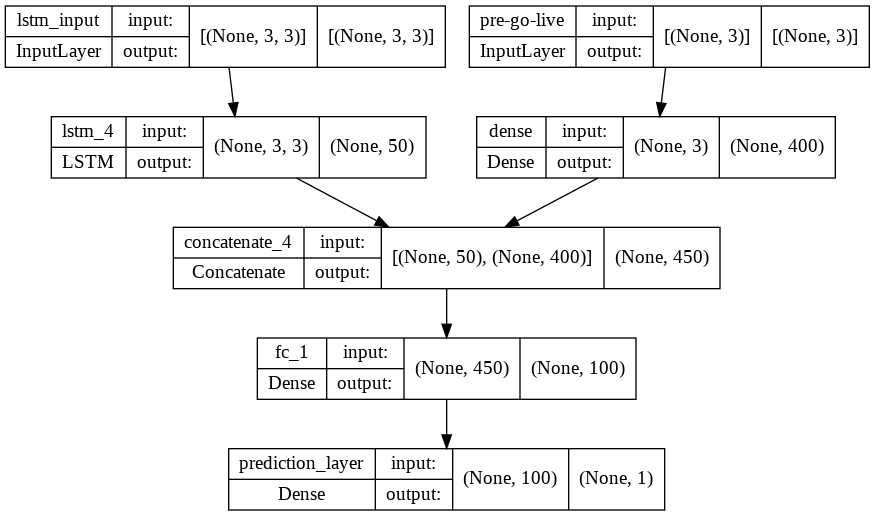

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit([X,time_invariant_data], y, epochs=400, verbose=1, validation_split=0.1)

Epoch 1/400
1/1 [==============================] - 4s 4s/step - loss: 6.7909e-11 - val_loss: 66.9140
Epoch 2/400
1/1 [==============================] - 0s 47ms/step - loss: 75.5654 - val_loss: 1.2456
Epoch 3/400
1/1 [==============================] - 0s 43ms/step - loss: 1.9175 - val_loss: 10.6501
Epoch 4/400
1/1 [==============================] - 0s 44ms/step - loss: 27.9194 - val_loss: 15.7008
Epoch 5/400
1/1 [==============================] - 0s 40ms/step - loss: 47.1899 - val_loss: 7.7557
Epoch 6/400
1/1 [==============================] - 0s 44ms/step - loss: 25.8698 - val_loss: 0.2150
Epoch 7/400
1/1 [==============================] - 0s 42ms/step - loss: 3.3550 - val_loss: 5.8315
Epoch 8/400
1/1 [==============================] - 0s 43ms/step - loss: 3.6775 - val_loss: 22.2062
Epoch 9/400
1/1 [==============================] - 0s 45ms/step - loss: 18.1861 - val_loss: 29.7156
Epoch 10/400
1/1 [==============================] - 0s 48ms/step - loss: 24.0819 - val_loss: 21.6085
Epoch

In [ ]:
# Prediction example
x_input = array([[8,80, 85], [9,90, 95], [10,100, 105]])
x_input = x_input.reshape((1, 3, 3))

x_input_1 = np.array([[0.4,0.5,0.3]])
yhat = model.predict([x_input,x_input_1], verbose=0)
print(yhat)

[[183.67154]]


## Example on initializing initial hidden states of LSTM model with a pre-defined vector

In [ ]:
# Splits a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# Data generation and preparation

# Define input sequence
in_seq0 = array([1,2,3,4,5,6,7,8,9])
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq0 = in_seq0.reshape((len(in_seq0),1))
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq0,in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

In [ ]:
X

array([[[ 1, 10, 15],
        [ 2, 20, 25],
        [ 3, 30, 35]],

       [[ 2, 20, 25],
        [ 3, 30, 35],
        [ 4, 40, 45]],

       [[ 3, 30, 35],
        [ 4, 40, 45],
        [ 5, 50, 55]],

       [[ 4, 40, 45],
        [ 5, 50, 55],
        [ 6, 60, 65]],

       [[ 5, 50, 55],
        [ 6, 60, 65],
        [ 7, 70, 75]],

       [[ 6, 60, 65],
        [ 7, 70, 75],
        [ 8, 80, 85]],

       [[ 7, 70, 75],
        [ 8, 80, 85],
        [ 9, 90, 95]]])

In [ ]:
y

array([ 65,  85, 105, 125, 145, 165, 185])

In [ ]:
time_invariant_data = np.array([[0.4,0.5,0.3],[0.3,0.2,0.1],[0.8,0.9,1.1],[1.4,1.9,0.2],[0.1,0.7,1.2],[0.3,0.2,0.3],[1.1,1.4,0.3]])

In [ ]:
lstm_input = keras.Input(
    shape=(3,3), name="lstm_input"
)  # Variable-length sequence of ints
pre_go_live_input_hidden_states = keras.Input(shape=(3,), name="pre-go-live")  # Variable-length sequence of ints


pre_go_live_fc_layer_1 = keras.layers.Dense(50, activation='relu')(pre_go_live_input_hidden_states)
# Reduce sequence of embedded words in the title into a single 128-dimensional vector
lstm_features = LSTM(50)
outputs = lstm_features(lstm_input, initial_state=[pre_go_live_fc_layer_1,pre_go_live_fc_layer_1])

# Stick a department classifier on top of the features
pred = keras.layers.Dense(1, name="prediction_layer")(outputs)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[lstm_input, pre_go_live_input_hidden_states],
    outputs=[pred]
)

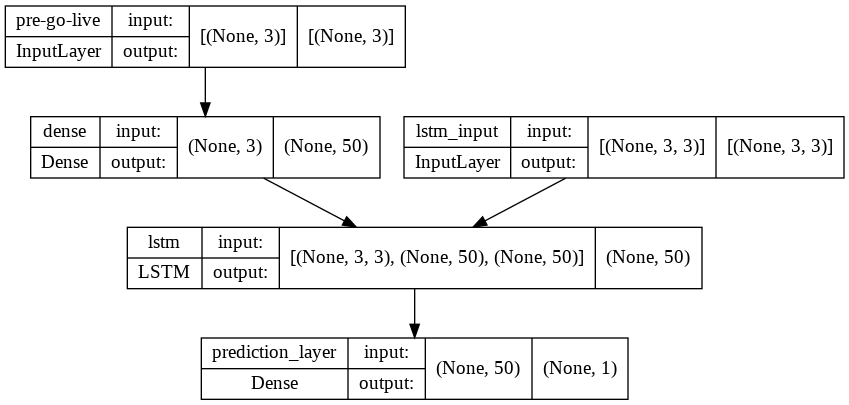

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit([X,time_invariant_data], y, epochs=400, verbose=1)

Epoch 1/400
1/1 [==============================] - 3s 3s/step - loss: 11218.7334
Epoch 2/400
1/1 [==============================] - 0s 20ms/step - loss: 11209.4268
Epoch 3/400
1/1 [==============================] - 0s 16ms/step - loss: 11200.1377
Epoch 4/400
1/1 [==============================] - 0s 13ms/step - loss: 11190.8652
Epoch 5/400
1/1 [==============================] - 0s 12ms/step - loss: 11181.6084
Epoch 6/400
1/1 [==============================] - 0s 11ms/step - loss: 11172.3643
Epoch 7/400
1/1 [==============================] - 0s 15ms/step - loss: 11163.1318
Epoch 8/400
1/1 [==============================] - 0s 13ms/step - loss: 11153.9111
Epoch 9/400
1/1 [==============================] - 0s 13ms/step - loss: 11144.7002
Epoch 10/400
1/1 [==============================] - 0s 13ms/step - loss: 11135.4990
Epoch 11/400
1/1 [==============================] - 0s 14ms/step - loss: 11126.3076
Epoch 12/400
1/1 [==============================] - 0s 11ms/step - loss: 11117.1250
Epo

# Example using Strike dataset (up to 7 days) as a time series problem





## Data Preparation

This step consists on just preprocessing the property level data and offers of properties, such as filtering offers that are not be considered, replacing some missing values (those that can be replaced beforehand), cleaning some columns from input errors, etc.

In [ ]:
# Load property level data (contains info such as number_of_beds, etc)
df_properties_main = pd.read_csv(r"/content/properties_data_all.csv")
df_properties_main.drop_duplicates(subset=['property_id'], inplace=True)
df_properties_main.shape
# Load post go live features/values for up to 7 days
df_properties_daily = pd.read_csv(r"/content/daily_values_7days.csv")
df_properties_daily.shape


## Preprocessing dataset with property level data
# Copy dataframe and change date features to correct format
df_properties = df_properties_main
df_properties['gl_date'] = pd.to_datetime(df_properties['gl_date'])
df_properties['gl_date_year'] = pd.DatetimeIndex(df_properties['gl_date']).year
df_properties['gl_date_month'] = df_properties['gl_date'].dt.month_name()
df_properties['cc_date'] = pd.to_datetime(df_properties['cc_date'])
# Drop epc_expire_date feature, this might be used later on, but need to analyze the impact of it, since this can be a factor for a property 
# to be off market.
df_properties.drop(labels=['epc_expiry_date'], axis=1,inplace=True)

# Remove rows with a higher and lower first listed price
# This might be useful for removing higher first listed prices, since the distribution is skewed to the right.
df_properties = df_properties[(np.abs(stats.zscore(df_properties['first_listed_price'])) < 4)]
df_properties = df_properties[df_properties['first_listed_price'] > 9000]

# Clean council tax band variable
def clean_council_tax_band(row):
  clean_tax_band = row.lower().replace("band ","").replace("#a", "a").replace("aa", "a")\
          .replace("b1200","b").replace("n/a","nan").replace("-","nan")

  if clean_tax_band in ['a','b','c','d','e','f','g']:
    return clean_tax_band
  else:
    return "unknown"

df_properties['council_tax_band'] = df_properties['council_tax_band'].astype(str)
df_properties['council_tax_band'] = df_properties['council_tax_band'].apply(clean_council_tax_band)

# Make the purchase products/services features into a int
# Replace incorrect values and missing values with 0
df_properties['prof_photos'].fillna(0, inplace=True)
df_properties['prof_photos'].replace(2,1,inplace=True)
df_properties['prof_photos'] = df_properties['prof_photos'].astype(int)

df_properties['digitial_marketing_pack'].fillna(0, inplace=True)
df_properties['digitial_marketing_pack'] = df_properties['digitial_marketing_pack'].astype(int)
df_properties['digitial_marketing_pack'].replace(2,1,inplace=True)

df_properties['premium_advert_ordered'].fillna(0, inplace=True)
df_properties['premium_advert_ordered'] = df_properties['premium_advert_ordered'].astype(int)
df_properties['premium_advert_ordered'].replace(2,1,inplace=True)

df_properties['bundle_ordered'].fillna(0, inplace=True)
df_properties['bundle_ordered'] = df_properties['bundle_ordered'].astype(int)
df_properties['bundle_ordered'].replace(2,1,inplace=True)


df_properties['hosted_viewings'].fillna(0, inplace=True)
df_properties['hosted_viewings'] = df_properties['hosted_viewings'].astype(int)
df_properties['hosted_viewings'].replace(2,1,inplace=True)

df_properties['viewing_pack_ordered'].fillna(0, inplace=True)
df_properties['viewing_pack_ordered'] = df_properties['viewing_pack_ordered'].astype(int)
df_properties['viewing_pack_ordered'].replace(2,1,inplace=True)


df_properties['new_build'].fillna(0, inplace=True)
df_properties['new_build'] = df_properties['new_build'].astype(int)

df_properties['strike_market_share_percent'].fillna(0, inplace=True)
df_properties['strike_market_share_percent'] = df_properties['strike_market_share_percent'].astype(float)

# There are properties which have been listed, but then cancelled for various reasons, not providing epc or simply cancelling
# Remove properties which have been listed for less than 14 days or did not receive any offer at all
df_properties['days_listed'] = df_properties['cc_date'] - df_properties['gl_date']
df_properties['days_listed'] = df_properties['days_listed'].dt.days
df_properties['days_listed'].fillna(180.0, inplace=True)
df_properties = df_properties[(df_properties['days_listed'] >= 14) | (df_properties['total_offers'] > 0)]
df_properties_ap = df_properties
df_properties_ap.drop(labels=['days_listed'], axis=1, inplace=True)

# Identify numerical and categorical variables
vars_num = [var for var in df_properties_ap.columns if (df_properties_ap[var].dtypes != 'O') and (var != 'property_id' and var != 'user_id')]
vars_cat = [var for var in df_properties_ap.columns if (df_properties_ap[var].dtypes == 'O')]

# Lower categorical features
for var in vars_cat:
    df_properties_ap[var] = df_properties_ap[var].str.lower()
    df_properties_ap[var] = df_properties_ap[var].str.replace(" ","_")
    # df_properties_ap[var].fillna('other', inplace=True)


# Load offers dataset in order to filter out offers
# Contains information about actual offers made for each property in property dataset
df_offers = pd.read_csv(r"/content/offers_data_all.csv")
# Drop record of properties that did not get an offer at all
df_offers_true = df_offers[~df_offers['days_listing_to_offer_recieved'].isnull()]
# Drop samples that have a negative value input in days_listing_to_offer_recieved and also the offers received after 180 days (6 months)
# Not sure why there are properties with negative values in day_listing_to_offer_recieved
df_offers_true =df_offers_true[(df_offers_true.days_listing_to_offer_recieved >= 0) & (df_offers_true.days_listing_to_offer_recieved <180)]

# Convert days_listing_to_offer_recieved to int, to be able to sort out for getting unique offers
df_offers_true['days_listing_to_offer_recieved'] = df_offers_true['days_listing_to_offer_recieved'].astype(int)

# Calculate difference in percentage between features (offer price vs asking price, and first_listed_price vs listed_price_when_offer)
def percentage_change(col1,col2):
    return round(((col2 - col1)/ col1) * 100,2)

# Compute the difference between a listed price when offer (property asking price at that moment) vs what a buyer offers for it
df_offers_true['diff_offer_vs_price'] = percentage_change(df_offers_true['listed_price_when_offer'],df_offers_true['offer_price'])
# Drop offers that have a -50% or more difference between asking price and offer price
df_offers_true_merged = df_offers_true[np.abs(df_offers_true['diff_offer_vs_price']) <= 50]
# Drop offers with the same offer_id value, not sure why the query gives more offers (duplicated), might be the query and its left joins.
df_offers_true_merged.drop_duplicates(subset=['offer_id'], inplace=True)



# Take the latest offer from a buyer. A buyer might offer more than once (either because the previous is withdrawn or rejected). Only consider the latest offer.

# Sort offers received by each property by date received and buyer, only keep latest one
unique_offers = df_offers_true_merged[['property_id','buyer_user_id','offer_id','days_listing_to_offer_recieved']].sort_values('days_listing_to_offer_recieved').drop_duplicates(['property_id','buyer_user_id'], keep='last')
unique_offers_join_prop = unique_offers.groupby(['property_id']).size().reset_index()
unique_offers_join_prop.rename(columns={0:'unique_offers'}, inplace=True)
# Join unique number of offers with the property aggregated dataset which contains property level features
df_properties_ap = df_properties_ap.merge(unique_offers_join_prop, on = 'property_id', how='left')
df_properties_ap['unique_offers'].fillna(0, inplace=True)
df_properties_ap['unique_offers'] = df_properties_ap['unique_offers'].astype(int)

# Do not count  offers that are -13.31 lower than the asking price, or are not marked as complete
df_offers_true_merged = df_offers_true_merged[~((df_offers_true_merged['diff_offer_vs_price'] < -13.31) & (df_offers_true_merged['offer_status'] != 'complete'))]
df_offers_true_merged = df_offers_true_merged.merge(unique_offers['offer_id'],
                                                on='offer_id', how='inner')
unique_offers_join_prop = df_offers_true_merged.groupby(['property_id']).size().reset_index()
unique_offers_join_prop.rename(columns={0:'unique_offers_cut'}, inplace=True)
df_properties_ap = df_properties_ap.merge(unique_offers_join_prop, on = 'property_id', how='left')
df_properties_ap['unique_offers_cut'].fillna(0, inplace=True)
df_properties_ap['unique_offers_cut'] = df_properties_ap['unique_offers_cut'].astype(int)

df_properties_ap['unique_offers_cut'] = np.where(df_properties_ap['offers_received_7days'] > df_properties_ap['unique_offers_cut'], df_properties_ap['unique_offers'], df_properties_ap['unique_offers_cut'])
# Partially validate filtering of number of offers was done correct
test = df_properties_ap
assert len(test[test['unique_offers'] > test['total_offers']]) == 0
assert len(test[test['unique_offers_cut'] > test['unique_offers']]) == 0
# Preprocessing on specific features that have odd values
df_properties_ap = df_properties_ap[df_properties_ap['build_year'] > 1800]
df_properties_ap['build_year_group'] = np.where(df_properties_ap['build_year'] == 2000, 'post_2000',df_properties_ap['build_year_group'])
df_properties_ap.drop(labels=['unique_offers','total_offers', 'cc_date','sq_ft','council_tax_cost', 'strike_agent','key_features'], axis=1,inplace=True)
print(df_properties_ap.shape)
# Identify numerical and categorical variables
vars_num = [var for var in df_properties_ap.columns if (df_properties_ap[var].dtypes != 'O') and (var != 'property_id' and var != 'user_id')]
vars_cat = [var for var in df_properties_ap.columns if (df_properties_ap[var].dtypes == 'O') and (var != 'gl_date' and var != 'cc_date')]

# Check for missing values in each feature
vars_num_na = [var for var in vars_num if df_properties_ap[var].isnull().sum() > 0]
print('Numerical features missing values report:')
print(df_properties_ap[vars_num_na].isnull().mean().sort_values(ascending=False))
print('\n')
print('Categorical features missing values report:')
vars_cat_na = [var for var in vars_cat if df_properties_ap[var].isnull().sum() > 0]
print(df_properties_ap[vars_cat_na].isnull().mean().sort_values(ascending=False))
df_properties_ap['avgprice_sim_strike_ppts_ol'] = np.where(df_properties_ap['avgprice_sim_strike_ppts_ol'].isnull(), 
                                                            df_properties_ap['first_listed_price'],df_properties_ap['avgprice_sim_strike_ppts_ol'])

df_properties_ap['avg_rm_views_sim_strike_ppts_ol'] = np.where(df_properties_ap['avg_rm_views_sim_strike_ppts_ol'].isnull(), 
                                                            0,df_properties_ap['avg_rm_views_sim_strike_ppts_ol'])
# Identify numerical and categorical variables
vars_num = [var for var in df_properties_ap.columns if (df_properties_ap[var].dtypes != 'O') and (var != 'property_id' and var != 'user_id')]
vars_cat = [var for var in df_properties_ap.columns if (df_properties_ap[var].dtypes == 'O') and (var != 'gl_date' and var != 'cc_date')]

KeyError: ignored

In [ ]:
df_properties_daily_not_cummulative = df_properties_daily

# Extract features from date of reporting column
df_properties_daily_not_cummulative['date_of_reporting'] = pd.to_datetime(df_properties_daily_not_cummulative['date_of_reporting'])
df_properties_daily_not_cummulative['year'] = df_properties_daily_not_cummulative['date_of_reporting'].dt.year
df_properties_daily_not_cummulative['month'] = df_properties_daily_not_cummulative['date_of_reporting'].dt.month
df_properties_daily_not_cummulative['day'] = df_properties_daily_not_cummulative['date_of_reporting'].dt.day
df_properties_daily_not_cummulative = df_properties_daily_not_cummulative[['property_id','year','month','day','days_since_live','vr_daily','vc_daily',
                                           'price_change_percentage_daily','rm_summary_views_daily','rm_detailed_views_daily',
                                           'premium_listing_daily','featured_property_daily',
                                           'sim_ppts_ol_listed_daily','sim_ppts_ol_stc_daily','offers_recieved_daily']]

In [ ]:
## Preprocessing dataset with daily values
# There are some features that can be enginer from the current daily values, such as cummulative sum of daily values, extracting the year, month and day from date, etc.
# Cummulative sum
df_properties_daily['vr_daily_cumsum'] = df_properties_daily.groupby('property_id').vr_daily.cumsum()
df_properties_daily['vc_daily_cumsum'] = df_properties_daily.groupby('property_id').vc_daily.cumsum()
df_properties_daily['rm_summary_views_daily_cumsum'] = df_properties_daily.groupby('property_id').rm_summary_views_daily.cumsum()
df_properties_daily['rm_detailed_views_daily_cumsum'] = df_properties_daily.groupby('property_id').rm_detailed_views_daily.cumsum()
df_properties_daily['sim_ppts_ol_listed_daily_cumsum'] = df_properties_daily.groupby('property_id').sim_ppts_ol_listed_daily.cumsum()
df_properties_daily['sim_ppts_ol_stc_daily_cumsum'] = df_properties_daily.groupby('property_id').sim_ppts_ol_stc_daily.cumsum()
df_properties_daily['offers_recieved_daily_cumsum'] = df_properties_daily.groupby('property_id').offers_recieved_daily.cumsum()

# Extract features from date of reporting column
df_properties_daily['date_of_reporting'] = pd.to_datetime(df_properties_daily['date_of_reporting'])
df_properties_daily['year'] = df_properties_daily['date_of_reporting'].dt.year
df_properties_daily['month'] = df_properties_daily['date_of_reporting'].dt.month
df_properties_daily['day'] = df_properties_daily['date_of_reporting'].dt.day
df_properties_daily = df_properties_daily[['property_id','year','month','day','days_since_live','vr_daily_cumsum','vc_daily_cumsum',
                                           'price_change_percentage_daily','rm_summary_views_daily_cumsum','rm_detailed_views_daily_cumsum',
                                           'premium_listing_daily','featured_property_daily',
                                           'sim_ppts_ol_listed_daily_cumsum','sim_ppts_ol_stc_daily_cumsum','offers_recieved_daily_cumsum']]

In [ ]:
df_properties_daily.mask(df_properties_daily < 0, np.nan, inplace=True)

## Using only post go live data

For this part, only post go live data points will be used for training, only features such as number of viewings request/completed, price changes, rightmove  views after property has gone live will be included.

It would not have any context/information related to the property level data, such as number of bedrooms, location, first listed price, etc.

In [ ]:
vars_num = ['year','month','day','days_since_live','vr_daily_cumsum','vc_daily_cumsum',
                     'price_change_percentage_daily','rm_summary_views_daily_cumsum','rm_detailed_views_daily_cumsum',
                     'premium_listing_daily','featured_property_daily',
                     'sim_ppts_ol_listed_daily_cumsum','sim_ppts_ol_stc_daily_cumsum',
                     'offers_recieved_daily_cumsum']

In [ ]:
# Merging with property level dataframe to get the total number of offers received within 6 months for each property
final_df = pd.merge(df_properties_daily, df_properties_ap[['property_id','unique_offers_cut']], how="inner", on=['property_id'])
final_df_1 = final_df.drop(['property_id'], axis=1)

In [ ]:
# Lets transform the dataset (which is in a pandas df, to a numpy array)
dataset_features = final_df_1.drop(['unique_offers_cut'],axis=1).to_numpy()

# Since each property has 7 rows, representing 7 days of being live, they will need to be group in a 3-d array in order to be splitted later on into train, validation 
# and test data, and be giving to the model. The shape should be (unique_properties, timesteps, features)
X = dataset_features.reshape(len(final_df['property_id'].unique()),7,dataset_features.shape[1])

# Additionally, we will need the target variable, which is this case, it will be the total number of offers within 6 months
y = final_df[['property_id','unique_offers_cut']]
y.drop_duplicates(subset=['property_id'], inplace=True)
y = y['unique_offers_cut'].to_numpy()

In [ ]:
# Lets train test split the data (this will be done twice), so there is also a validation set used while training to detect under/over fitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=14)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=14)

In [ ]:
# Before initializing training, we will standarize and normalize, and replace missing values

numeric_preprocessor = Pipeline(
        steps = [
            ('imputation_mean', KNNImputer()),
            ('scaler', RobustScaler())
        ]
    )

preprocessor = ColumnTransformer([
                                  ('num_preprocessor', numeric_preprocessor, vars_num)], 
                                 sparse_threshold= 0, remainder='passthrough')

In [ ]:
# In order to use an scaler/transformer, data needs to be in a 2-d shape, and our current data is in 3-d
X_train_df = pd.DataFrame(X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2]))
X_train_df.columns = final_df_1.columns[0:-1] # Just adding original column names (not really needed, used for reference)

# Using scaler to normalize data
X_train_df_encoded = pd.DataFrame(preprocessor.fit_transform(X_train_df))
X_train_df_encoded.columns = preprocessor.named_transformers_['num_preprocessor'].named_steps['scaler'].get_feature_names_out()
X_train = X_train_df_encoded.to_numpy()
X_train = X_train.reshape(int(X_train.shape[0] / 7), 7, X_train.shape[1]) # Reshaping data from 2-d to 3-d

In [ ]:
# Doing same above process but with validation data and using fitted scaler to only transform data
X_val_df = pd.DataFrame(X_val.reshape(X_val.shape[0]*X_val.shape[1], X_val.shape[2]))
X_val_df.columns = final_df_1.columns[0:-1]
X_val_df_encoded = pd.DataFrame(preprocessor.transform(X_val_df))
X_val = X_val_df_encoded.to_numpy()
X_val = X_val.reshape(int(X_val.shape[0] / 7), 7, X_val.shape[1])

In [ ]:
# Doing same above process but with test data
# Using same scaler to normalize features
X_test_df = pd.DataFrame(X_test.reshape(X_test.shape[0]*X_test.shape[1], X_test.shape[2]))
X_test_df.columns = final_df_1.columns[0:-1]
X_test_df_encoded = pd.DataFrame(preprocessor.transform(X_test_df))
X_test = X_test_df_encoded.to_numpy()
X_test = X_test.reshape(int(X_test.shape[0] / 7), 7, X_test.shape[1])

#### Using LSTM (Stateless)

In [ ]:
# Defining LSTM model
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(7, X_train.shape[2]))) # Input shape is n_timesteps, n_features
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# EarlyStopping callback to stop training if validation loss does not decrease after certain # of epochs
callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# fit model
model.fit(X_train, y_train, epochs=40, verbose=1, validation_data=(X_val, y_val), callbacks = [callback]) # Using validation data so after each epoch, model evaluates and gives results

Epoch 1/40
740/740 [==============================] - 14s 16ms/step - loss: 2.9260 - val_loss: 2.3313
Epoch 2/40
740/740 [==============================] - 11s 14ms/step - loss: 2.6078 - val_loss: 2.2987
Epoch 3/40
740/740 [==============================] - 11s 14ms/step - loss: 2.5486 - val_loss: 2.2974
Epoch 4/40
740/740 [==============================] - 11s 14ms/step - loss: 2.5181 - val_loss: 2.4661
Epoch 5/40
740/740 [==============================] - 10s 14ms/step - loss: 2.4840 - val_loss: 2.3016
Epoch 6/40
740/740 [==============================] - 11s 14ms/step - loss: 2.4828 - val_loss: 2.2629
Epoch 7/40
740/740 [==============================] - 11s 15ms/step - loss: 2.4511 - val_loss: 2.2619
Epoch 8/40
740/740 [==============================] - 11s 15ms/step - loss: 2.4404 - val_loss: 2.2738
Epoch 9/40
740/740 [==============================] - 11s 14ms/step - loss: 2.4173 - val_loss: 2.3567
Epoch 10/40
740/740 [==============================] - 11s 15ms/step - loss: 2.449

#### Using RNN

In [ ]:
model_rnn = Sequential()
model_rnn.add(keras.layers.SimpleRNN(50, activation='relu', input_shape=(7, X_train.shape[2])))
model_rnn.add(Dense(1))
model_rnn.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# EarlyStopping callback to stop training if validation loss does not decrease after certain # of epochs
callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# fit model
model_rnn.fit(X_train, y_train, epochs=40, verbose=1, validation_data=(X_val, y_val), callbacks = [callback]) # Using validation data so after each epoch, model evaluates and gives results

Epoch 1/40
740/740 [==============================] - 6s 8ms/step - loss: 2.7405 - val_loss: 2.3072
Epoch 2/40
740/740 [==============================] - 6s 8ms/step - loss: 2.5348 - val_loss: 2.2939
Epoch 3/40
740/740 [==============================] - 6s 7ms/step - loss: 2.5202 - val_loss: 2.3004
Epoch 4/40
740/740 [==============================] - 5s 7ms/step - loss: 2.4908 - val_loss: 2.4657
Epoch 5/40
740/740 [==============================] - 6s 8ms/step - loss: 2.4757 - val_loss: 2.3474
Epoch 6/40
740/740 [==============================] - 5s 7ms/step - loss: 2.4698 - val_loss: 2.3342
Epoch 7/40
740/740 [==============================] - 6s 8ms/step - loss: 2.4702 - val_loss: 2.3271
Epoch 8/40
740/740 [==============================] - 6s 8ms/step - loss: 2.4421 - val_loss: 2.3323
Epoch 9/40
740/740 [==============================] - 6s 7ms/step - loss: 2.4230 - val_loss: 2.3680
Epoch 10/40
740/740 [==============================] - 6s 8ms/step - loss: 2.3931 - val_loss: 2.3365

#### Using CNN

In [ ]:
# define model
model_cnn = Sequential()
model_cnn.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(7, X_train.shape[2])))
model_cnn.add(keras.layers.MaxPooling1D(pool_size=2))
model_cnn.add(keras.layers.Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(optimizer='adam', loss='mse')

In [ ]:
# EarlyStopping callback to stop training if validation loss does not decrease after certain # of epochs
callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# fit model
model_cnn.fit(X_train, y_train, epochs=40, verbose=1, validation_data=(X_val, y_val), callbacks = [callback]) # Using validation data so after each epoch, model evaluates and gives results

Epoch 1/40
740/740 [==============================] - 12s 3ms/step - loss: 2.8119 - val_loss: 2.3550
Epoch 2/40
740/740 [==============================] - 2s 3ms/step - loss: 2.5591 - val_loss: 2.3527
Epoch 3/40
740/740 [==============================] - 2s 3ms/step - loss: 2.5158 - val_loss: 2.3836
Epoch 4/40
740/740 [==============================] - 2s 3ms/step - loss: 2.5083 - val_loss: 2.4883
Epoch 5/40
740/740 [==============================] - 2s 3ms/step - loss: 2.4774 - val_loss: 2.3602
Epoch 6/40
740/740 [==============================] - 2s 3ms/step - loss: 2.4769 - val_loss: 2.3456
Epoch 7/40
740/740 [==============================] - 2s 3ms/step - loss: 2.4831 - val_loss: 2.3550
Epoch 8/40
740/740 [==============================] - 2s 3ms/step - loss: 2.4641 - val_loss: 2.3259
Epoch 9/40
740/740 [==============================] - 2s 3ms/step - loss: 2.4343 - val_loss: 2.3202
Epoch 10/40
740/740 [==============================] - 2s 3ms/step - loss: 2.4225 - val_loss: 2.317

#### Evaluating each model

In [ ]:
# Getting predictions for LSTM model
preds = model.predict(X_test)

# Evaluating results
print("MAE: %s" % mean_absolute_error(y_test, preds))
print("MSE: %s" % mean_squared_error(y_test, preds))
print("RMSE: %s" % mean_squared_error(y_test, preds, squared=False))
print("R2: %s" % r2_score(y_test, preds))

MAE: 1.0854358758815885
MSE: 2.578840133856157
RMSE: 1.6058767492731678
R2: 0.515347072078855


In [ ]:
# Getting predictions for RNN model
preds = model_rnn.predict(X_test)

# Evaluating results
print("MAE: %s" % mean_absolute_error(y_test, preds))
print("MSE: %s" % mean_squared_error(y_test, preds))
print("RMSE: %s" % mean_squared_error(y_test, preds, squared=False))
print("R2: %s" % r2_score(y_test, preds))

MAE: 1.0734338569442816
MSE: 2.610864120457416
RMSE: 1.6158168585756914
R2: 0.5093286614506631


In [ ]:
# Getting predictions for CNN model
preds = model_cnn.predict(X_test)

# Evaluating results
print("MAE: %s" % mean_absolute_error(y_test, preds))
print("MSE: %s" % mean_squared_error(y_test, preds))
print("RMSE: %s" % mean_squared_error(y_test, preds, squared=False))
print("R2: %s" % r2_score(y_test, preds))

MAE: 1.0709038579196355
MSE: 2.6096981534620975
RMSE: 1.615456020280991
R2: 0.5095477868282783


## Using daily values + property level data duplicated

In the previous section, only daily values were used, and no context about the property was introduced. For this part, information about the information such as number of beds, first listed price, marketing products acquired, market data, information on similar strike properties will be introduced.

In order to introduce this information, there are multiple approaches and with different level of complexity.

The most basic approach, is to duplicate the time invariant features, alongside the post go live features (in our case, it will be the pre go live features). This is simple, in the sense that the model used for training will only get input from one source.



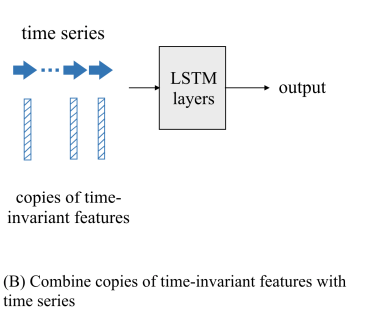


The previous approach is tested in the following part:

In [ ]:
# Defining names of categorical, numerical and daily values (post-go live features) features
vars_num = ['number_of_beds','no_of_bathrooms','no_of_receptions','land','new_build','build_year',
            'epc_exempt','virtual_visit','prof_photos','digitial_marketing_pack','can_have_board',
            'premium_advert_ordered','bundle_ordered','hosted_viewings','viewing_pack_ordered',
            'strike_market_share_percent','first_listed_price','population_in_area','population_density',
            'income_decile','populated_area','pop_area_with_gospace_access','pct_pop_area_with_gospace_access',
            'pct_pop_area_without_gospace_access','pop_without_gospace_access','average_demand_trend_6weeks',
            'avg_sales_quarter_3qts','avg_median_pricepaid_3qts',	'avg_price_3months','avg_hpi_index_3months',
            'avg_monthly_change_3months','avg_annual_change_3months','no_sim_ppts_ol',
            'avgweeks_inmarket_sim_ppts_ol','avgprice_sim_ppts_ol','medianprice_sim_ppts_ol',
            'no_sim_ppts_ol_stc','avgweeks_to_stc_sim_ppts_ol_stc','avgprice_sim_ppts_ol_stc',
            'medianprice_sim_ppts_ol_stc','no_sim_strike_ppts_ol','avgprice_sim_strike_ppts_ol', 
            'avg_offers_sim_strike_ppts_ol','avg_vr_sim_strike_ppts_ol','avg_vc_sim_strike_ppts_ol']

vars_cat = ['property_type','build_year_group','tenure_type','heating_type','double_glazing','parking_type','garden','council_tax_band','itv_region','urban_rural_category','county',
            'rural_ubran_classification_detail_lsoa','rural_urban_classification_detail_msoa','spatial_signature_type','chain_situation','strike_defined_channel','listing_pricetype',
            'gl_date_month']

daily_values_vars = ['year','month','day','days_since_live','vr_daily_cumsum','vc_daily_cumsum',
                     'price_change_percentage_daily','rm_summary_views_daily_cumsum','rm_detailed_views_daily_cumsum',
                     'premium_listing_daily','featured_property_daily',
                     'sim_ppts_ol_listed_daily_cumsum','sim_ppts_ol_stc_daily_cumsum',
                     'offers_recieved_daily_cumsum']

target = ['unique_offers_cut']

In [ ]:
# Merging pre-go live features with post go live (daily values) features datasets
final_df = pd.merge(df_properties_daily,df_properties_ap[['property_id']+vars_num + vars_cat + target], how="inner", on=['property_id'])
final_df.head(14)

,property_id,year,month,day,days_since_live,vr_daily_cumsum,vc_daily_cumsum,price_change_percentage_daily,rm_summary_views_daily_cumsum,rm_detailed_views_daily_cumsum,...,urban_rural_category,county,rural_ubran_classification_detail_lsoa,rural_urban_classification_detail_msoa,spatial_signature_type,chain_situation,strike_defined_channel,listing_pricetype,gl_date_month,unique_offers_cut
0,33901,2018,1,17,0,0,0,0.0,1269.0,67.0,...,urban,london,urban_major_conurbation,urban_major_conurbation,dense_residential_neighbourhoods,no_chain,direct,guide,january,1
1,33901,2018,1,18,1,1,0,0.0,1954.0,123.0,...,urban,london,urban_major_conurbation,urban_major_conurbation,dense_residential_neighbourhoods,no_chain,direct,guide,january,1
2,33901,2018,1,19,2,3,0,0.0,2660.0,163.0,...,urban,london,urban_major_conurbation,urban_major_conurbation,dense_residential_neighbourhoods,no_chain,direct,guide,january,1
3,33901,2018,1,20,3,3,0,0.0,3326.0,201.0,...,urban,london,urban_major_conurbation,urban_major_conurbation,dense_residential_neighbourhoods,no_chain,direct,guide,january,1
4,33901,2018,1,21,4,3,0,0.0,3974.0,230.0,...,urban,london,urban_major_conurbation,urban_major_conurbation,dense_residential_neighbourhoods,no_chain,direct,guide,january,1
5,33901,2018,1,22,5,3,0,0.0,4540.0,265.0,...,urban,london,urban_major_conurbation,urban_major_conurbation,dense_residential_neighbourhoods,no_chain,direct,guide,january,1
6,33901,2018,1,23,6,3,1,0.0,5079.0,281.0,...,urban,london,urban_major_conurbation,urban_major_conurbation,dense_residential_neighbourhoods,no_chain,direct,guide,january,1
7,36484,2018,3,23,0,0,0,0.0,2750.0,176.0,...,urban,merseyside,urban_major_conurbation,urban_major_conurbation,urban_buffer,no_chain,NaN,over,march,0
8,36484,2018,3,24,1,0,0,0.0,4102.0,254.0,...,urban,merseyside,urban_major_conurbation,urban_major_conurbation,urban_buffer,no_chain,NaN,over,march,0
9,36484,2018,3,25,2,0,0,0.0,7657.0,391.0,...,urban,merseyside,urban_major_conurbation,urban_major_conurbation,urban_buffer,no_chain,NaN,over,march,0


In [ ]:
# Check for missing values in each feature
na_vars = [var for var in final_df.columns if final_df[var].isnull().sum() > 0]
print('Numerical features missing values report:')
print(final_df[na_vars].isnull().mean().sort_values(ascending=False))

Numerical features missing values report:
premium_listing_daily             0.099899
featured_property_daily           0.099899
rm_summary_views_daily_cumsum     0.019707
rm_detailed_views_daily_cumsum    0.019707
double_glazing                    0.009240
county                            0.002552
urban_rural_category              0.000485
strike_defined_channel            0.000291
price_change_percentage_daily     0.000032
avg_price_3months                 0.000032
avg_hpi_index_3months             0.000032
avg_monthly_change_3months        0.000032
avg_annual_change_3months         0.000032
parking_type                      0.000032
listing_pricetype                 0.000032
dtype: float64


In [ ]:
final_df_1 = final_df.drop(['property_id'], axis=1)
final_df_1.shape

(216678, 78)

In [ ]:
# Lets transform the dataset (which is in a pandas df, to a numpy array)
dataset_features = final_df_1.drop(['unique_offers_cut'],axis=1).to_numpy()

# Since each property has 7 rows, representing 7 days of being live, they will need to be group in a 3-d array in order to be splitted later on into train, validation and test data.
X = dataset_features.reshape(int(final_df_1.shape[0] / 7),7,final_df_1.shape[1]-1)

# Additionally, we will need the target variable, which is this case, it will be the total number of offers within 6 months
y = final_df[['property_id','unique_offers_cut']]
y.drop_duplicates(subset=['property_id'], inplace=True)
y = y['unique_offers_cut'].to_numpy()

In [ ]:
# Lets train test split the data, we will have the test set, which will be used for evaluating only
# And also the train and validation set, where the validation set will be used during training only to see if the
# model is overfitting and tune the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=14)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=14)

In [ ]:
# Since we are introducing new variables (where some have missing values), numerical and categorical, we will need to use additional transformations, 
# such as one-hot-encoding for categorical features, and imputation for missing values.

numeric_preprocessor = Pipeline(
        steps = [
            ('imputation_mean', KNNImputer()),
            ('scaler', RobustScaler())
        ]
    )

daily_values_preprocessor = Pipeline(
        steps = [
            ('imputation_mean', KNNImputer()),
            ('scaler', RobustScaler())
        ]
    )

categorical_preprocessor = Pipeline(
        steps = [
            ('imputation_mode', SimpleImputer(strategy='most_frequent')),
            ('ohe',OneHotEncoder(handle_unknown='ignore', sparse=False))
            
        ]
    )

preprocessor = ColumnTransformer([
                                  ('cat_preprocessor', categorical_preprocessor, vars_cat),
                                  ('num_preprocessor', numeric_preprocessor, vars_num),
                                  ('dv_preprocessor', daily_values_preprocessor, daily_values_vars)], 
                                 sparse_threshold= 0, remainder='passthrough')

In [ ]:
# In order to use an scaler/transformer, data needs to be in a 2-d shape, and our current data is in 3-d
X_train_df = pd.DataFrame(X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2]))
X_train_df.columns = final_df_1.columns[0:-1] # Just adding original column names (not really needed, just for reference)

# Using transformer to fit and transform training data
train_df_encoded = preprocessor.fit_transform(X_train_df)

X_train_df_encoded = pd.DataFrame(train_df_encoded)

# Following 4 lines are optional
encoded_categorical_columns_names = preprocessor.named_transformers_['cat_preprocessor'].named_steps['ohe'].get_feature_names_out(vars_cat)
numerical_columns_names = preprocessor.named_transformers_['num_preprocessor'].named_steps['scaler'].get_feature_names_out(vars_num)
dv_columns_names = preprocessor.named_transformers_['dv_preprocessor'].named_steps['scaler'].get_feature_names_out(daily_values_vars)
X_train_df_encoded.columns = [*encoded_categorical_columns_names,*numerical_columns_names,*dv_columns_names]

# Reshaping data into 3-d shape
X_train = X_train_df_encoded.to_numpy()
X_train = X_train.reshape(int(X_train.shape[0] / 7), 7, X_train.shape[1]) # Reshaping data from 2-d to 3-d

In [ ]:
# Doing same above process but with validation data and using fitted scaler to only transform data
X_val_df = pd.DataFrame(X_val.reshape(X_val.shape[0]*X_val.shape[1], X_val.shape[2]))
X_val_df.columns = final_df_1.columns[0:-1]
X_val_df_encoded = pd.DataFrame(preprocessor.transform(X_val_df))

# Optional
encoded_categorical_columns_names = preprocessor.named_transformers_['cat_preprocessor'].named_steps['ohe'].get_feature_names_out(vars_cat)
numerical_columns_names = preprocessor.named_transformers_['num_preprocessor'].named_steps['scaler'].get_feature_names_out(vars_num)
dv_columns_names = preprocessor.named_transformers_['dv_preprocessor'].named_steps['scaler'].get_feature_names_out(daily_values_vars)
X_val_df_encoded.columns = [*encoded_categorical_columns_names,*numerical_columns_names,*dv_columns_names]

# Reshaping data into 3-d shape
X_val = X_val_df_encoded.to_numpy()
X_val = X_val.reshape(int(X_val.shape[0] / 7), 7, X_val.shape[1])

### Using LSTM

In [ ]:
# Defining LSTM model
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(7, X_train.shape[2]))) # Input shape is n_timesteps, n_features
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# EarlyStopping callback to stop training if validation loss does not decrease after certain # of epochs
callback = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
# fit model
model.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_val, y_val), callbacks = [callback]) # Using validation data so after each epoch, model evaluates and gives results

Epoch 1/100
740/740 [==============================] - 13s 15ms/step - loss: 3.0801 - val_loss: 2.2839
Epoch 2/100
740/740 [==============================] - 11s 14ms/step - loss: 2.5171 - val_loss: 2.2570
Epoch 3/100
740/740 [==============================] - 11s 14ms/step - loss: 2.4096 - val_loss: 2.2283
Epoch 4/100
740/740 [==============================] - 10s 14ms/step - loss: 2.3735 - val_loss: 2.4127
Epoch 5/100
740/740 [==============================] - 10s 14ms/step - loss: 2.3147 - val_loss: 2.2664
Epoch 6/100
740/740 [==============================] - 10s 14ms/step - loss: 2.2260 - val_loss: 2.3376
Epoch 7/100
740/740 [==============================] - 11s 14ms/step - loss: 2.2314 - val_loss: 2.2958
Epoch 8/100
740/740 [==============================] - 11s 14ms/step - loss: 2.1134 - val_loss: 2.2678
Epoch 9/100
740/740 [==============================] - 10s 14ms/step - loss: 1.9552 - val_loss: 2.4120
Epoch 10/100
740/740 [==============================] - 10s 14ms/step - l

In [ ]:
# Defining LSTM model
model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=True,input_shape=(7, X_train.shape[2]))) # Input shape is n_timesteps, n_features
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# EarlyStopping callback to stop training if validation loss does not decrease after certain # of epochs
callback = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
# fit model
model.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_val, y_val), callbacks = [callback]) # Using validation data so after each epoch, model evaluates and gives results

Epoch 1/100
740/740 [==============================] - 45s 57ms/step - loss: 3.0126 - val_loss: 2.3386
Epoch 2/100
740/740 [==============================] - 40s 54ms/step - loss: 2.5685 - val_loss: 2.3915
Epoch 3/100
740/740 [==============================] - 44s 59ms/step - loss: 2.4189 - val_loss: 2.2616
Epoch 4/100
740/740 [==============================] - 27s 37ms/step - loss: 2.3744 - val_loss: 2.3438
Epoch 5/100
740/740 [==============================] - 20s 27ms/step - loss: 2.3280 - val_loss: 2.2875
Epoch 6/100
740/740 [==============================] - 20s 27ms/step - loss: 2.2084 - val_loss: 2.3897
Epoch 7/100
740/740 [==============================] - 20s 27ms/step - loss: 2.2101 - val_loss: 2.2974
Epoch 8/100
740/740 [==============================] - 20s 28ms/step - loss: 2.1353 - val_loss: 2.2883
Epoch 9/100
740/740 [==============================] - 20s 27ms/step - loss: 2.0124 - val_loss: 2.4021
Epoch 10/100
740/740 [==============================] - 20s 27ms/step - l

### Using RNN

In [ ]:
model_rnn = Sequential()
model_rnn.add(keras.layers.SimpleRNN(50, activation='relu', input_shape=(7, X_train.shape[2])))
model_rnn.add(Dense(1))
model_rnn.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# EarlyStopping callback to stop training if validation loss does not decrease after certain # of epochs
callback = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
# fit model
model_rnn.fit(X_train, y_train, epochs=40, verbose=1, validation_data=(X_val, y_val), callbacks = [callback]) # Using validation data so after each epoch, model evaluates and gives results

Epoch 1/40
740/740 [==============================] - 13s 16ms/step - loss: 2.7979 - val_loss: 2.2467
Epoch 2/40
740/740 [==============================] - 14s 19ms/step - loss: 2.5066 - val_loss: 2.2584
Epoch 3/40
740/740 [==============================] - 7s 9ms/step - loss: 2.4729 - val_loss: 2.2493
Epoch 4/40
740/740 [==============================] - 6s 7ms/step - loss: 2.3533 - val_loss: 2.4471
Epoch 5/40
740/740 [==============================] - 6s 8ms/step - loss: 2.2959 - val_loss: 2.2923
Epoch 6/40
740/740 [==============================] - 6s 8ms/step - loss: 2.2383 - val_loss: 2.2890
Epoch 7/40
740/740 [==============================] - 6s 8ms/step - loss: 2.2143 - val_loss: 2.2710
Epoch 8/40
740/740 [==============================] - 7s 9ms/step - loss: 2.1903 - val_loss: 2.2723
Epoch 9/40
740/740 [==============================] - 6s 7ms/step - loss: 2.0714 - val_loss: 2.3935
Epoch 10/40
740/740 [==============================] - 6s 8ms/step - loss: 2.0233 - val_loss: 2.

### Using CNN

In [ ]:
# define model
model_cnn = Sequential()
model_cnn.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(7, X_train.shape[2])))
model_cnn.add(keras.layers.MaxPooling1D(pool_size=2))
model_cnn.add(keras.layers.Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(optimizer='adam', loss='mse')

In [ ]:
# EarlyStopping callback to stop training if validation loss does not decrease after certain # of epochs
callback = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
# fit model
model_cnn.fit(X_train, y_train, epochs=40, verbose=1, validation_data=(X_val, y_val), callbacks = [callback]) # Using validation data so after each epoch, model evaluates and gives results

Epoch 1/40
740/740 [==============================] - 3s 3ms/step - loss: 2.8211 - val_loss: 2.2839
Epoch 2/40
740/740 [==============================] - 2s 3ms/step - loss: 2.4861 - val_loss: 2.3561
Epoch 3/40
740/740 [==============================] - 2s 3ms/step - loss: 2.6027 - val_loss: 2.2690
Epoch 4/40
740/740 [==============================] - 2s 3ms/step - loss: 2.5863 - val_loss: 2.4098
Epoch 5/40
740/740 [==============================] - 3s 4ms/step - loss: 2.3613 - val_loss: 2.2749
Epoch 6/40
740/740 [==============================] - 3s 4ms/step - loss: 2.3812 - val_loss: 2.2905
Epoch 7/40
740/740 [==============================] - 2s 3ms/step - loss: 2.1887 - val_loss: 2.2799
Epoch 8/40
740/740 [==============================] - 2s 3ms/step - loss: 2.1382 - val_loss: 2.2799
Epoch 9/40
740/740 [==============================] - 2s 3ms/step - loss: 2.0870 - val_loss: 2.3772
Epoch 10/40
740/740 [==============================] - 2s 3ms/step - loss: 1.9636 - val_loss: 2.3895

### Evaluating each model

In [ ]:
# Evaluating model with test data
# Using same scaler to normalize features
X_test_df = pd.DataFrame(X_test.reshape(X_test.shape[0]*X_test.shape[1], X_test.shape[2]))
X_test_df.columns = final_df_1.columns[0:-1]


X_test_df_encoded = pd.DataFrame(preprocessor.transform(X_test_df))
encoded_categorical_columns_names = preprocessor.named_transformers_['cat_preprocessor'].named_steps['ohe'].get_feature_names_out(vars_cat)
numerical_columns_names = preprocessor.named_transformers_['num_preprocessor'].named_steps['scaler'].get_feature_names_out(vars_num)
dv_columns_names = preprocessor.named_transformers_['dv_preprocessor'].named_steps['scaler'].get_feature_names_out(daily_values_vars)


X_test_df_encoded.columns = [*encoded_categorical_columns_names,*numerical_columns_names,*dv_columns_names]
X_test = X_test_df_encoded.to_numpy()
X_test = X_test.reshape(int(X_test.shape[0] / 7), 7, X_test.shape[1])

In [ ]:
# Getting predictions and evaluation for LSTM
preds = model.predict(X_test)

# Evaluating results
print("MAE: %s" % mean_absolute_error(y_test, preds))
print("MSE: %s" % mean_squared_error(y_test, preds))
print("RMSE: %s" % mean_squared_error(y_test, preds, squared=False))
print("R2: %s" % r2_score(y_test, preds))

MAE: 1.0792734024694877
MSE: 2.5948995260112566
RMSE: 1.6108691833948705
R2: 0.5123289588866407


In [ ]:
# Getting predictions and evaluation for RNN
preds = model_rnn.predict(X_test)

# Evaluating results
print("MAE: %s" % mean_absolute_error(y_test, preds))
print("MSE: %s" % mean_squared_error(y_test, preds))
print("RMSE: %s" % mean_squared_error(y_test, preds, squared=False))
print("R2: %s" % r2_score(y_test, preds))

MAE: 1.0580600563662959
MSE: 2.664067454413802
RMSE: 1.632197124863845
R2: 0.49932992161463763


In [ ]:
# Getting predictions and evaluation for CNN
preds = model_cnn.predict(X_test)

# Evaluating results
print("MAE: %s" % mean_absolute_error(y_test, preds))
print("MSE: %s" % mean_squared_error(y_test, preds))
print("RMSE: %s" % mean_squared_error(y_test, preds, squared=False))
print("R2: %s" % r2_score(y_test, preds))

MAE: 1.0869695201915635
MSE: 2.5553991438170303
RMSE: 1.5985615858693185
R2: 0.5197524418831652


## Using daily values + property level data (not duplicated) 

**WORK IN PROGRESS**

One of the other approaches to make use of time invariant and time series data at the same time, is to build up a more complex model, where the structure is composed of a sub model that handle the time series data alone and the output of it, is used in a subsequent model as input alongside the time invariant features.

In this way, the time invariant input, is not duplicated like in the previous approach, but the time invariant input is considered at the end, and the complexity of the model increases, which more time will be needed on finding the right hyperparameter for each model (LSTM) and the fully connected layers.

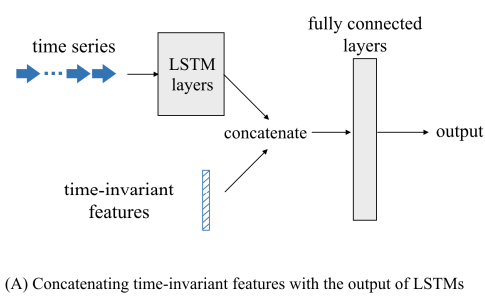

This approach is implemented in the following part:

In [ ]:
# Define name of features and separate them by categorical, numerical and daily values
vars_num = ['number_of_beds','no_of_bathrooms','no_of_receptions','land','new_build','build_year',
            'epc_exempt','virtual_visit','prof_photos','digitial_marketing_pack','can_have_board',
            'premium_advert_ordered','bundle_ordered','hosted_viewings','viewing_pack_ordered',
            'strike_market_share_percent','first_listed_price','population_in_area','population_density',
            'income_decile','populated_area','pop_area_with_gospace_access','pct_pop_area_with_gospace_access',
            'pct_pop_area_without_gospace_access','pop_without_gospace_access','average_demand_trend_6weeks',
            'avg_sales_quarter_3qts','avg_median_pricepaid_3qts',	'avg_price_3months','avg_hpi_index_3months',
            'avg_monthly_change_3months','avg_annual_change_3months','no_sim_ppts_ol',
            'avgweeks_inmarket_sim_ppts_ol','avgprice_sim_ppts_ol','medianprice_sim_ppts_ol',
            'no_sim_ppts_ol_stc','avgweeks_to_stc_sim_ppts_ol_stc','avgprice_sim_ppts_ol_stc',
            'medianprice_sim_ppts_ol_stc','no_sim_strike_ppts_ol','avgprice_sim_strike_ppts_ol', 
            'avg_offers_sim_strike_ppts_ol','avg_vr_sim_strike_ppts_ol','avg_vc_sim_strike_ppts_ol']

vars_cat = ['property_type','build_year_group','tenure_type','heating_type','double_glazing','parking_type','garden','council_tax_band','itv_region','urban_rural_category','county',
            'rural_ubran_classification_detail_lsoa','rural_urban_classification_detail_msoa','spatial_signature_type','chain_situation','strike_defined_channel','listing_pricetype',
            'gl_date_month']

daily_values_vars = ['year','month','day','days_since_live','vr_daily_cumsum','vc_daily_cumsum',
                     'price_change_percentage_daily','rm_summary_views_daily_cumsum','rm_detailed_views_daily_cumsum',
                     'premium_listing_daily','featured_property_daily',
                     'sim_ppts_ol_listed_daily_cumsum','sim_ppts_ol_stc_daily_cumsum',
                     'offers_recieved_daily_cumsum']

target = ['unique_offers_cut']

In [ ]:
# Merge two dataset
final_df_1 = pd.merge(df_properties_daily,df_properties_ap[['property_id']+vars_num + vars_cat + target], how="inner", on=['property_id'])
final_df_1.shape

(216678, 79)

In [ ]:
# Check for missing values in each feature
na_vars = [var for var in final_df_1.columns if final_df_1[var].isnull().sum() > 0]
print('Numerical features missing values report:')
print(final_df_1[na_vars].isnull().mean().sort_values(ascending=False))

Numerical features missing values report:
premium_listing_daily             0.109504
featured_property_daily           0.109504
rm_detailed_views_daily_cumsum    0.030571
rm_summary_views_daily_cumsum     0.030515
double_glazing                    0.009240
county                            0.002552
urban_rural_category              0.000485
strike_defined_channel            0.000291
price_change_percentage_daily     0.000032
avg_price_3months                 0.000032
avg_hpi_index_3months             0.000032
avg_monthly_change_3months        0.000032
avg_annual_change_3months         0.000032
parking_type                      0.000032
listing_pricetype                 0.000032
dtype: float64


In [ ]:
# Lets transform the dataset (which is in a pandas df, to a numpy array)
dataset_features = final_df_1.drop(['unique_offers_cut'],axis=1).to_numpy()

# Since each property has 7 rows, representing 7 days of being live, they will need to be group in a 3-d array in order to be splitted later on into train, validation and test data.
X = dataset_features.reshape(int(final_df_1.shape[0] / 7),7,final_df_1.shape[1]-1)

# Additionally, we will need the target variable, which is this case, it will be the total number of offers within 6 months
y = final_df_1[['property_id','unique_offers_cut']]
y.drop_duplicates(subset=['property_id'], inplace=True)
y = y['unique_offers_cut'].to_numpy()

In [ ]:
# Lets train test split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=14)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=14)

In [ ]:
# Since we are introducing new variables (where some have missing values), numerical and categorical, we will need to use additional transformations, 
# such as one-hot-encoding for categorical features, and imputation for missing values.
numeric_preprocessor = Pipeline(
        steps = [
            ('imputation_mean', KNNImputer()),
            ('scaler', RobustScaler())
        ]
    )

daily_values_preprocessor = Pipeline(
        steps = [
            ('imputation_mean', KNNImputer()),
            ('scaler', RobustScaler())
        ]
    )

categorical_preprocessor = Pipeline(
        steps = [
            ('imputation_mode', SimpleImputer(strategy='most_frequent')),
            ('ohe',OneHotEncoder(handle_unknown='ignore', sparse=False))
            
        ]
    )

preprocessor = ColumnTransformer([
                                  ('cat_preprocessor', categorical_preprocessor, vars_cat),
                                  ('num_preprocessor', numeric_preprocessor, vars_num),
                                  ('dv_preprocessor', daily_values_preprocessor, daily_values_vars)], 
                                 sparse_threshold= 0, remainder='passthrough')


In [ ]:
# In order to use ColumnTransformer, data needs to be in a 2-d shape, and our current data is in 3-d
X_train_df = pd.DataFrame(X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2]))
X_train_df.columns = final_df_1.columns[0:-1] # Just adding original column names (not really needed, just for reference)

#Using ColumnTransformer, and applying transformation to columns in dataset
train_df_encoded = preprocessor.fit_transform(X_train_df)
X_train_df_encoded = pd.DataFrame(train_df_encoded)

# Following 4 lines optional
encoded_categorical_columns_names = preprocessor.named_transformers_['cat_preprocessor'].named_steps['ohe'].get_feature_names_out(vars_cat)
numerical_columns_names = preprocessor.named_transformers_['num_preprocessor'].named_steps['scaler'].get_feature_names_out(vars_num)
dv_columns_names = preprocessor.named_transformers_['dv_preprocessor'].named_steps['scaler'].get_feature_names_out(daily_values_vars)
X_train_df_encoded.columns = [*encoded_categorical_columns_names,*numerical_columns_names,*dv_columns_names,*['property_id']]

# Separating pre-go live data and post go live data
# Post go live data
X_train_df_encoded_daily_values = X_train_df_encoded[daily_values_vars]

X_train_df_encoded_daily_values = X_train_df_encoded_daily_values.to_numpy()
X_train_df_encoded_daily_values = X_train_df_encoded_daily_values.reshape(int(X_train_df_encoded_daily_values.shape[0] / 7), 7, X_train_df_encoded_daily_values.shape[1]) # Reshaping data from 2-d to 3-d
print(X_train_df_encoded_daily_values.shape)
# Pre go live data
X_train_df_encoded_pre_go_live = X_train_df_encoded[[*encoded_categorical_columns_names,*numerical_columns_names] + ['property_id']]
X_train_df_encoded_pre_go_live.drop_duplicates(subset=['property_id'], inplace=True)
X_train_df_encoded_pre_go_live.drop(['property_id'], axis=1, inplace=True)

X_train_df_encoded_pre_go_live = X_train_df_encoded_pre_go_live.to_numpy()
print(X_train_df_encoded_pre_go_live.shape)

(23679, 7, 14)
(23679, 263)


In [ ]:
# Doing same above process but with validation data and using fitted scaler to only transform data
X_val_df = pd.DataFrame(X_val.reshape(X_val.shape[0]*X_val.shape[1], X_val.shape[2]))
X_val_df.columns = final_df_1.columns[0:-1]
X_val_df_encoded = pd.DataFrame(preprocessor.transform(X_val_df))

# Optional
encoded_categorical_columns_names = preprocessor.named_transformers_['cat_preprocessor'].named_steps['ohe'].get_feature_names_out(vars_cat)
numerical_columns_names = preprocessor.named_transformers_['num_preprocessor'].named_steps['scaler'].get_feature_names_out(vars_num)
dv_columns_names = preprocessor.named_transformers_['dv_preprocessor'].named_steps['scaler'].get_feature_names_out(daily_values_vars)
X_val_df_encoded.columns = [*encoded_categorical_columns_names,*numerical_columns_names,*dv_columns_names,*['property_id']]

# Separating pre-go live data and post go live data
# Post go live data
X_val_df_encoded_daily_values = X_val_df_encoded[daily_values_vars]

X_val_df_encoded_daily_values = X_val_df_encoded_daily_values.to_numpy()
X_val_df_encoded_daily_values = X_val_df_encoded_daily_values.reshape(int(X_val_df_encoded_daily_values.shape[0] / 7), 7, X_val_df_encoded_daily_values.shape[1]) # Reshaping data from 2-d to 3-d
print(X_val_df_encoded_daily_values.shape)

# Pre go live data
X_val_df_encoded_pre_go_live = X_val_df_encoded[[*encoded_categorical_columns_names,*numerical_columns_names] + ['property_id']]
X_val_df_encoded_pre_go_live.drop_duplicates(subset=['property_id'], inplace=True)
X_val_df_encoded_pre_go_live.drop(['property_id'], axis=1, inplace=True)

X_val_df_encoded_pre_go_live = X_val_df_encoded_pre_go_live.to_numpy()
print(X_val_df_encoded_pre_go_live.shape)

(4179, 7, 14)
(4179, 263)


In [ ]:
# At some previous point, the data type of the values changed, changing to float32 so is compatible with model
X_train_df_encoded_daily_values = np.asarray(X_train_df_encoded_daily_values).astype('float32')
X_val_df_encoded_daily_values = np.asarray(X_val_df_encoded_daily_values).astype('float32')

X_train_df_encoded_pre_go_live = np.asarray(X_train_df_encoded_pre_go_live).astype('float32')
X_val_df_encoded_pre_go_live = np.asarray(X_val_df_encoded_pre_go_live).astype('float32')

In [ ]:
# Define inputs of the model
post_go_live_input = keras.Input(shape=(7,14), name="lstm_input")
pre_go_live_input = keras.Input(shape=(263,), name="pre-go-live")

# Define layers for each type of input - LSTM for lstm input and FCL for pre-go-live input 
lstm_output = LSTM(50,activation='relu')(post_go_live_input)

# Merge all available features into a single large vector via concatenation
x = keras.layers.concatenate([lstm_output, pre_go_live_input])

fc_layer_4 = keras.layers.Dense(150, name="fc_4", activation='relu')(x)
# Stick a department classifier on top of the features
pred = keras.layers.Dense(1, name="prediction_layer")(fc_layer_4)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[post_go_live_input, pre_go_live_input],
    outputs=[pred]
)

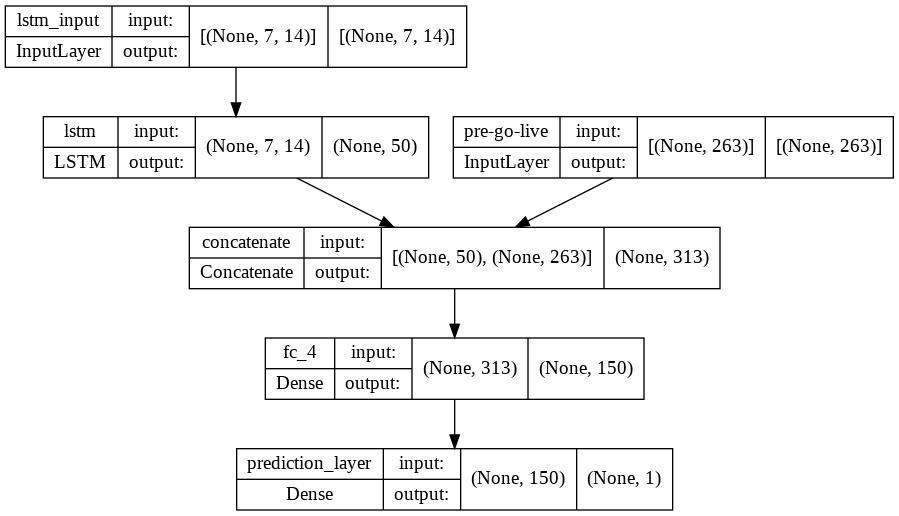

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model.compile(optimizer = tf.keras.optimizers.Adam(), loss='mse')
# fit model
model.fit([X_train_df_encoded_daily_values,X_train_df_encoded_pre_go_live], y_train, epochs=400, callbacks = [callback], 
          validation_data = ([X_val_df_encoded_daily_values,X_val_df_encoded_pre_go_live], y_val),verbose=1)

Epoch 1/400
740/740 [==============================] - 8s 9ms/step - loss: 2.8636 - val_loss: 2.2770
Epoch 2/400
740/740 [==============================] - 6s 8ms/step - loss: 2.4781 - val_loss: 2.3022
Epoch 3/400
740/740 [==============================] - 6s 8ms/step - loss: 2.5264 - val_loss: 2.2763
Epoch 4/400
740/740 [==============================] - 6s 8ms/step - loss: 2.3434 - val_loss: 2.4023
Epoch 5/400
740/740 [==============================] - 6s 8ms/step - loss: 2.2903 - val_loss: 2.2785
Epoch 6/400
740/740 [==============================] - 6s 8ms/step - loss: 2.2688 - val_loss: 2.2502
Epoch 7/400
740/740 [==============================] - 6s 8ms/step - loss: 2.2186 - val_loss: 2.2489
Epoch 8/400
740/740 [==============================] - 6s 8ms/step - loss: 2.2625 - val_loss: 2.2713
Epoch 9/400
740/740 [==============================] - 6s 8ms/step - loss: 2.1490 - val_loss: 2.3384
Epoch 10/400
740/740 [==============================] - 7s 9ms/step - loss: 2.0897 - val_lo

In [ ]:
# Preparing test data
X_test_df = pd.DataFrame(X_test.reshape(X_test.shape[0]*X_test.shape[1], X_test.shape[2]))
X_test_df.columns = final_df_1.columns[0:-1]
X_test_df_encoded = pd.DataFrame(preprocessor.transform(X_test_df))

# Optional
encoded_categorical_columns_names = preprocessor.named_transformers_['cat_preprocessor'].named_steps['ohe'].get_feature_names_out(vars_cat)
numerical_columns_names = preprocessor.named_transformers_['num_preprocessor'].named_steps['scaler'].get_feature_names_out(vars_num)
dv_columns_names = preprocessor.named_transformers_['dv_preprocessor'].named_steps['scaler'].get_feature_names_out(daily_values_vars)
X_test_df_encoded.columns = [*encoded_categorical_columns_names,*numerical_columns_names,*dv_columns_names,*['property_id']]

# Separating pre-go live data and post go live data
# Post go live data
X_test_df_encoded_daily_values = X_test_df_encoded[daily_values_vars]

X_test_df_encoded_daily_values = X_test_df_encoded_daily_values.to_numpy()
X_test_df_encoded_daily_values = X_test_df_encoded_daily_values.reshape(int(X_test_df_encoded_daily_values.shape[0] / 7), 7, X_test_df_encoded_daily_values.shape[1]) # Reshaping data from 2-d to 3-d
print(X_test_df_encoded_daily_values.shape)

# Pre go live data
X_test_df_encoded_pre_go_live = X_test_df_encoded[[*encoded_categorical_columns_names,*numerical_columns_names] + ['property_id']]
X_test_df_encoded_pre_go_live.drop_duplicates(subset=['property_id'], inplace=True)
X_test_df_encoded_pre_go_live.drop(['property_id'], axis=1, inplace=True)

X_test_df_encoded_pre_go_live = X_test_df_encoded_pre_go_live.to_numpy()
print(X_test_df_encoded_pre_go_live.shape)

(3096, 7, 14)
(3096, 263)


In [ ]:
X_test_df_encoded_daily_values = np.asarray(X_test_df_encoded_daily_values).astype('float32')
X_test_df_encoded_pre_go_live = np.asarray(X_test_df_encoded_pre_go_live).astype('float32')

In [ ]:
# Getting predictions
preds = model.predict([X_test_df_encoded_daily_values,X_test_df_encoded_pre_go_live])

# Evaluating results
print("MAE: %s" % mean_absolute_error(y_test, preds))
print("MSE: %s" % mean_squared_error(y_test, preds))
print("RMSE: %s" % mean_squared_error(y_test, preds, squared=False))
print("R2: %s" % r2_score(y_test, preds))

MAE: 1.0646584467584561
MSE: 2.5658957311685278
RMSE: 1.6018413564296958
R2: 0.5177797714076688


It appears that using this particular model structure, and combination of outputs does not improve results and they are lower than only using post go live features and pre-go live features (duplicated) with post go live features.

It might mean that following this approach does not help, but more research and experimentation needs to be done in the model structure.

## Using daily values + property level data (not duplicated)

Initialize hidden states of LSTM

In [ ]:
# Define name of features and separate them by categorical, numerical and daily values
vars_num = ['number_of_beds','no_of_bathrooms','no_of_receptions','land','new_build','build_year',
            'epc_exempt','virtual_visit','prof_photos','digitial_marketing_pack','can_have_board',
            'premium_advert_ordered','bundle_ordered','hosted_viewings','viewing_pack_ordered',
            'strike_market_share_percent','first_listed_price','population_in_area','population_density',
            'income_decile','populated_area','pop_area_with_gospace_access','pct_pop_area_with_gospace_access',
            'pct_pop_area_without_gospace_access','pop_without_gospace_access','average_demand_trend_6weeks',
            'avg_sales_quarter_3qts','avg_median_pricepaid_3qts',	'avg_price_3months','avg_hpi_index_3months',
            'avg_monthly_change_3months','avg_annual_change_3months','no_sim_ppts_ol',
            'avgweeks_inmarket_sim_ppts_ol','avgprice_sim_ppts_ol','medianprice_sim_ppts_ol',
            'no_sim_ppts_ol_stc','avgweeks_to_stc_sim_ppts_ol_stc','avgprice_sim_ppts_ol_stc',
            'medianprice_sim_ppts_ol_stc','no_sim_strike_ppts_ol','avgprice_sim_strike_ppts_ol', 
            'avg_offers_sim_strike_ppts_ol','avg_vr_sim_strike_ppts_ol','avg_vc_sim_strike_ppts_ol']

vars_cat = ['property_type','build_year_group','tenure_type','heating_type','double_glazing','parking_type','garden','council_tax_band','itv_region','urban_rural_category','county',
            'rural_ubran_classification_detail_lsoa','rural_urban_classification_detail_msoa','spatial_signature_type','chain_situation','strike_defined_channel','listing_pricetype',
            'gl_date_month']

daily_values_vars = ['year','month','day','days_since_live','vr_daily_cumsum','vc_daily_cumsum',
                     'price_change_percentage_daily','rm_summary_views_daily_cumsum','rm_detailed_views_daily_cumsum',
                     'premium_listing_daily','featured_property_daily',
                     'sim_ppts_ol_listed_daily_cumsum','sim_ppts_ol_stc_daily_cumsum',
                     'offers_recieved_daily_cumsum']

target = ['unique_offers_cut']

In [ ]:
# Merge two dataset
final_df_1 = pd.merge(df_properties_daily,df_properties_ap[['property_id']+vars_num + vars_cat + target], how="inner", on=['property_id'])
final_df_1.shape

(219688, 79)

In [ ]:
# Lets transform the dataset (which is in a pandas df, to a numpy array)
dataset_features = final_df_1.drop(['unique_offers_cut'],axis=1).to_numpy()

# Since each property has 7 rows, representing 7 days of being live, they will need to be group in a 3-d array in order to be splitted later on into train, validation and test data.
X = dataset_features.reshape(int(final_df_1.shape[0] / 7),7,final_df_1.shape[1]-1)

# Additionally, we will need the target variable, which is this case, it will be the total number of offers within 6 months
y = final_df_1[['property_id','unique_offers_cut']]
y.drop_duplicates(subset=['property_id'], inplace=True)
y = y['unique_offers_cut'].to_numpy()

In [ ]:
# Lets train test split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=14)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=14)

In [ ]:
# Since we are introducing new variables (where some have missing values), numerical and categorical, we will need to use additional transformations, 
# such as one-hot-encoding for categorical features, and imputation for missing values.
numeric_preprocessor = Pipeline(
        steps = [
            ('imputation_mean', SimpleImputer(strategy='mean')),
            ('scaler', RobustScaler())
        ]
    )

daily_values_preprocessor = Pipeline(
        steps = [
            ('imputation_mean', SimpleImputer(strategy='mean')),
            ('scaler', RobustScaler())
        ]
    )

categorical_preprocessor = Pipeline(
        steps = [
            ('imputation_mode', SimpleImputer(strategy='most_frequent')),
            ('ohe',OneHotEncoder(handle_unknown='ignore', sparse=False))
            
        ]
    )

preprocessor = ColumnTransformer([
                                  ('cat_preprocessor', categorical_preprocessor, vars_cat),
                                  ('num_preprocessor', numeric_preprocessor, vars_num),
                                  ('dv_preprocessor', daily_values_preprocessor, daily_values_vars)], 
                                 sparse_threshold= 0, remainder='passthrough')


In [ ]:
# In order to use ColumnTransformer, data needs to be in a 2-d shape, and our current data is in 3-d
X_train_df = pd.DataFrame(X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2]))
X_train_df.columns = final_df_1.columns[0:-1] # Just adding original column names (not really needed, just for reference)

#Using ColumnTransformer, and applying transformation to columns in dataset
train_df_encoded = preprocessor.fit_transform(X_train_df)
X_train_df_encoded = pd.DataFrame(train_df_encoded)

# Following 4 lines optional
encoded_categorical_columns_names = preprocessor.named_transformers_['cat_preprocessor'].named_steps['ohe'].get_feature_names_out(vars_cat)
numerical_columns_names = preprocessor.named_transformers_['num_preprocessor'].named_steps['scaler'].get_feature_names_out(vars_num)
dv_columns_names = preprocessor.named_transformers_['dv_preprocessor'].named_steps['scaler'].get_feature_names_out(daily_values_vars)
X_train_df_encoded.columns = [*encoded_categorical_columns_names,*numerical_columns_names,*dv_columns_names,*['property_id']]

# Separating pre-go live data and post go live data
# Post go live data
X_train_df_encoded_daily_values = X_train_df_encoded[daily_values_vars]

X_train_df_encoded_daily_values = X_train_df_encoded_daily_values.to_numpy()
X_train_df_encoded_daily_values = X_train_df_encoded_daily_values.reshape(int(X_train_df_encoded_daily_values.shape[0] / 7), 7, X_train_df_encoded_daily_values.shape[1]) # Reshaping data from 2-d to 3-d
print(X_train_df_encoded_daily_values.shape)
# Pre go live data
X_train_df_encoded_pre_go_live = X_train_df_encoded[[*encoded_categorical_columns_names,*numerical_columns_names] + ['property_id']]
X_train_df_encoded_pre_go_live.drop_duplicates(subset=['property_id'], inplace=True)
X_train_df_encoded_pre_go_live.drop(['property_id'], axis=1, inplace=True)

X_train_df_encoded_pre_go_live = X_train_df_encoded_pre_go_live.to_numpy()
print(X_train_df_encoded_pre_go_live.shape)

(24008, 7, 14)
(24008, 266)


In [ ]:
# Doing same above process but with validation data and using fitted scaler to only transform data
X_val_df = pd.DataFrame(X_val.reshape(X_val.shape[0]*X_val.shape[1], X_val.shape[2]))
X_val_df.columns = final_df_1.columns[0:-1]
X_val_df_encoded = pd.DataFrame(preprocessor.transform(X_val_df))

# Optional
encoded_categorical_columns_names = preprocessor.named_transformers_['cat_preprocessor'].named_steps['ohe'].get_feature_names_out(vars_cat)
numerical_columns_names = preprocessor.named_transformers_['num_preprocessor'].named_steps['scaler'].get_feature_names_out(vars_num)
dv_columns_names = preprocessor.named_transformers_['dv_preprocessor'].named_steps['scaler'].get_feature_names_out(daily_values_vars)
X_val_df_encoded.columns = [*encoded_categorical_columns_names,*numerical_columns_names,*dv_columns_names,*['property_id']]

# Separating pre-go live data and post go live data
# Post go live data
X_val_df_encoded_daily_values = X_val_df_encoded[daily_values_vars]

X_val_df_encoded_daily_values = X_val_df_encoded_daily_values.to_numpy()
X_val_df_encoded_daily_values = X_val_df_encoded_daily_values.reshape(int(X_val_df_encoded_daily_values.shape[0] / 7), 7, X_val_df_encoded_daily_values.shape[1]) # Reshaping data from 2-d to 3-d
print(X_val_df_encoded_daily_values.shape)

# Pre go live data
X_val_df_encoded_pre_go_live = X_val_df_encoded[[*encoded_categorical_columns_names,*numerical_columns_names] + ['property_id']]
X_val_df_encoded_pre_go_live.drop_duplicates(subset=['property_id'], inplace=True)
X_val_df_encoded_pre_go_live.drop(['property_id'], axis=1, inplace=True)
X_val_df_encoded_pre_go_live = X_val_df_encoded_pre_go_live.to_numpy()
print(X_val_df_encoded_pre_go_live.shape)

(4237, 7, 14)
(4237, 266)


In [ ]:
# At some previous point, the data type of the values changed, changing to float32 so is compatible with model
X_train_df_encoded_daily_values = np.asarray(X_train_df_encoded_daily_values).astype('float32')
X_val_df_encoded_daily_values = np.asarray(X_val_df_encoded_daily_values).astype('float32')

X_train_df_encoded_pre_go_live = np.asarray(X_train_df_encoded_pre_go_live).astype('float32')
X_val_df_encoded_pre_go_live = np.asarray(X_val_df_encoded_pre_go_live).astype('float32')

In [ ]:
# Define inputs of the model
post_go_live_input = keras.Input(shape=(7,14), name="post_go_live")
pre_go_live_input_hidden_state = keras.Input(shape=(266,), name="pre-go-live_hidden")


# Define layers for each type of input - LSTM for lstm input and FCL for pre-go-live input
fc_features_layer1 = keras.layers.Dense(150, activation='relu')(pre_go_live_input_hidden_state)
fc_features_layer3 = keras.layers.Dense(50, activation='relu')(fc_features_layer1)
lstm_features = LSTM(50,activation='relu')

outputs = lstm_features(post_go_live_input, initial_state=[fc_features_layer3,tf.zeros_like(fc_features_layer3)])

pred = keras.layers.Dense(1, name="prediction_layer")(outputs)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[post_go_live_input, pre_go_live_input_hidden_state],
    outputs=[pred]
)

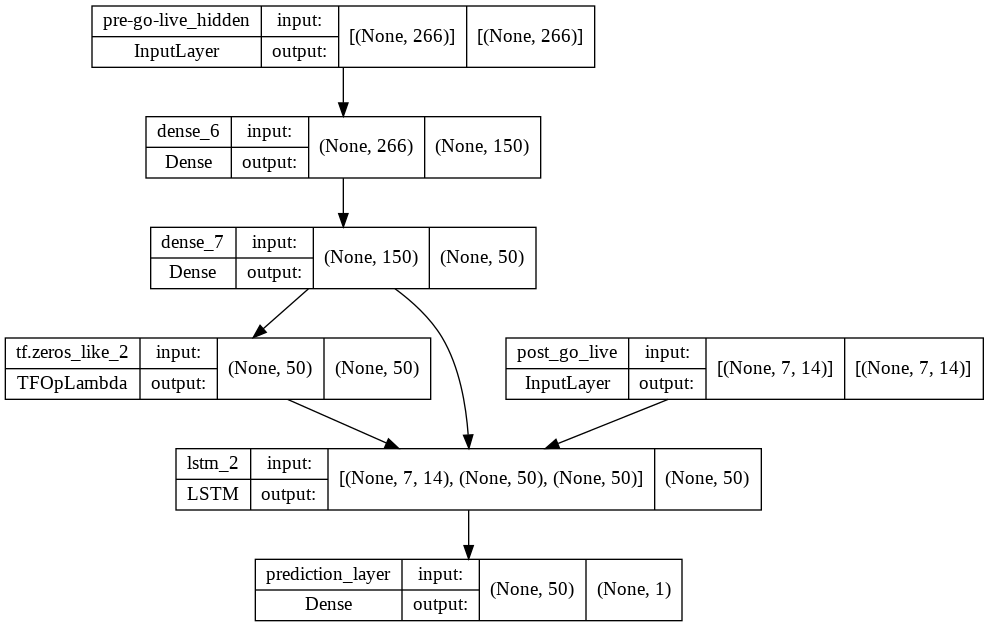

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model.compile(optimizer = tf.keras.optimizers.Adam(), loss='mse')
# fit model
model.fit([X_train_df_encoded_daily_values,X_train_df_encoded_pre_go_live], y_train, epochs=400, callbacks = [callback], 
          validation_data = ([X_val_df_encoded_daily_values,X_val_df_encoded_pre_go_live], y_val),verbose=1)

Epoch 1/400
751/751 [==============================] - 22s 19ms/step - loss: 2.7942 - val_loss: 2.4271
Epoch 2/400
751/751 [==============================] - 11s 14ms/step - loss: 2.4907 - val_loss: 2.3696
Epoch 3/400
751/751 [==============================] - 11s 14ms/step - loss: 2.4155 - val_loss: 2.3181
Epoch 4/400
751/751 [==============================] - 11s 14ms/step - loss: 2.3590 - val_loss: 2.3172
Epoch 5/400
751/751 [==============================] - 11s 14ms/step - loss: 2.3129 - val_loss: 2.3618
Epoch 6/400
751/751 [==============================] - 11s 14ms/step - loss: 2.1827 - val_loss: 2.3318
Epoch 7/400
751/751 [==============================] - 11s 14ms/step - loss: 2.1164 - val_loss: 2.3595
Epoch 8/400
751/751 [==============================] - 11s 14ms/step - loss: 1.9847 - val_loss: 2.8582
Epoch 9/400
751/751 [==============================] - 11s 14ms/step - loss: 1.9260 - val_loss: 2.4190
Epoch 10/400
751/751 [==============================] - 12s 16ms/step - l

In [ ]:
# Preparing test data
X_test_df = pd.DataFrame(X_test.reshape(X_test.shape[0]*X_test.shape[1], X_test.shape[2]))
X_test_df.columns = final_df_1.columns[0:-1]
X_test_df_encoded = pd.DataFrame(preprocessor.transform(X_test_df))

# Optional
encoded_categorical_columns_names = preprocessor.named_transformers_['cat_preprocessor'].named_steps['ohe'].get_feature_names_out(vars_cat)
numerical_columns_names = preprocessor.named_transformers_['num_preprocessor'].named_steps['scaler'].get_feature_names_out(vars_num)
dv_columns_names = preprocessor.named_transformers_['dv_preprocessor'].named_steps['scaler'].get_feature_names_out(daily_values_vars)
X_test_df_encoded.columns = [*encoded_categorical_columns_names,*numerical_columns_names,*dv_columns_names,*['property_id']]

# Separating pre-go live data and post go live data
# Post go live data
X_test_df_encoded_daily_values = X_test_df_encoded[daily_values_vars]

X_test_df_encoded_daily_values = X_test_df_encoded_daily_values.to_numpy()
X_test_df_encoded_daily_values = X_test_df_encoded_daily_values.reshape(int(X_test_df_encoded_daily_values.shape[0] / 7), 7, X_test_df_encoded_daily_values.shape[1]) # Reshaping data from 2-d to 3-d
print(X_test_df_encoded_daily_values.shape)

# Pre go live data
X_test_df_encoded_pre_go_live = X_test_df_encoded[[*encoded_categorical_columns_names,*numerical_columns_names] + ['property_id']]
X_test_df_encoded_pre_go_live.drop_duplicates(subset=['property_id'], inplace=True)
X_test_df_encoded_pre_go_live.drop(['property_id'], axis=1, inplace=True)


X_test_df_encoded_pre_go_live = X_test_df_encoded_pre_go_live.to_numpy()
print(X_test_df_encoded_pre_go_live.shape)


(3139, 7, 14)
(3139, 266)


In [ ]:
X_test_df_encoded_daily_values = np.asarray(X_test_df_encoded_daily_values).astype('float32')
X_test_df_encoded_pre_go_live = np.asarray(X_test_df_encoded_pre_go_live).astype('float32')

In [ ]:
# Getting predictions
preds = model.predict([X_test_df_encoded_daily_values,X_test_df_encoded_pre_go_live])

# Evaluating results
print("MAE: %s" % mean_absolute_error(y_test, preds))
print("MSE: %s" % mean_squared_error(y_test, preds))
print("RMSE: %s" % mean_squared_error(y_test, preds, squared=False))
print("R2: %s" % r2_score(y_test, preds))

MAE: 1.0443594234171625
MSE: 2.7002247710871314
RMSE: 1.6432360667558181
R2: 0.5423678789906694


## Using Conditional RNN library

This [python library](https://github.com/philipperemy/cond_rnn) uses a similar approach/concept to what has been implemented before, which uses additional input (pre go live features) to modify the initial hidden state of an LSTM/RNN/GRU model.

This additional input, it is referred to conditions in this library, and works in the following way:

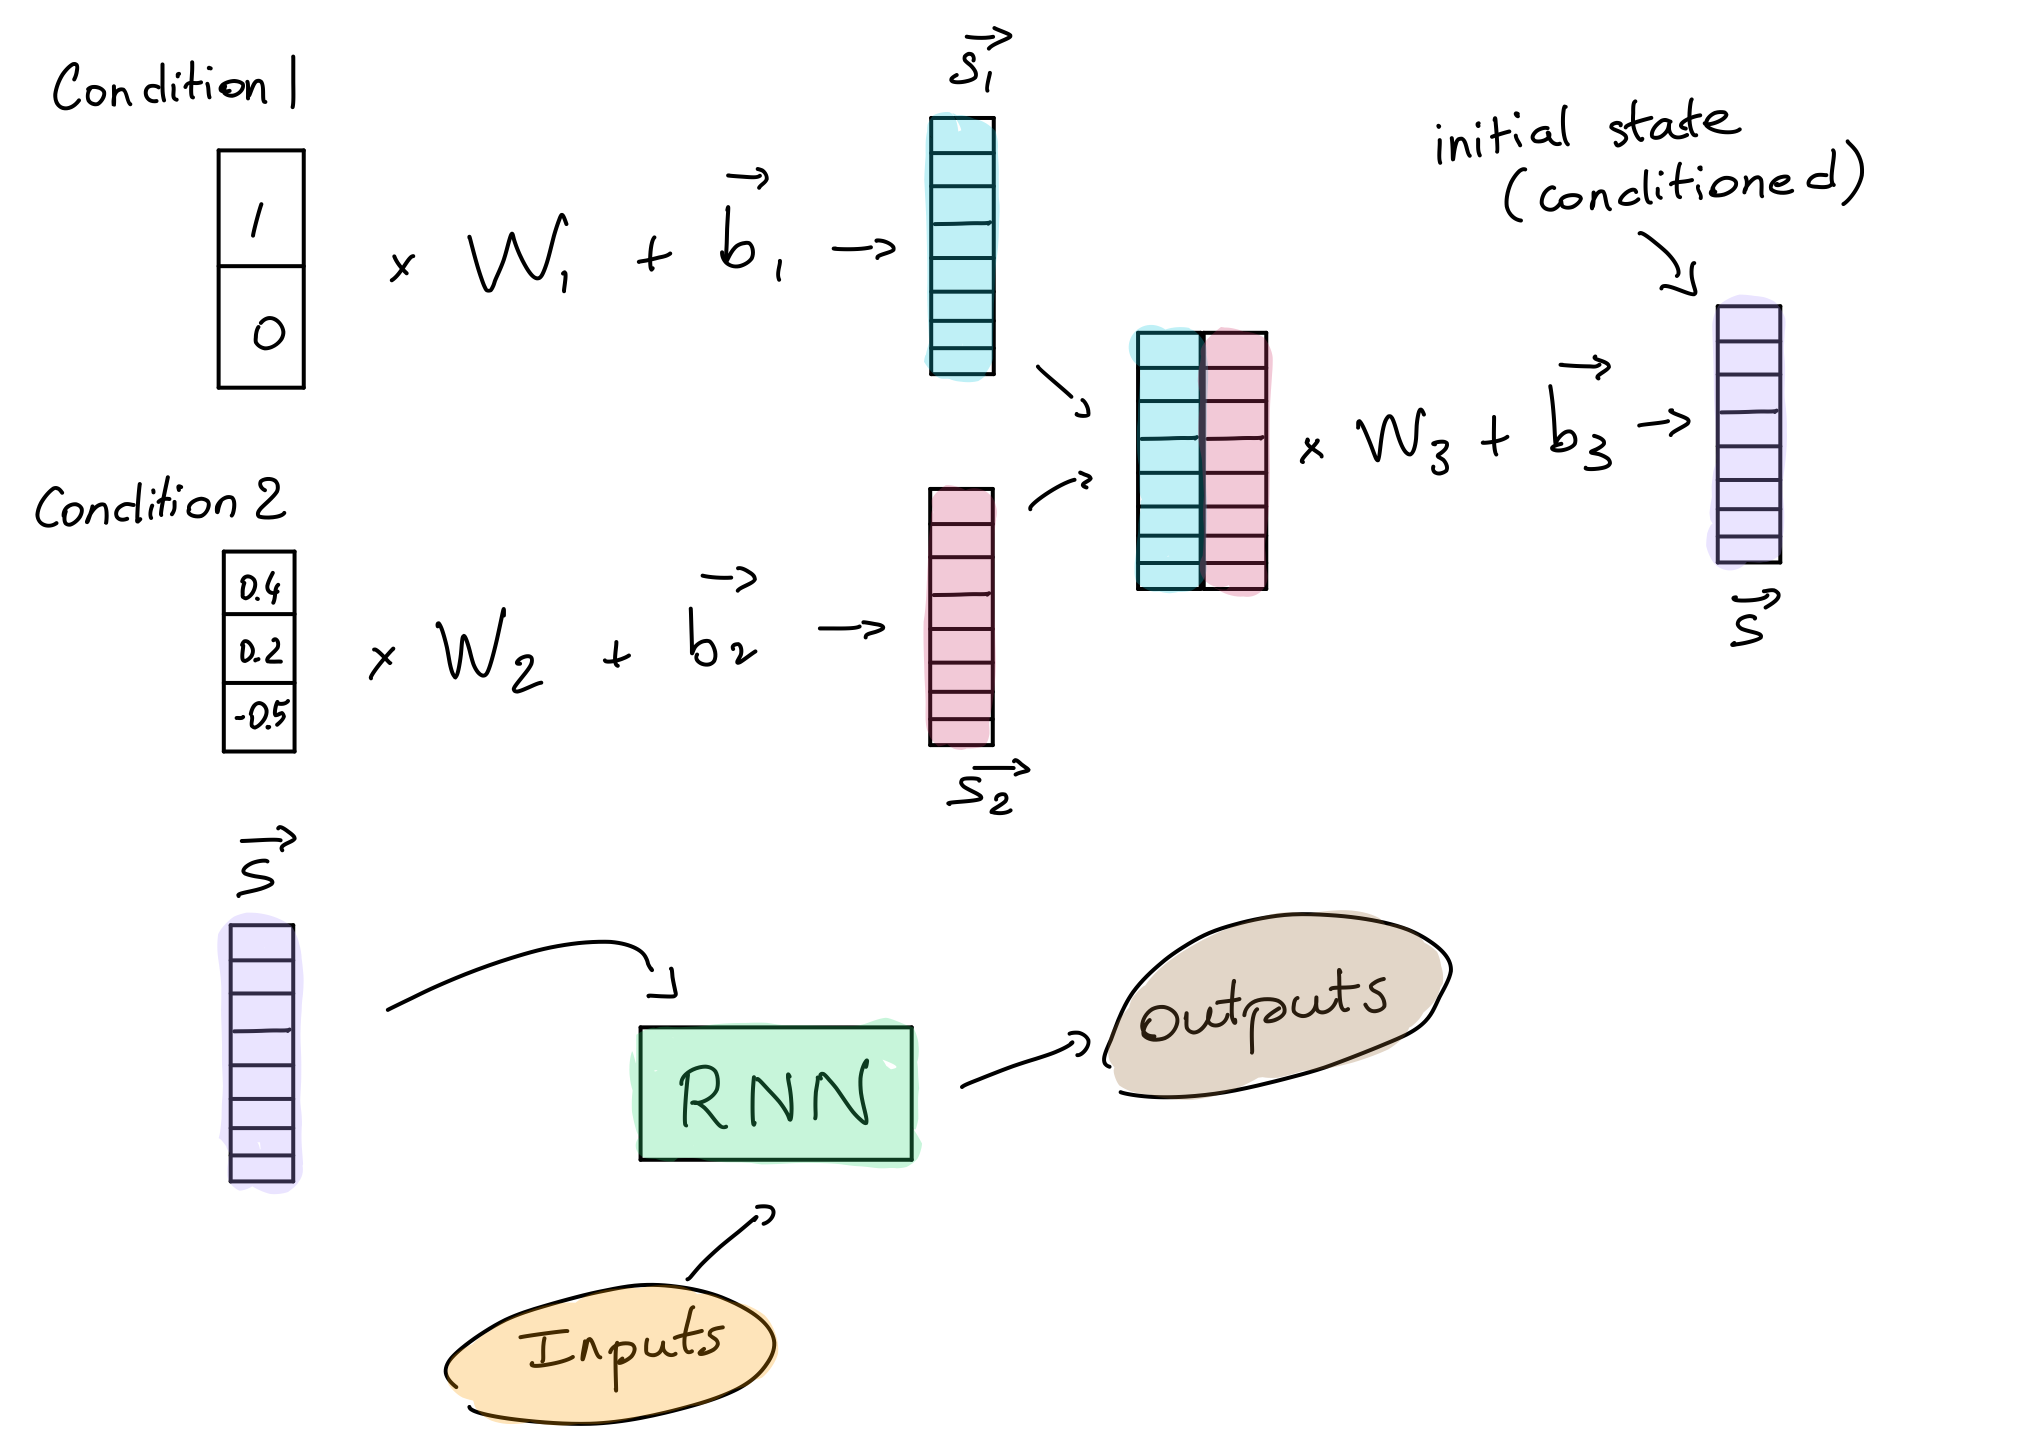

The additional input can be separated into multiple conditios, based on the type of input (numerical, categorical, etc).





And each condition will have its own subsequent layer that will be merged into another layer that combines the conditions and then reshaped into the intial state (conditioned).

The way to distinguish conditions might be something of domain knowledge and less of a defined technique. For our case, it might be something of the following:

1. Separate categorical and numerical features.
2. Identify both property level data, market data, similar strike properties data for both type of data from previous step.
3. Separate and create conditions based on previous separation.

This way, each type of data (numerical and categorical) and type of information will have its own initial section that calculate its own weights, and have its own bias.

# Using Strike data (up to 21 days) and evaluating each day error using duplicate approach

This approach copies the pre go live features and duplicates for every day considered after a property has gone live.





## Functions

In [ ]:
def create_transformer(vars_cat, vars_num, daily_values_vars):

  numeric_preprocessor = Pipeline(
        steps = [
            ('imputation_mean', SimpleImputer(strategy='mean')),
            ('scaler', RobustScaler())
        ]
    )
  daily_values_preprocessor = Pipeline(
          steps = [
              ('imputation_mean', SimpleImputer(strategy='mean')),
              ('scaler', RobustScaler())
          ]
      )
  categorical_preprocessor = Pipeline(
          steps = [
              ('imputation_mode', SimpleImputer(strategy='most_frequent')),
              ('ohe',OneHotEncoder(handle_unknown='ignore', sparse=False))
              
          ]
      )
  preprocessor = ColumnTransformer([
                                    ('cat_preprocessor', categorical_preprocessor, vars_cat),
                                    ('num_preprocessor', numeric_preprocessor, vars_num),
                                    ('dv_preprocessor', daily_values_preprocessor, daily_values_vars)], 
                                  sparse_threshold= 0, remainder='passthrough')
  
  return preprocessor


def preprocessor_fit_transform(preprocessor, X_train, temp_df_1, days):

    # In order to use an scaler/transformer, data needs to be in a 2-d shape, and our current data is in 3-d
    X_train_df = pd.DataFrame(X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2]))
    X_train_df.columns = temp_df_1.columns[0:-1] # Just adding original column names (not really needed, just for reference)

    # Using transformer to fit and transform training data
    train_df_encoded = preprocessor.fit_transform(X_train_df)

    X_train_df_encoded = pd.DataFrame(train_df_encoded)

    # Following 4 lines are optional
    encoded_categorical_columns_names = preprocessor.named_transformers_['cat_preprocessor'].named_steps['ohe'].get_feature_names_out(vars_cat)
    numerical_columns_names = preprocessor.named_transformers_['num_preprocessor'].named_steps['scaler'].get_feature_names_out(vars_num)
    dv_columns_names = preprocessor.named_transformers_['dv_preprocessor'].named_steps['scaler'].get_feature_names_out(daily_values_vars)
    X_train_df_encoded.columns = [*encoded_categorical_columns_names,*numerical_columns_names,*dv_columns_names]

    # Reshaping data into 3-d shape
    X_train = X_train_df_encoded.to_numpy()
    X_train = X_train.reshape(int(X_train.shape[0] / (days + 1)), days + 1, X_train.shape[1]) # Reshaping data from 2-d to 3-d

    return preprocessor, X_train

def preprocessor_transform(preprocessor, X_val, temp_df_1, days):

    # Doing same above process but with validation data and using fitted scaler to only transform data
    X_val_df = pd.DataFrame(X_val.reshape(X_val.shape[0]*X_val.shape[1], X_val.shape[2]))
    X_val_df.columns = temp_df_1.columns[0:-1]
    X_val_df_encoded = pd.DataFrame(preprocessor.transform(X_val_df))

    # Optional
    encoded_categorical_columns_names = preprocessor.named_transformers_['cat_preprocessor'].named_steps['ohe'].get_feature_names_out(vars_cat)
    numerical_columns_names = preprocessor.named_transformers_['num_preprocessor'].named_steps['scaler'].get_feature_names_out(vars_num)
    dv_columns_names = preprocessor.named_transformers_['dv_preprocessor'].named_steps['scaler'].get_feature_names_out(daily_values_vars)
    X_val_df_encoded.columns = [*encoded_categorical_columns_names,*numerical_columns_names,*dv_columns_names]

    # Reshaping data into 3-d shape
    X_val = X_val_df_encoded.to_numpy()
    X_val = X_val.reshape(int(X_val.shape[0] / (days + 1)), days + 1 , X_val.shape[1])

    return X_val


def create_lstm_model(input_shape, n_units = 50, optimizer = tf.keras.optimizers.Adam()):

    """

    Create a lstm model (with one layer) and with n_units (based on user input) that receives
    an user predifined input shape and returns one single output, and uses mean_squared_error as loss function

    By default, uses Adam optimizer (with default values), but different optimizer can be given.

  """

    # Defining LSTM model
    model = Sequential()
    model.add(LSTM(n_units, activation='relu', input_shape = input_shape)) # Input shape is n_timesteps, n_features
    model.add(Dense(1))
    model.compile(optimizer = optimizer, loss='mse')

    return model

def create_rnn_model(input_shape, n_units=50, optimizer = tf.keras.optimizers.Adam()):

    model = Sequential()
    model.add(keras.layers.SimpleRNN(n_units, activation='relu', input_shape = input_shape))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    return model

# def create_cnn_model(input_shape, optimizer = tf.keras.optimizers.Adam()):

#     if input_shape[0] == 1:
#       kernel_size = 1
#     else:
#       kernel_size = int(input_shape[0] - 1)
#     model = Sequential()
#     model.add(keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu', input_shape = input_shape))
#     model.add(keras.layers.MaxPooling1D(pool_size=1))
#     model.add(keras.layers.Flatten())
#     model.add(Dense(100, activation='relu'))
#     model.add(Dense(50, activation='relu'))
#     model.add(Dense(1))
#     model.compile(optimizer=optimizer, loss='mse')

#     return model


def train_model(model, X_train, y_train, X_val, y_val, verbose=0):

    # EarlyStopping callback to stop training if validation loss does not decrease after certain # of epochs
    callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    # fit model and save train and val loss at each epoch for plotting
    history = model.fit(X_train, y_train, epochs=100, verbose=verbose, validation_data=(X_val, y_val), callbacks = [callback])

    return history, model

def plot_history(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model MSE')
    plt.ylabel('MSE Error')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

def evaluate_model(model, X_test, y_test):

    # Getting predictions and evaluation for LSTM
    preds = model.predict(X_test)

    # Evaluating results
    mae = mean_absolute_error(y_test, preds)
    print("MAE: %s" %mae )
    mse = mean_squared_error(y_test, preds)
    print("MSE: %s" % mse)
    rmse = mean_squared_error(y_test, preds, squared=False)
    print("RMSE: %s" %rmse)
    r2 = r2_score(y_test, preds)
    print("R2: %s" % r2)

    return mae, mse, rmse, r2

## Data Preparation

This step consists on just preprocessing the property level data and offers of properties, such as filtering offers that are not be considered, replacing some missing values (those that can be replaced beforehand), cleaning some columns from input errors, etc.

In [ ]:
# Load property level data (contains info such as number_of_beds, etc)
df_properties_main = pd.read_csv(r"/content/agg_data_7days.csv")
df_properties_main.drop_duplicates(subset=['property_id'], inplace=True)
df_properties_main.shape
# Load post go live features/values for up to 7 days
df_properties_daily = pd.read_csv(r"/content/daily_values_21days.csv")
df_properties_daily.shape


## Preprocessing dataset with property level data
# Copy dataframe and change date features to correct format
df_properties = df_properties_main
df_properties['gl_date'] = pd.to_datetime(df_properties['gl_date'])
df_properties['gl_date_year'] = pd.DatetimeIndex(df_properties['gl_date']).year
df_properties['gl_date_month'] = df_properties['gl_date'].dt.month_name()
df_properties['cc_date'] = pd.to_datetime(df_properties['cc_date'])
# Drop epc_expire_date feature, this might be used later on, but need to analyze the impact of it, since this can be a factor for a property 
# to be off market.
df_properties.drop(labels=['epc_expiry_date'], axis=1,inplace=True)

# Remove rows with a higher and lower first listed price
# This might be useful for removing higher first listed prices, since the distribution is skewed to the right.
df_properties = df_properties[(np.abs(stats.zscore(df_properties['first_listed_price'])) < 4)]
df_properties = df_properties[df_properties['first_listed_price'] > 9000]

# Clean council tax band variable
def clean_council_tax_band(row):
  clean_tax_band = row.lower().replace("band ","").replace("#a", "a").replace("aa", "a")\
          .replace("b1200","b").replace("n/a","nan").replace("-","nan")

  if clean_tax_band in ['a','b','c','d','e','f','g']:
    return clean_tax_band
  else:
    return "unknown"

df_properties['council_tax_band'] = df_properties['council_tax_band'].astype(str)
df_properties['council_tax_band'] = df_properties['council_tax_band'].apply(clean_council_tax_band)

# Make the purchase products/services features into a int
# Replace incorrect values and missing values with 0
df_properties['prof_photos'].fillna(0, inplace=True)
df_properties['prof_photos'].replace(2,1,inplace=True)
df_properties['prof_photos'] = df_properties['prof_photos'].astype(int)

df_properties['digitial_marketing_pack'].fillna(0, inplace=True)
df_properties['digitial_marketing_pack'] = df_properties['digitial_marketing_pack'].astype(int)
df_properties['digitial_marketing_pack'].replace(2,1,inplace=True)

df_properties['premium_advert_ordered'].fillna(0, inplace=True)
df_properties['premium_advert_ordered'] = df_properties['premium_advert_ordered'].astype(int)
df_properties['premium_advert_ordered'].replace(2,1,inplace=True)

df_properties['bundle_ordered'].fillna(0, inplace=True)
df_properties['bundle_ordered'] = df_properties['bundle_ordered'].astype(int)
df_properties['bundle_ordered'].replace(2,1,inplace=True)


df_properties['hosted_viewings'].fillna(0, inplace=True)
df_properties['hosted_viewings'] = df_properties['hosted_viewings'].astype(int)
df_properties['hosted_viewings'].replace(2,1,inplace=True)

df_properties['viewing_pack_ordered'].fillna(0, inplace=True)
df_properties['viewing_pack_ordered'] = df_properties['viewing_pack_ordered'].astype(int)
df_properties['viewing_pack_ordered'].replace(2,1,inplace=True)


df_properties['new_build'].fillna(0, inplace=True)
df_properties['new_build'] = df_properties['new_build'].astype(int)

df_properties['strike_market_share_percent'].fillna(0, inplace=True)
df_properties['strike_market_share_percent'] = df_properties['strike_market_share_percent'].astype(float)

# There are properties which have been listed, but then cancelled for various reasons, not providing epc or simply cancelling
# Remove properties which have been listed for less than 14 days or did not receive any offer at all
df_properties['days_listed'] = df_properties['cc_date'] - df_properties['gl_date']
df_properties['days_listed'] = df_properties['days_listed'].dt.days
df_properties['days_listed'].fillna(180.0, inplace=True)
df_properties = df_properties[(df_properties['days_listed'] >= 14) | (df_properties['total_offers'] > 0)]
df_properties_ap = df_properties
df_properties_ap.drop(labels=['days_listed'], axis=1, inplace=True)

# Identify numerical and categorical variables
vars_num = [var for var in df_properties_ap.columns if (df_properties_ap[var].dtypes != 'O') and (var != 'property_id' and var != 'user_id')]
vars_cat = [var for var in df_properties_ap.columns if (df_properties_ap[var].dtypes == 'O')]

# Lower categorical features
for var in vars_cat:
    df_properties_ap[var] = df_properties_ap[var].str.lower()
    df_properties_ap[var] = df_properties_ap[var].str.replace(" ","_")
    # df_properties_ap[var].fillna('other', inplace=True)


# Load offers dataset in order to filter out offers
# Contains information about actual offers made for each property in property dataset
df_offers = pd.read_csv(r"/content/offers_data_all.csv")
# Drop record of properties that did not get an offer at all
df_offers_true = df_offers[~df_offers['days_listing_to_offer_recieved'].isnull()]
# Drop samples that have a negative value input in days_listing_to_offer_recieved and also the offers received after 180 days (6 months)
# Not sure why there are properties with negative values in day_listing_to_offer_recieved
df_offers_true =df_offers_true[(df_offers_true.days_listing_to_offer_recieved >= 0) & (df_offers_true.days_listing_to_offer_recieved <180)]

# Convert days_listing_to_offer_recieved to int, to be able to sort out for getting unique offers
df_offers_true['days_listing_to_offer_recieved'] = df_offers_true['days_listing_to_offer_recieved'].astype(int)

# Calculate difference in percentage between features (offer price vs asking price, and first_listed_price vs listed_price_when_offer)
def percentage_change(col1,col2):
    return round(((col2 - col1)/ col1) * 100,2)

# Compute the difference between a listed price when offer (property asking price at that moment) vs what a buyer offers for it
df_offers_true['diff_offer_vs_price'] = percentage_change(df_offers_true['listed_price_when_offer'],df_offers_true['offer_price'])
# Drop offers that have a -50% or more difference between asking price and offer price
df_offers_true_merged = df_offers_true[np.abs(df_offers_true['diff_offer_vs_price']) <= 50]
# Drop offers with the same offer_id value, not sure why the query gives more offers (duplicated), might be the query and its left joins.
df_offers_true_merged.drop_duplicates(subset=['offer_id'], inplace=True)



# Take the latest offer from a buyer. A buyer might offer more than once (either because the previous is withdrawn or rejected). Only consider the latest offer.

# Sort offers received by each property by date received and buyer, only keep latest one
unique_offers = df_offers_true_merged[['property_id','buyer_user_id','offer_id','days_listing_to_offer_recieved']].sort_values('days_listing_to_offer_recieved').drop_duplicates(['property_id','buyer_user_id'], keep='last')
unique_offers_join_prop = unique_offers.groupby(['property_id']).size().reset_index()
unique_offers_join_prop.rename(columns={0:'unique_offers'}, inplace=True)
# Join unique number of offers with the property aggregated dataset which contains property level features
df_properties_ap = df_properties_ap.merge(unique_offers_join_prop, on = 'property_id', how='left')
df_properties_ap['unique_offers'].fillna(0, inplace=True)
df_properties_ap['unique_offers'] = df_properties_ap['unique_offers'].astype(int)

# Do not count  offers that are -13.31 lower than the asking price, or are not marked as complete
df_offers_true_merged = df_offers_true_merged[~((df_offers_true_merged['diff_offer_vs_price'] < -13.31) & (df_offers_true_merged['offer_status'] != 'complete'))]
df_offers_true_merged = df_offers_true_merged.merge(unique_offers['offer_id'],
                                                on='offer_id', how='inner')
unique_offers_join_prop = df_offers_true_merged.groupby(['property_id']).size().reset_index()
unique_offers_join_prop.rename(columns={0:'unique_offers_cut'}, inplace=True)
df_properties_ap = df_properties_ap.merge(unique_offers_join_prop, on = 'property_id', how='left')
df_properties_ap['unique_offers_cut'].fillna(0, inplace=True)
df_properties_ap['unique_offers_cut'] = df_properties_ap['unique_offers_cut'].astype(int)

df_properties_ap['unique_offers_cut'] = np.where(df_properties_ap['offers_received_7days'] > df_properties_ap['unique_offers_cut'], df_properties_ap['unique_offers'], df_properties_ap['unique_offers_cut'])
# Partially validate filtering of number of offers was done correct
test = df_properties_ap
assert len(test[test['unique_offers'] > test['total_offers']]) == 0
assert len(test[test['unique_offers_cut'] > test['unique_offers']]) == 0
# Preprocessing on specific features that have odd values
df_properties_ap = df_properties_ap[df_properties_ap['build_year'] > 1800]
df_properties_ap['build_year_group'] = np.where(df_properties_ap['build_year'] == 2000, 'post_2000',df_properties_ap['build_year_group'])
df_properties_ap.drop(labels=['unique_offers','total_offers', 'cc_date','sq_ft','council_tax_cost', 'strike_agent','key_features'], axis=1,inplace=True)
print(df_properties_ap.shape)
# Identify numerical and categorical variables
vars_num = [var for var in df_properties_ap.columns if (df_properties_ap[var].dtypes != 'O') and (var != 'property_id' and var != 'user_id')]
vars_cat = [var for var in df_properties_ap.columns if (df_properties_ap[var].dtypes == 'O') and (var != 'gl_date' and var != 'cc_date')]

# Check for missing values in each feature
vars_num_na = [var for var in vars_num if df_properties_ap[var].isnull().sum() > 0]
print('Numerical features missing values report:')
print(df_properties_ap[vars_num_na].isnull().mean().sort_values(ascending=False))
print('\n')
print('Categorical features missing values report:')
vars_cat_na = [var for var in vars_cat if df_properties_ap[var].isnull().sum() > 0]
print(df_properties_ap[vars_cat_na].isnull().mean().sort_values(ascending=False))
df_properties_ap['avgprice_sim_strike_ppts_ol'] = np.where(df_properties_ap['avgprice_sim_strike_ppts_ol'].isnull(), 
                                                            df_properties_ap['first_listed_price'],df_properties_ap['avgprice_sim_strike_ppts_ol'])

df_properties_ap['avg_rm_views_sim_strike_ppts_ol'] = np.where(df_properties_ap['avg_rm_views_sim_strike_ppts_ol'].isnull(), 
                                                            0,df_properties_ap['avg_rm_views_sim_strike_ppts_ol'])
# Identify numerical and categorical variables
vars_num = [var for var in df_properties_ap.columns if (df_properties_ap[var].dtypes != 'O') and (var != 'property_id' and var != 'user_id')]
vars_cat = [var for var in df_properties_ap.columns if (df_properties_ap[var].dtypes == 'O') and (var != 'gl_date' and var != 'cc_date')]

(30954, 88)
Numerical features missing values report:
avg_rm_views_sim_strike_ppts_ol    0.171577
avgprice_sim_strike_ppts_ol        0.171028
avg_price_3months                  0.000032
avg_hpi_index_3months              0.000032
avg_monthly_change_3months         0.000032
avg_annual_change_3months          0.000032
dtype: float64


Categorical features missing values report:
double_glazing            0.009240
county                    0.002552
urban_rural_category      0.000485
strike_defined_channel    0.000291
parking_type              0.000032
listing_pricetype         0.000032
dtype: float64


In [ ]:
## Preprocessing dataset with daily values
# There are some features that can be enginer from the current daily values, such as cummulative sum of daily values, extracting the year, month and day from date, etc.
# Cummulative sum
df_properties_daily['vr_daily_cumsum'] = df_properties_daily.groupby('property_id').vr_daily.cumsum()
df_properties_daily['vc_daily_cumsum'] = df_properties_daily.groupby('property_id').vc_daily.cumsum()
df_properties_daily['rm_summary_views_daily_cumsum'] = df_properties_daily.groupby('property_id').rm_summary_views_daily.cumsum()
df_properties_daily['rm_detailed_views_daily_cumsum'] = df_properties_daily.groupby('property_id').rm_detailed_views_daily.cumsum()
df_properties_daily['sim_ppts_ol_listed_daily_cumsum'] = df_properties_daily.groupby('property_id').sim_ppts_ol_listed_daily.cumsum()
df_properties_daily['sim_ppts_ol_stc_daily_cumsum'] = df_properties_daily.groupby('property_id').sim_ppts_ol_stc_daily.cumsum()
df_properties_daily['offers_recieved_daily_cumsum'] = df_properties_daily.groupby('property_id').offers_recieved_daily.cumsum()

# Extract features from date of reporting column
df_properties_daily['date_of_reporting'] = pd.to_datetime(df_properties_daily['date_of_reporting'])
df_properties_daily['year'] = df_properties_daily['date_of_reporting'].dt.year
df_properties_daily['month'] = df_properties_daily['date_of_reporting'].dt.month
df_properties_daily['day'] = df_properties_daily['date_of_reporting'].dt.day
df_properties_daily = df_properties_daily[['property_id','year','month','day','days_since_live','vr_daily_cumsum','vc_daily_cumsum',
                                           'price_change_percentage_daily','rm_summary_views_daily_cumsum','rm_detailed_views_daily_cumsum',
                                           'premium_listing_daily','featured_property_daily',
                                           'sim_ppts_ol_listed_daily_cumsum','sim_ppts_ol_stc_daily_cumsum','offers_recieved_daily_cumsum']]

In [ ]:
# Defining names of categorical, numerical and daily values (post-go live features) features
vars_num = ['number_of_beds','no_of_bathrooms','no_of_receptions','land','new_build','build_year',
            'epc_exempt','virtual_visit','prof_photos','digitial_marketing_pack','can_have_board',
            'premium_advert_ordered','bundle_ordered','hosted_viewings','viewing_pack_ordered',
            'strike_market_share_percent','first_listed_price','population_in_area','population_density',
            'income_decile','populated_area','pop_area_with_gospace_access','pct_pop_area_with_gospace_access',
            'pct_pop_area_without_gospace_access','pop_without_gospace_access','average_demand_trend_6weeks',
            'avg_sales_quarter_3qts','avg_median_pricepaid_3qts',	'avg_price_3months','avg_hpi_index_3months',
            'avg_monthly_change_3months','avg_annual_change_3months','no_sim_ppts_ol',
            'avgweeks_inmarket_sim_ppts_ol','avgprice_sim_ppts_ol','medianprice_sim_ppts_ol',
            'no_sim_ppts_ol_stc','avgweeks_to_stc_sim_ppts_ol_stc','avgprice_sim_ppts_ol_stc',
            'medianprice_sim_ppts_ol_stc','no_sim_strike_ppts_ol','avgprice_sim_strike_ppts_ol', 
            'avg_offers_sim_strike_ppts_ol','avg_vr_sim_strike_ppts_ol','avg_vc_sim_strike_ppts_ol']

vars_cat = ['property_type','build_year_group','tenure_type','heating_type','double_glazing','parking_type','garden',
            'council_tax_band','itv_region','urban_rural_category','county',
            'rural_ubran_classification_detail_lsoa','rural_urban_classification_detail_msoa','spatial_signature_type',
            'chain_situation','strike_defined_channel','listing_pricetype',
            'gl_date_month']

daily_values_vars = ['year','month','day','days_since_live','vr_daily_cumsum','vc_daily_cumsum',
                     'price_change_percentage_daily','rm_summary_views_daily_cumsum','rm_detailed_views_daily_cumsum',
                     'premium_listing_daily','featured_property_daily',
                     'sim_ppts_ol_listed_daily_cumsum','sim_ppts_ol_stc_daily_cumsum',
                     'offers_recieved_daily_cumsum']

target = ['unique_offers_cut']

In [ ]:
# Merging pre-go live features with post go live (daily values) features datasets
final_df = pd.merge(df_properties_daily,df_properties_ap[['property_id']+vars_num + vars_cat + target], how="inner", on=['property_id'])
final_df.shape

(650034, 79)

## Training & Evaluating

- Using values until day 1 out of 21
-- Preparing data
-- Transforming data splits
-- Training models
--- Training LSTM


--- Evaluating LSTM


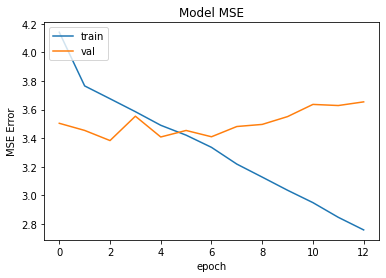

MAE: 1.226900566930014
MSE: 3.4830654219121153
RMSE: 1.8662972490769296
R2: 0.3454119808712568
-- Test results saved
- Using values until day 2 out of 21
-- Preparing data
-- Transforming data splits


-- Training models
--- Training LSTM
--- Evaluating LSTM


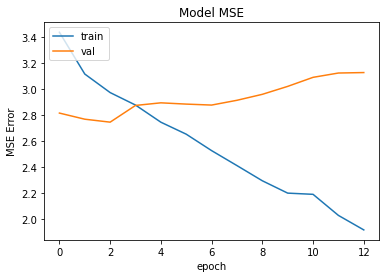

MAE: 1.1504700819814928
MSE: 3.0570435785423746
RMSE: 1.748440327418232
R2: 0.42547616594300375
-- Test results saved
- Using values until day 3 out of 21
-- Preparing data
-- Transforming data splits


-- Training models
--- Training LSTM
--- Evaluating LSTM


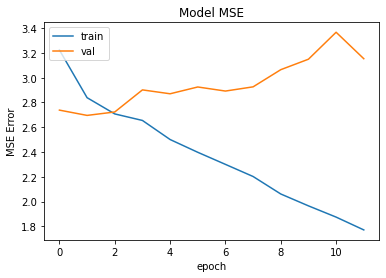

MAE: 1.1260848347800338
MSE: 2.980220060296451
RMSE: 1.7263313877400397
R2: 0.43991395235802133
-- Test results saved
- Using values until day 4 out of 21
-- Preparing data
-- Transforming data splits


-- Training models
--- Training LSTM
--- Evaluating LSTM


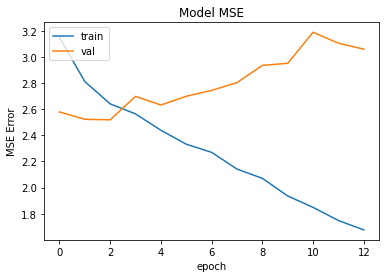

MAE: 1.102824536722529
MSE: 2.7933527628954646
RMSE: 1.6713326308354852
R2: 0.4750327569822831
-- Test results saved
- Using values until day 5 out of 21
-- Preparing data
-- Transforming data splits


-- Training models
--- Training LSTM
--- Evaluating LSTM


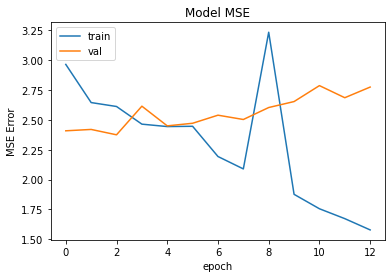

MAE: 1.0932720882303109
MSE: 2.7524005088849117
RMSE: 1.6590360179588963
R2: 0.48272909672456354
-- Test results saved
- Using values until day 6 out of 21
-- Preparing data
-- Transforming data splits


-- Training models
--- Training LSTM
--- Evaluating LSTM


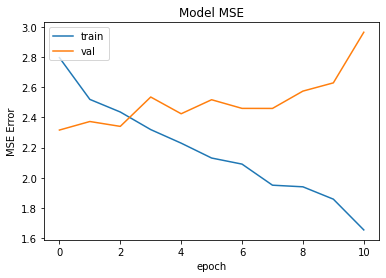

MAE: 1.0584363596085506
MSE: 2.6762463273963624
RMSE: 1.6359236924124434
R2: 0.4970410916975416
-- Test results saved
- Using values until day 7 out of 21
-- Preparing data
-- Transforming data splits


-- Training models
--- Training LSTM
--- Evaluating LSTM


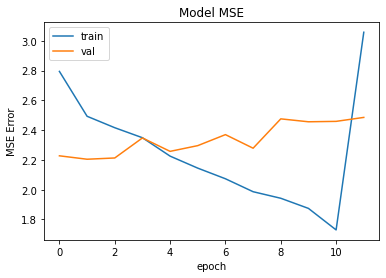

MAE: 1.0469861253049195
MSE: 2.5982843811428253
RMSE: 1.6119194710477398
R2: 0.5116928279653918
-- Test results saved
- Using values until day 8 out of 21
-- Preparing data
-- Transforming data splits


-- Training models
--- Training LSTM
--- Evaluating LSTM


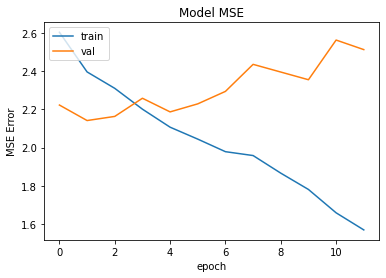

MAE: 1.0363180488275812
MSE: 2.4633581632083676
RMSE: 1.5695088923635852
R2: 0.5370501138695318
-- Test results saved
- Using values until day 9 out of 21
-- Preparing data
-- Transforming data splits


-- Training models
--- Training LSTM
--- Evaluating LSTM


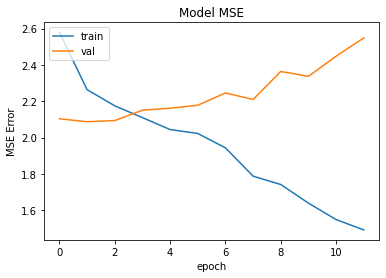

MAE: 1.0110328983099173
MSE: 2.463525347479513
RMSE: 1.5695621515185414
R2: 0.5370186941838178
-- Test results saved
- Using values until day 10 out of 21
-- Preparing data
-- Transforming data splits


-- Training models
--- Training LSTM
--- Evaluating LSTM


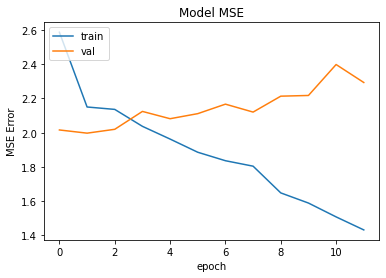

MAE: 1.0029271361020993
MSE: 2.3409809240748674
RMSE: 1.5300264455475492
R2: 0.5600490142194615
-- Test results saved
- Using values until day 11 out of 21
-- Preparing data
-- Transforming data splits


-- Training models
--- Training LSTM
--- Evaluating LSTM


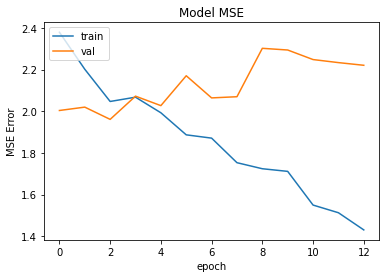

MAE: 0.9945152330859649
MSE: 2.2777316806782584
RMSE: 1.5092155845598263
R2: 0.5719357266211049
-- Test results saved
- Using values until day 12 out of 21
-- Preparing data
-- Transforming data splits


-- Training models
--- Training LSTM
--- Evaluating LSTM


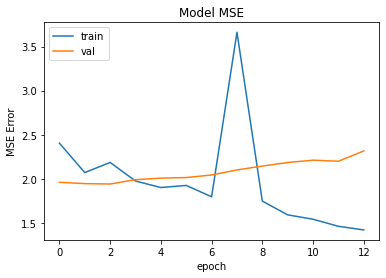

MAE: 0.9933552078214457
MSE: 2.261934221416457
RMSE: 1.5039728127251693
R2: 0.5749046135964673
-- Test results saved
- Using values until day 13 out of 21
-- Preparing data
-- Transforming data splits


-- Training models
--- Training LSTM
--- Evaluating LSTM


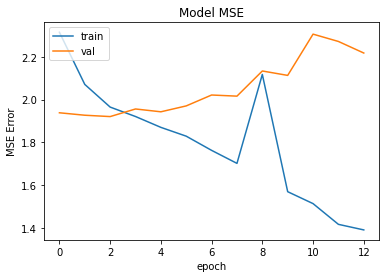

MAE: 0.9798852903058497
MSE: 2.23362050739169
RMSE: 1.4945301962127397
R2: 0.5802257361516316
-- Test results saved
- Using values until day 14 out of 21
-- Preparing data
-- Transforming data splits


-- Training models
--- Training LSTM
--- Evaluating LSTM


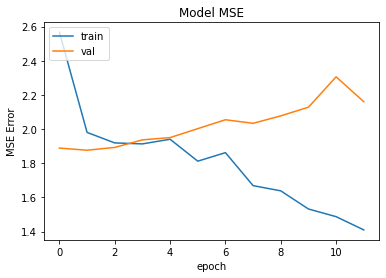

MAE: 0.9518548331129574
MSE: 2.185898796064273
RMSE: 1.4784785409549484
R2: 0.5891942901990886
-- Test results saved
- Using values until day 15 out of 21
-- Preparing data
-- Transforming data splits


-- Training models
--- Training LSTM
--- Evaluating LSTM


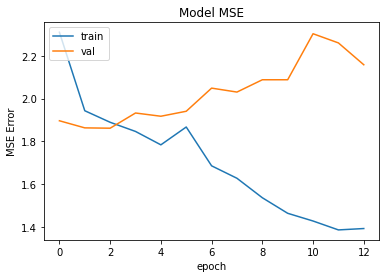

MAE: 0.9732272799345797
MSE: 2.179063392451296
RMSE: 1.4761650966105708
R2: 0.5904788980858127
-- Test results saved
- Using values until day 16 out of 21
-- Preparing data
-- Transforming data splits


-- Training models
--- Training LSTM
--- Evaluating LSTM


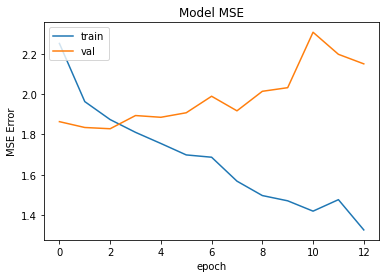

MAE: 0.956806891010617
MSE: 2.1508628856782783
RMSE: 1.4665820419186506
R2: 0.5957787450972543
-- Test results saved
- Using values until day 17 out of 21
-- Preparing data
-- Transforming data splits


-- Training models
--- Training LSTM
--- Evaluating LSTM


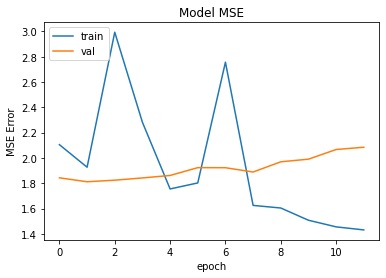

MAE: 0.9263749112656643
MSE: 2.1485193610255813
RMSE: 1.4657828492057006
R2: 0.5962191741372997
-- Test results saved
- Using values until day 18 out of 21
-- Preparing data
-- Transforming data splits


-- Training models
--- Training LSTM
--- Evaluating LSTM


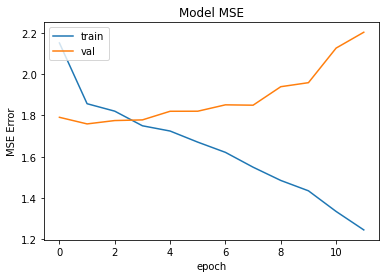

MAE: 0.9192549895990919
MSE: 2.133922650851513
RMSE: 1.4607952118115368
R2: 0.598962398981292
-- Test results saved
- Using values until day 19 out of 21
-- Preparing data
-- Transforming data splits


-- Training models
--- Training LSTM
--- Evaluating LSTM


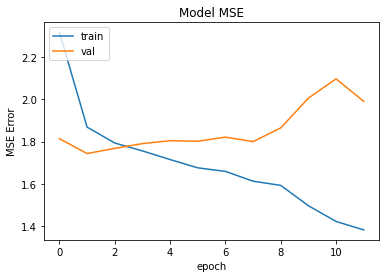

MAE: 0.9286687429705562
MSE: 2.1107654423683173
RMSE: 1.452847356871436
R2: 0.6033144364521372
-- Test results saved
- Using values until day 20 out of 21
-- Preparing data
-- Transforming data splits


-- Training models
--- Training LSTM
--- Evaluating LSTM


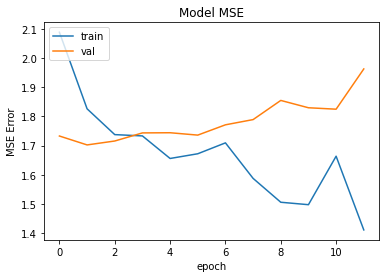

MAE: 0.9132987537038649
MSE: 2.0665836514458817
RMSE: 1.4375617035264545
R2: 0.6116177174699253
-- Test results saved
- Using values until day 21 out of 21
-- Preparing data
-- Transforming data splits


-- Training models
--- Training LSTM
--- Evaluating LSTM


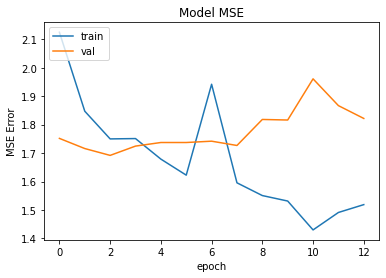

MAE: 0.9284821383039003
MSE: 2.016565607716116
RMSE: 1.4200583113788376
R2: 0.6210178315073436
-- Test results saved


In [ ]:
all_scores = []

for day in final_df['days_since_live'].unique():

  print('- Using values until day %s out of %s' %(int(day+1),len(final_df['days_since_live'].unique())))

  print('-- Preparing data')
  temp_df = final_df[final_df['days_since_live'] <= day]
  temp_df.sort_values(by=['property_id','days_since_live'], inplace=True)
  temp_df_1 = temp_df.drop(['property_id'], axis=1)

  # Lets transform the dataset (which is in a pandas df, to a numpy array)
  dataset_features = temp_df_1.drop(['unique_offers_cut'],axis=1).to_numpy()

  # Since each property has n rows (based on day value), representing n_days of being live, they will need to be group in a 3-d array in order to be splitted later on into train, validation and test data.
  X = dataset_features.reshape(int(temp_df_1.shape[0] / (day + 1)), day + 1,temp_df_1.shape[1]-1)

  # Additionally, we will need the target variable, which is this case, it will be the total number of offers within 6 months
  y = temp_df[['property_id','unique_offers_cut']]
  y.drop_duplicates(subset=['property_id'], inplace=True)
  y = y['unique_offers_cut'].to_numpy()


  # Train test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=14)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=14)

  print('-- Transforming data splits')
  # Define transformer
  preprocessor = create_transformer(vars_cat, vars_num, daily_values_vars)
  # Fit transformer and use it on training
  preprocessor, X_train = preprocessor_fit_transform(preprocessor, X_train, temp_df_1, day)
  # Use fitted transformer in validation and test data
  X_val = preprocessor_transform(preprocessor, X_val, temp_df_1, day)
  X_test = preprocessor_transform(preprocessor, X_test, temp_df_1, day)

  print('-- Training models')

  # LSTM model
  print('--- Training LSTM')
  model = None
  model = create_lstm_model(input_shape=(day + 1, X_train.shape[2]))
  history, model = train_model(model, X_train, y_train, X_val, y_val)
  print('--- Evaluating LSTM')
  plot_history(history)
  mae, mse, rmse, r2 = evaluate_model(model, X_test, y_test)
  all_scores.append([mae, mse, rmse, r2])


  # # RNN model
  # print('--- Training RNN')
  # model = None
  # model = create_rnn_model(input_shape=(day + 1, X_train.shape[2]))
  # history, model = train_model(model, X_train, y_train, X_val, y_val)
  # print('--- Evaluating RNN')
  # plot_history(history)
  # mae, mse, rmse, r2 = evaluate_model(model, X_test, y_test)
  # models_score_daily.append([mae, mse, rmse, r2])


  # # CNN model
  # print('--- Training CNN')
  # model = None
  # model = create_cnn_model(input_shape = (day + 1, X_train.shape[2]))
  # history, model = train_model(model, X_train, y_train, X_val, y_val)
  # print('--- Evaluating CNN')
  # plot_history(history)
  # mae, mse, rmse, r2 = evaluate_model(model, X_test, y_test)
  
  # models_score_daily.append([mae, mse, rmse, r2])

  print('-- Test results saved')

In [ ]:
scores_df = pd.DataFrame(data = all_scores, columns = ['mae','mse','rmse', 'r2'])

In [ ]:
scores_df['days_since_live'] = np.arange(1,22)

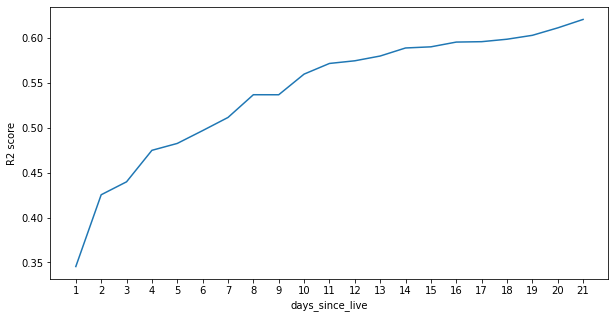

In [ ]:
scores_df.plot(kind='line', x='days_since_live', y='r2', figsize=(10,5), rot=0, legend=False)
plt.xticks(range(1, 22))
plt.ylabel('R2 score')
plt.show()

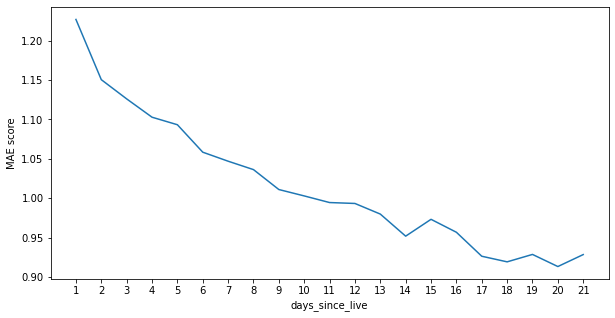

In [ ]:
scores_df.plot(kind='line', x='days_since_live', y='mae', figsize=(10,5), rot=0, legend=False)
plt.xticks(range(1, 22))
plt.ylabel('MAE score')
plt.show()

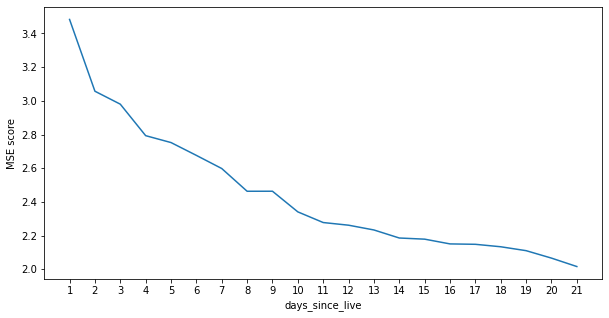

In [ ]:
scores_df.plot(kind='line', x='days_since_live', y='mse', figsize=(10,5), rot=0, legend=False)
plt.xticks(range(1, 22))
plt.ylabel('MSE score')
plt.show()

## Dealing with overfitting

**WORK IN PROGRESS**


Something that can be seen from training the LSTM model, is that the training loss and validation loss diverge each other quite rapidly and early at training, suggesting overfitting of the model, where it is able to memorize the training data but suffers to increase performance when evaluating in validation data (which in our case, is only used to evaluate model performance in training).

For example, in the following picture:

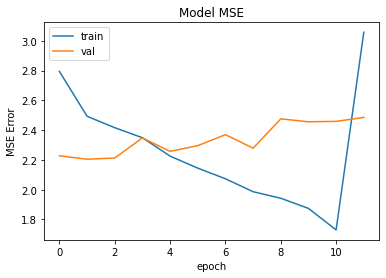

This can be because of multiple cases, and needs experimentation to see if a solution to prevent this, and improves performance can be reached.

I will try the following things:

- Increase the size of the LSTM model, by adding more cell units and layers.
- Add remove features that might be adding noise, for example, price change.
- Add additional layers (Dense layers) before and after the LSTM layers.
- Adjusting learning rate during training.


In [ ]:
day = 6

In [ ]:
temp_df = final_df[final_df['days_since_live'] <= day]
temp_df.sort_values(by=['property_id','days_since_live'], inplace=True)
temp_df_1 = temp_df.drop(['property_id'], axis=1)

# Lets transform the dataset (which is in a pandas df, to a numpy array)
dataset_features = temp_df_1.drop(['unique_offers_cut'],axis=1).to_numpy()

# Since each property has n rows (based on day value), representing n_days of being live, they will need to be group in a 3-d array in order to be splitted later on into train, validation and test data.
X = dataset_features.reshape(int(temp_df_1.shape[0] / (day + 1)), day + 1,temp_df_1.shape[1]-1)

# Additionally, we will need the target variable, which is this case, it will be the total number of offers within 6 months
y = temp_df[['property_id','unique_offers_cut']]
y.drop_duplicates(subset=['property_id'], inplace=True)
y = y['unique_offers_cut'].to_numpy()


# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=14)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=14)

print('-- Transforming data splits')
# Define transformer
preprocessor = create_transformer(vars_cat, vars_num, daily_values_vars)
# Fit transformer and use it on training
preprocessor, X_train = preprocessor_fit_transform(preprocessor, X_train, temp_df_1, day)
# Use fitted transformer in validation and test data
X_val = preprocessor_transform(preprocessor, X_val, temp_df_1, day)
X_test = preprocessor_transform(preprocessor, X_test, temp_df_1, day)

-- Transforming data splits


In [ ]:
for n_units in [16, 32, 48, 64, 80, 96, 102, 128]:
  
  # Defining LSTM model
  model = Sequential()
  model.add(LSTM(n_units, activation='relu', input_shape = (day + 1, X_train.shape[2]))) # Input shape is n_timesteps, n_features
  model.add(Dense(100, activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer = tf.keras.optimizers.Adam(), loss='mse')

  # EarlyStopping callback to stop training if validation loss does not decrease after certain # of epochs
  callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  # fit model and save train and val loss at each epoch for plotting
  history = model.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_val, y_val), callbacks = [callback])

# Using Strike data (up to 21 days) using approach that does not duplicate pre go live features

## Functions

In [ ]:
def train_test_data_split(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=14)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=14)

    return X_train, X_val, X_test, y_train, y_val, y_test


def create_transformer(vars_cat, vars_num, daily_values_vars):

  numeric_preprocessor = Pipeline(
        steps = [
            ('imputation_mean', SimpleImputer(strategy='mean')),
            ('scaler', RobustScaler())
        ]
    )
  daily_values_preprocessor = Pipeline(
          steps = [
              ('imputation_mean', SimpleImputer(strategy='mean')),
              ('scaler', RobustScaler())
          ]
      )
  categorical_preprocessor = Pipeline(
          steps = [
              ('imputation_mode', SimpleImputer(strategy='most_frequent')),
              ('ohe',OneHotEncoder(handle_unknown='ignore', sparse=False))
              
          ]
      )
  preprocessor = ColumnTransformer([
                                    ('cat_preprocessor', categorical_preprocessor, vars_cat),
                                    ('num_preprocessor', numeric_preprocessor, vars_num),
                                    ('dv_preprocessor', daily_values_preprocessor, daily_values_vars)], 
                                  sparse_threshold= 0, remainder='passthrough')
  
  return preprocessor


def preprocessor_fit_transform(preprocessor, X_train, temp_df_1, days):

    # In order to use an scaler/transformer, data needs to be in a 2-d shape, and our current data is in 3-d
    X_train_df = pd.DataFrame(X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2]))
    X_train_df.columns = temp_df_1.columns[0:-1] # Just adding original column names (not really needed, just for reference)

    # Using transformer to fit and transform training data
    train_df_encoded = preprocessor.fit_transform(X_train_df)

    X_train_df_encoded = pd.DataFrame(train_df_encoded)

    encoded_categorical_columns_names = preprocessor.named_transformers_['cat_preprocessor'].named_steps['ohe'].get_feature_names_out(vars_cat)
    numerical_columns_names = preprocessor.named_transformers_['num_preprocessor'].named_steps['scaler'].get_feature_names_out(vars_num)
    dv_columns_names = preprocessor.named_transformers_['dv_preprocessor'].named_steps['scaler'].get_feature_names_out(daily_values_vars)
    X_train_df_encoded.columns = [*encoded_categorical_columns_names,*numerical_columns_names,*dv_columns_names,*['property_id']]

    # Reshaping data into 3-d shape
    X_train = X_train_df_encoded

    return preprocessor, X_train

def preprocessor_transform(preprocessor, X_val, temp_df_1, days):

    # Doing same above process but with validation data and using fitted scaler to only transform data
    X_val_df = pd.DataFrame(X_val.reshape(X_val.shape[0]*X_val.shape[1], X_val.shape[2]))
    X_val_df.columns = temp_df_1.columns[0:-1]
    X_val_df_encoded = pd.DataFrame(preprocessor.transform(X_val_df))


    encoded_categorical_columns_names = preprocessor.named_transformers_['cat_preprocessor'].named_steps['ohe'].get_feature_names_out(vars_cat)
    numerical_columns_names = preprocessor.named_transformers_['num_preprocessor'].named_steps['scaler'].get_feature_names_out(vars_num)
    dv_columns_names = preprocessor.named_transformers_['dv_preprocessor'].named_steps['scaler'].get_feature_names_out(daily_values_vars)
    X_val_df_encoded.columns = [*encoded_categorical_columns_names,*numerical_columns_names,*dv_columns_names, *['property_id']]

    # Reshaping data into 3-d shape
    X_val = X_val_df_encoded

    return X_val

def separate_pre_pos_data(preprocessor, X_train_df_encoded, vars_cat, vars_num, daily_values_vars, day):

    encoded_categorical_columns_names = preprocessor.named_transformers_['cat_preprocessor'].named_steps['ohe'].get_feature_names_out(vars_cat)
    numerical_columns_names = preprocessor.named_transformers_['num_preprocessor'].named_steps['scaler'].get_feature_names_out(vars_num)
    dv_columns_names = preprocessor.named_transformers_['dv_preprocessor'].named_steps['scaler'].get_feature_names_out(daily_values_vars)

    # post go live
    X_train_df_encoded_daily_values = X_train_df_encoded[dv_columns_names]
    X_train_df_encoded_daily_values = X_train_df_encoded_daily_values.to_numpy()
    X_train_df_encoded_daily_values = X_train_df_encoded_daily_values.reshape(int(X_train_df_encoded_daily_values.shape[0] / (day + 1)), day + 1, X_train_df_encoded_daily_values.shape[1]) # Reshaping data from 2-d to 3-d

    # Pre go live data
    X_train_df_encoded_pre_go_live = X_train_df_encoded[[*encoded_categorical_columns_names,*numerical_columns_names] + ['property_id']]
    X_train_df_encoded_pre_go_live.drop_duplicates(subset=['property_id'], inplace=True)
    X_train_df_encoded_pre_go_live.drop(['property_id'], axis=1, inplace=True)

    X_train_df_encoded_pre_go_live = X_train_df_encoded_pre_go_live.to_numpy()

    return np.asarray(X_train_df_encoded_pre_go_live).astype('float32'), np.asarray(X_train_df_encoded_daily_values).astype('float32')


def create_lstm_fc_model(input_shape_pre_go_live, input_shape_post_go_live, concatenate_direct = True,
                         n_units = 50, optimizer = tf.keras.optimizers.Adam()):

    """

    Create a lstm model (with one layer) and with n_units (based on user input) that receives
    an user predifined input shape and returns one single output, and uses mean_squared_error as loss function

    By default, uses Adam optimizer (with default values), but different optimizer can be given.

  """

    # Define inputs of the model
    post_go_live_input = keras.Input(shape=input_shape_post_go_live, name="lstm_input")
    pre_go_live_input = keras.Input(shape=input_shape_pre_go_live, name="pre-go-live")

    # Define subsequent layers for each input type
    # For post go live features
    lstm_output = LSTM(n_units,activation='relu')(post_go_live_input)

    # For pre go live features
    # One option is to concatenate the pre go live features as they are, with the output of the LSTM
    # A second option is to use Dense layers to compress the pre go live features input

    # By default, it will use approach 1
    if not concatenate_direct:
      fc_layer_1 = keras.layers.Dense(400, activation='relu', name='fc_1')(pre_go_live_input)
      fc_layer_2 = keras.layers.Dense(200, activation='relu', name='fc_2')(fc_layer_1)
    else:
      fc_layer_2 = pre_go_live_input


    # Merge output from LSTM, which handle post go live features (time series data) and the pre go live features
    # which can be either the raw input or a compress version (output from Dense layers)
    x = keras.layers.concatenate([lstm_output, fc_layer_2])

    # Dense layers that will handle the combined features
    fc_layer_3 = keras.layers.Dense(50, name="fc_3", activation='relu')(x)
    # Stick a department classifier on top of the features
    pred = keras.layers.Dense(1, name="prediction_layer")(fc_layer_3)

    # Instantiate an end-to-end model predicting both priority and department
    model = keras.Model(
        inputs=[pre_go_live_input,post_go_live_input],
        outputs=[pred]
    )
    model.compile(optimizer = optimizer, loss='mse')

    return model


def train_model(model, X_train, y_train, X_val, y_val, verbose=0):

    # EarlyStopping callback to stop training if validation loss does not decrease after certain # of epochs
    callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    # fit model and save train and val loss at each epoch for plotting
    history = model.fit(X_train, y_train, epochs=100, verbose=verbose, validation_data=(X_val, y_val), callbacks = [callback])

    return history, model

def plot_history(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model MSE')
    plt.ylabel('MSE Error')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

def evaluate_model(model, X_test, y_test):

    # Getting predictions and evaluation for LSTM
    preds = model.predict(X_test)

    # Evaluating results
    mae = mean_absolute_error(y_test, preds)
    print("MAE: %s" %mae )
    mse = mean_squared_error(y_test, preds)
    print("MSE: %s" % mse)
    rmse = mean_squared_error(y_test, preds, squared=False)
    print("RMSE: %s" %rmse)
    r2 = r2_score(y_test, preds)
    print("R2: %s" % r2)

    return mae, mse, rmse, r2

## Data preparation

In [ ]:
# Load property level data (contains info such as number_of_beds, etc)
df_properties_main = pd.read_csv(r"/content/agg_data_7days.csv")
df_properties_main.drop_duplicates(subset=['property_id'], inplace=True)
df_properties_main.shape
# Load post go live features/values for up to 7 days
df_properties_daily = pd.read_csv(r"/content/daily_values_21days.csv")
df_properties_daily.shape


## Preprocessing dataset with property level data
# Copy dataframe and change date features to correct format
df_properties = df_properties_main
df_properties['gl_date'] = pd.to_datetime(df_properties['gl_date'])
df_properties['gl_date_year'] = pd.DatetimeIndex(df_properties['gl_date']).year
df_properties['gl_date_month'] = df_properties['gl_date'].dt.month_name()
df_properties['cc_date'] = pd.to_datetime(df_properties['cc_date'])
# Drop epc_expire_date feature, this might be used later on, but need to analyze the impact of it, since this can be a factor for a property 
# to be off market.
df_properties.drop(labels=['epc_expiry_date'], axis=1,inplace=True)

# Remove rows with a higher and lower first listed price
# This might be useful for removing higher first listed prices, since the distribution is skewed to the right.
df_properties = df_properties[(np.abs(stats.zscore(df_properties['first_listed_price'])) < 4)]
df_properties = df_properties[df_properties['first_listed_price'] > 9000]

# Clean council tax band variable
def clean_council_tax_band(row):
  clean_tax_band = row.lower().replace("band ","").replace("#a", "a").replace("aa", "a")\
          .replace("b1200","b").replace("n/a","nan").replace("-","nan")

  if clean_tax_band in ['a','b','c','d','e','f','g']:
    return clean_tax_band
  else:
    return "unknown"

df_properties['council_tax_band'] = df_properties['council_tax_band'].astype(str)
df_properties['council_tax_band'] = df_properties['council_tax_band'].apply(clean_council_tax_band)

# Make the purchase products/services features into a int
# Replace incorrect values and missing values with 0
df_properties['prof_photos'].fillna(0, inplace=True)
df_properties['prof_photos'].replace(2,1,inplace=True)
df_properties['prof_photos'] = df_properties['prof_photos'].astype(int)

df_properties['digitial_marketing_pack'].fillna(0, inplace=True)
df_properties['digitial_marketing_pack'] = df_properties['digitial_marketing_pack'].astype(int)
df_properties['digitial_marketing_pack'].replace(2,1,inplace=True)

df_properties['premium_advert_ordered'].fillna(0, inplace=True)
df_properties['premium_advert_ordered'] = df_properties['premium_advert_ordered'].astype(int)
df_properties['premium_advert_ordered'].replace(2,1,inplace=True)

df_properties['bundle_ordered'].fillna(0, inplace=True)
df_properties['bundle_ordered'] = df_properties['bundle_ordered'].astype(int)
df_properties['bundle_ordered'].replace(2,1,inplace=True)


df_properties['hosted_viewings'].fillna(0, inplace=True)
df_properties['hosted_viewings'] = df_properties['hosted_viewings'].astype(int)
df_properties['hosted_viewings'].replace(2,1,inplace=True)

df_properties['viewing_pack_ordered'].fillna(0, inplace=True)
df_properties['viewing_pack_ordered'] = df_properties['viewing_pack_ordered'].astype(int)
df_properties['viewing_pack_ordered'].replace(2,1,inplace=True)


df_properties['new_build'].fillna(0, inplace=True)
df_properties['new_build'] = df_properties['new_build'].astype(int)

df_properties['strike_market_share_percent'].fillna(0, inplace=True)
df_properties['strike_market_share_percent'] = df_properties['strike_market_share_percent'].astype(float)

# There are properties which have been listed, but then cancelled for various reasons, not providing epc or simply cancelling
# Remove properties which have been listed for less than 14 days or did not receive any offer at all
df_properties['days_listed'] = df_properties['cc_date'] - df_properties['gl_date']
df_properties['days_listed'] = df_properties['days_listed'].dt.days
df_properties['days_listed'].fillna(180.0, inplace=True)
df_properties = df_properties[(df_properties['days_listed'] >= 14) | (df_properties['total_offers'] > 0)]
df_properties_ap = df_properties
df_properties_ap.drop(labels=['days_listed'], axis=1, inplace=True)

# Identify numerical and categorical variables
vars_num = [var for var in df_properties_ap.columns if (df_properties_ap[var].dtypes != 'O') and (var != 'property_id' and var != 'user_id')]
vars_cat = [var for var in df_properties_ap.columns if (df_properties_ap[var].dtypes == 'O')]

# Lower categorical features
for var in vars_cat:
    df_properties_ap[var] = df_properties_ap[var].str.lower()
    df_properties_ap[var] = df_properties_ap[var].str.replace(" ","_")
    # df_properties_ap[var].fillna('other', inplace=True)


# Load offers dataset in order to filter out offers
# Contains information about actual offers made for each property in property dataset
df_offers = pd.read_csv(r"/content/offers_data_all.csv")
# Drop record of properties that did not get an offer at all
df_offers_true = df_offers[~df_offers['days_listing_to_offer_recieved'].isnull()]
# Drop samples that have a negative value input in days_listing_to_offer_recieved and also the offers received after 180 days (6 months)
# Not sure why there are properties with negative values in day_listing_to_offer_recieved
df_offers_true =df_offers_true[(df_offers_true.days_listing_to_offer_recieved >= 0) & (df_offers_true.days_listing_to_offer_recieved <180)]

# Convert days_listing_to_offer_recieved to int, to be able to sort out for getting unique offers
df_offers_true['days_listing_to_offer_recieved'] = df_offers_true['days_listing_to_offer_recieved'].astype(int)

# Calculate difference in percentage between features (offer price vs asking price, and first_listed_price vs listed_price_when_offer)
def percentage_change(col1,col2):
    return round(((col2 - col1)/ col1) * 100,2)

# Compute the difference between a listed price when offer (property asking price at that moment) vs what a buyer offers for it
df_offers_true['diff_offer_vs_price'] = percentage_change(df_offers_true['listed_price_when_offer'],df_offers_true['offer_price'])
# Drop offers that have a -50% or more difference between asking price and offer price
df_offers_true_merged = df_offers_true[np.abs(df_offers_true['diff_offer_vs_price']) <= 50]
# Drop offers with the same offer_id value, not sure why the query gives more offers (duplicated), might be the query and its left joins.
df_offers_true_merged.drop_duplicates(subset=['offer_id'], inplace=True)



# Take the latest offer from a buyer. A buyer might offer more than once (either because the previous is withdrawn or rejected). Only consider the latest offer.

# Sort offers received by each property by date received and buyer, only keep latest one
unique_offers = df_offers_true_merged[['property_id','buyer_user_id','offer_id','days_listing_to_offer_recieved']].sort_values('days_listing_to_offer_recieved').drop_duplicates(['property_id','buyer_user_id'], keep='last')
unique_offers_join_prop = unique_offers.groupby(['property_id']).size().reset_index()
unique_offers_join_prop.rename(columns={0:'unique_offers'}, inplace=True)
# Join unique number of offers with the property aggregated dataset which contains property level features
df_properties_ap = df_properties_ap.merge(unique_offers_join_prop, on = 'property_id', how='left')
df_properties_ap['unique_offers'].fillna(0, inplace=True)
df_properties_ap['unique_offers'] = df_properties_ap['unique_offers'].astype(int)

# Do not count  offers that are -13.31 lower than the asking price, or are not marked as complete
df_offers_true_merged = df_offers_true_merged[~((df_offers_true_merged['diff_offer_vs_price'] < -13.31) & (df_offers_true_merged['offer_status'] != 'complete'))]
df_offers_true_merged = df_offers_true_merged.merge(unique_offers['offer_id'],
                                                on='offer_id', how='inner')
unique_offers_join_prop = df_offers_true_merged.groupby(['property_id']).size().reset_index()
unique_offers_join_prop.rename(columns={0:'unique_offers_cut'}, inplace=True)
df_properties_ap = df_properties_ap.merge(unique_offers_join_prop, on = 'property_id', how='left')
df_properties_ap['unique_offers_cut'].fillna(0, inplace=True)
df_properties_ap['unique_offers_cut'] = df_properties_ap['unique_offers_cut'].astype(int)

df_properties_ap['unique_offers_cut'] = np.where(df_properties_ap['offers_received_7days'] > df_properties_ap['unique_offers_cut'], df_properties_ap['unique_offers'], df_properties_ap['unique_offers_cut'])
# Partially validate filtering of number of offers was done correct
test = df_properties_ap
assert len(test[test['unique_offers'] > test['total_offers']]) == 0
assert len(test[test['unique_offers_cut'] > test['unique_offers']]) == 0
# Preprocessing on specific features that have odd values
df_properties_ap = df_properties_ap[df_properties_ap['build_year'] > 1800]
df_properties_ap['build_year_group'] = np.where(df_properties_ap['build_year'] == 2000, 'post_2000',df_properties_ap['build_year_group'])
df_properties_ap.drop(labels=['unique_offers','total_offers', 'cc_date','sq_ft','council_tax_cost', 'strike_agent','key_features'], axis=1,inplace=True)
print(df_properties_ap.shape)
# Identify numerical and categorical variables
vars_num = [var for var in df_properties_ap.columns if (df_properties_ap[var].dtypes != 'O') and (var != 'property_id' and var != 'user_id')]
vars_cat = [var for var in df_properties_ap.columns if (df_properties_ap[var].dtypes == 'O') and (var != 'gl_date' and var != 'cc_date')]

# Check for missing values in each feature
vars_num_na = [var for var in vars_num if df_properties_ap[var].isnull().sum() > 0]
print('Numerical features missing values report:')
print(df_properties_ap[vars_num_na].isnull().mean().sort_values(ascending=False))
print('\n')
print('Categorical features missing values report:')
vars_cat_na = [var for var in vars_cat if df_properties_ap[var].isnull().sum() > 0]
print(df_properties_ap[vars_cat_na].isnull().mean().sort_values(ascending=False))
df_properties_ap['avgprice_sim_strike_ppts_ol'] = np.where(df_properties_ap['avgprice_sim_strike_ppts_ol'].isnull(), 
                                                            df_properties_ap['first_listed_price'],df_properties_ap['avgprice_sim_strike_ppts_ol'])

df_properties_ap['avg_rm_views_sim_strike_ppts_ol'] = np.where(df_properties_ap['avg_rm_views_sim_strike_ppts_ol'].isnull(), 
                                                            0,df_properties_ap['avg_rm_views_sim_strike_ppts_ol'])
# Identify numerical and categorical variables
vars_num = [var for var in df_properties_ap.columns if (df_properties_ap[var].dtypes != 'O') and (var != 'property_id' and var != 'user_id')]
vars_cat = [var for var in df_properties_ap.columns if (df_properties_ap[var].dtypes == 'O') and (var != 'gl_date' and var != 'cc_date')]

(30954, 88)
Numerical features missing values report:
avg_rm_views_sim_strike_ppts_ol    0.171577
avgprice_sim_strike_ppts_ol        0.171028
avg_price_3months                  0.000032
avg_hpi_index_3months              0.000032
avg_monthly_change_3months         0.000032
avg_annual_change_3months          0.000032
dtype: float64


Categorical features missing values report:
double_glazing            0.009240
county                    0.002552
urban_rural_category      0.000485
strike_defined_channel    0.000291
parking_type              0.000032
listing_pricetype         0.000032
dtype: float64


In [ ]:
## Preprocessing dataset with daily values
# There are some features that can be enginer from the current daily values, such as cummulative sum of daily values, extracting the year, month and day from date, etc.
# Cummulative sum
df_properties_daily['vr_daily_cumsum'] = df_properties_daily.groupby('property_id').vr_daily.cumsum()
df_properties_daily['vc_daily_cumsum'] = df_properties_daily.groupby('property_id').vc_daily.cumsum()
df_properties_daily['rm_summary_views_daily_cumsum'] = df_properties_daily.groupby('property_id').rm_summary_views_daily.cumsum()
df_properties_daily['rm_detailed_views_daily_cumsum'] = df_properties_daily.groupby('property_id').rm_detailed_views_daily.cumsum()
df_properties_daily['sim_ppts_ol_listed_daily_cumsum'] = df_properties_daily.groupby('property_id').sim_ppts_ol_listed_daily.cumsum()
df_properties_daily['sim_ppts_ol_stc_daily_cumsum'] = df_properties_daily.groupby('property_id').sim_ppts_ol_stc_daily.cumsum()
df_properties_daily['offers_recieved_daily_cumsum'] = df_properties_daily.groupby('property_id').offers_recieved_daily.cumsum()

# Extract features from date of reporting column
df_properties_daily['date_of_reporting'] = pd.to_datetime(df_properties_daily['date_of_reporting'])
df_properties_daily['year'] = df_properties_daily['date_of_reporting'].dt.year
df_properties_daily['month'] = df_properties_daily['date_of_reporting'].dt.month
df_properties_daily['day'] = df_properties_daily['date_of_reporting'].dt.day
df_properties_daily = df_properties_daily[['property_id','year','month','day','days_since_live','vr_daily_cumsum','vc_daily_cumsum',
                                           'price_change_percentage_daily','rm_summary_views_daily_cumsum','rm_detailed_views_daily_cumsum',
                                           'premium_listing_daily','featured_property_daily',
                                           'sim_ppts_ol_listed_daily_cumsum','sim_ppts_ol_stc_daily_cumsum','offers_recieved_daily_cumsum']]

In [ ]:
df_properties_daily.mask(df_properties_daily < 0, np.nan, inplace=True)

In [ ]:
# Defining names of categorical, numerical and daily values (post-go live features) features
vars_num = ['number_of_beds','no_of_bathrooms','no_of_receptions','land','new_build','build_year',
            'epc_exempt','virtual_visit','prof_photos','digitial_marketing_pack','can_have_board',
            'premium_advert_ordered','bundle_ordered','hosted_viewings','viewing_pack_ordered',
            'strike_market_share_percent','first_listed_price','population_in_area','population_density',
            'income_decile','populated_area','pop_area_with_gospace_access','pct_pop_area_with_gospace_access',
            'pct_pop_area_without_gospace_access','pop_without_gospace_access','average_demand_trend_6weeks',
            'avg_sales_quarter_3qts','avg_median_pricepaid_3qts',	'avg_price_3months','avg_hpi_index_3months',
            'avg_monthly_change_3months','avg_annual_change_3months','no_sim_ppts_ol',
            'avgweeks_inmarket_sim_ppts_ol','avgprice_sim_ppts_ol','medianprice_sim_ppts_ol',
            'no_sim_ppts_ol_stc','avgweeks_to_stc_sim_ppts_ol_stc','avgprice_sim_ppts_ol_stc',
            'medianprice_sim_ppts_ol_stc','no_sim_strike_ppts_ol','avgprice_sim_strike_ppts_ol', 
            'avg_offers_sim_strike_ppts_ol','avg_vr_sim_strike_ppts_ol','avg_vc_sim_strike_ppts_ol']

vars_cat = ['property_type','build_year_group','tenure_type','heating_type','double_glazing','parking_type','garden',
            'council_tax_band','itv_region','urban_rural_category','county',
            'rural_ubran_classification_detail_lsoa','rural_urban_classification_detail_msoa','spatial_signature_type',
            'chain_situation','strike_defined_channel','listing_pricetype',
            'gl_date_month']

daily_values_vars = ['year','month','day','days_since_live','vr_daily_cumsum','vc_daily_cumsum',
                     'price_change_percentage_daily','rm_summary_views_daily_cumsum','rm_detailed_views_daily_cumsum',
                     'premium_listing_daily','featured_property_daily',
                     'sim_ppts_ol_listed_daily_cumsum','sim_ppts_ol_stc_daily_cumsum',
                     'offers_recieved_daily_cumsum']

target = ['unique_offers_cut']

In [ ]:
# Merging pre-go live features with post go live (daily values) features datasets
final_df = pd.merge(df_properties_daily,df_properties_ap[['property_id']+vars_num + vars_cat + target], how="inner", on=['property_id'])
final_df.shape

(650034, 79)

## Training and Evaluation

In [ ]:
all_scores = []

- Using values until day 1 out of 21
-- Preparing data
-- Transforming data
-- Separating pre and post go live data
-- Training models
--- Creating LSTM


--- Training LSTM
--- Evaluating LSTM


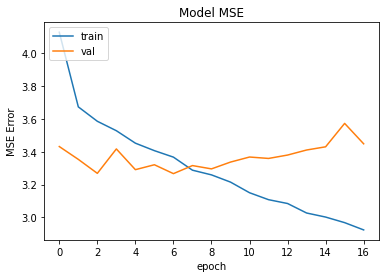

MAE: 1.2151396205186729
MSE: 3.3675917976187733
RMSE: 1.8350999421336085
R2: 0.36711345409431784
-- Test results saved
- Using values until day 2 out of 21
-- Preparing data
-- Transforming data
-- Separating pre and post go live data
-- Training models
--- Creating LSTM


--- Training LSTM
--- Evaluating LSTM


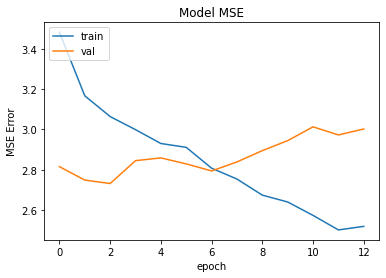

MAE: 1.1480811390621486
MSE: 3.0283366832394876
RMSE: 1.7402116777103547
R2: 0.4308711808093445
-- Test results saved
- Using values until day 3 out of 21
-- Preparing data
-- Transforming data
-- Separating pre and post go live data
-- Training models
--- Creating LSTM


--- Training LSTM
--- Evaluating LSTM


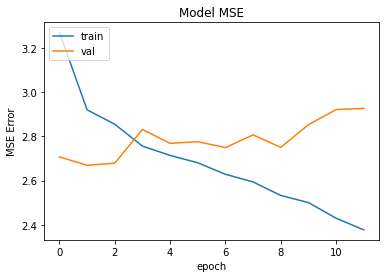

MAE: 1.1175133545271745
MSE: 2.949315442351508
RMSE: 1.7173571097332985
R2: 0.44572199504227417
-- Test results saved


In [ ]:
for day in [0,1,2]:

  print('- Using values until day %s out of %s' %(int(day+1),len(final_df['days_since_live'].unique())))

  print('-- Preparing data')
  temp_df = final_df[final_df['days_since_live'] <= day]
  temp_df.sort_values(by=['property_id','days_since_live'], inplace=True)


  # Lets transform the dataset (which is in a pandas df, to a numpy array)
  dataset_features = temp_df.drop(['unique_offers_cut'],axis=1).to_numpy()

  # Since each property has 7 rows, representing 7 days of being live, they will need to be group in a 3-d array in order to be splitted later on into train, validation and test data.
  X = dataset_features.reshape(int(temp_df.shape[0] / (day + 1)), day + 1,temp_df.shape[1]-1)

  # Additionally, we will need the target variable, which is this case, it will be the total number of offers within 6 months
  y = temp_df[['property_id','unique_offers_cut']]
  y.drop_duplicates(subset=['property_id'], inplace=True)
  y = y['unique_offers_cut'].to_numpy()

  # Lets train test split the data to get a train, validation and testing set
  X_train, X_val, X_test, y_train, y_val, y_test = train_test_data_split(X, y)

  print('-- Transforming data')
  # Define transformer
  preprocessor = create_transformer(vars_cat, vars_num, daily_values_vars)
  # Fit transformer and use it on training
  preprocessor, X_train_df_encoded = preprocessor_fit_transform(preprocessor, X_train, temp_df, day)
  # Use fitted transformer in validation and test data
  X_val_encoded = preprocessor_transform(preprocessor, X_val, temp_df, day)
  X_test_encoded = preprocessor_transform(preprocessor, X_test, temp_df, day)
  print('-- Separating pre and post go live data')
  # Separate pre and pos go live features
  # Training data
  X_train_prego_live, X_train_posgo_live = separate_pre_pos_data(preprocessor, X_train_df_encoded, vars_cat, vars_num, 
                                                                 daily_values_vars, day)
  # Validation data
  X_val_prego_live, X_val_posgo_live = separate_pre_pos_data(preprocessor, X_val_encoded, vars_cat, vars_num, 
                                                             daily_values_vars, day)
  # Test data
  X_test_prego_live, X_test_posgo_live = separate_pre_pos_data(preprocessor, X_test_encoded, vars_cat, vars_num, 
                                                               daily_values_vars, day)
  
  del X_train_df_encoded
  del X_val_encoded
  del X_test_encoded

  print('-- Training models')
  print('--- Creating LSTM')
  model = None
  model = create_lstm_fc_model(input_shape_pre_go_live=(X_train_prego_live.shape[1],), 
                               input_shape_post_go_live=(X_train_posgo_live.shape[1], X_train_posgo_live.shape[2]))
  
  print('--- Training LSTM')
  history, model = train_model(model, [X_train_prego_live, X_train_posgo_live], y_train, 
                               [X_val_prego_live, X_val_posgo_live], y_val)
  print('--- Evaluating LSTM')
  plot_history(history)
  mae, mse, rmse, r2 = evaluate_model(model, [X_test_prego_live, X_test_posgo_live], y_test)
  all_scores.append([mae, mse, rmse, r2])

  print('-- Test results saved')

- Using values until day 4 out of 21
-- Preparing data
-- Transforming data
-- Separating pre and post go live data
-- Training models
--- Creating LSTM


--- Training LSTM
--- Evaluating LSTM


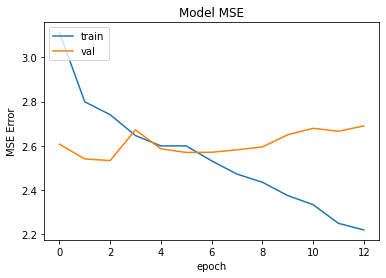

MAE: 1.1133373111188027
MSE: 2.7540679679438194
RMSE: 1.6595384804046633
R2: 0.4824157237067953
-- Test results saved
- Using values until day 5 out of 21
-- Preparing data
-- Transforming data
-- Separating pre and post go live data
-- Training models
--- Creating LSTM


--- Training LSTM
--- Evaluating LSTM


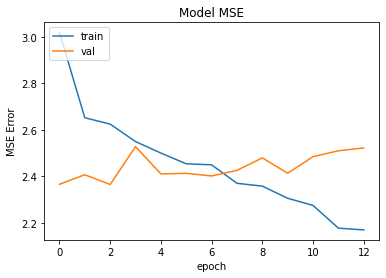

MAE: 1.1024120870462646
MSE: 2.743599126296675
RMSE: 1.656381334806896
R2: 0.48438317980832746
-- Test results saved
- Using values until day 6 out of 21
-- Preparing data
-- Transforming data
-- Separating pre and post go live data
-- Training models
--- Creating LSTM


--- Training LSTM
--- Evaluating LSTM


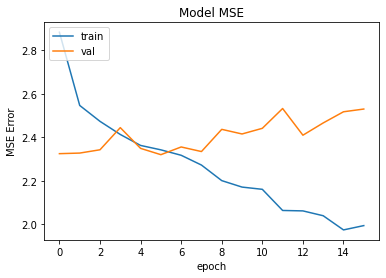

MAE: 1.0676919337800037
MSE: 2.628372063531636
RMSE: 1.6212254820140337
R2: 0.506038315623716
-- Test results saved


In [ ]:
for day in [3,4,5]:

  print('- Using values until day %s out of %s' %(int(day+1),len(final_df['days_since_live'].unique())))

  print('-- Preparing data')
  temp_df = final_df[final_df['days_since_live'] <= day]
  temp_df.sort_values(by=['property_id','days_since_live'], inplace=True)


  # Lets transform the dataset (which is in a pandas df, to a numpy array)
  dataset_features = temp_df.drop(['unique_offers_cut'],axis=1).to_numpy()

  # Since each property has 7 rows, representing 7 days of being live, they will need to be group in a 3-d array in order to be splitted later on into train, validation and test data.
  X = dataset_features.reshape(int(temp_df.shape[0] / (day + 1)), day + 1,temp_df.shape[1]-1)

  # Additionally, we will need the target variable, which is this case, it will be the total number of offers within 6 months
  y = temp_df[['property_id','unique_offers_cut']]
  y.drop_duplicates(subset=['property_id'], inplace=True)
  y = y['unique_offers_cut'].to_numpy()

  # Lets train test split the data to get a train, validation and testing set
  X_train, X_val, X_test, y_train, y_val, y_test = train_test_data_split(X, y)

  print('-- Transforming data')
  # Define transformer
  preprocessor = create_transformer(vars_cat, vars_num, daily_values_vars)
  # Fit transformer and use it on training
  preprocessor, X_train_df_encoded = preprocessor_fit_transform(preprocessor, X_train, temp_df, day)
  # Use fitted transformer in validation and test data
  X_val_encoded = preprocessor_transform(preprocessor, X_val, temp_df, day)
  X_test_encoded = preprocessor_transform(preprocessor, X_test, temp_df, day)
  print('-- Separating pre and post go live data')
  # Separate pre and pos go live features
  # Training data
  X_train_prego_live, X_train_posgo_live = separate_pre_pos_data(preprocessor, X_train_df_encoded, vars_cat, vars_num, 
                                                                 daily_values_vars, day)
  # Validation data
  X_val_prego_live, X_val_posgo_live = separate_pre_pos_data(preprocessor, X_val_encoded, vars_cat, vars_num, 
                                                             daily_values_vars, day)
  # Test data
  X_test_prego_live, X_test_posgo_live = separate_pre_pos_data(preprocessor, X_test_encoded, vars_cat, vars_num, 
                                                               daily_values_vars, day)
  
  del X_train_df_encoded
  del X_val_encoded
  del X_test_encoded

  print('-- Training models')
  print('--- Creating LSTM')
  model = None
  model = create_lstm_fc_model(input_shape_pre_go_live=(X_train_prego_live.shape[1],), 
                               input_shape_post_go_live=(X_train_posgo_live.shape[1], X_train_posgo_live.shape[2]))
  
  print('--- Training LSTM')
  history, model = train_model(model, [X_train_prego_live, X_train_posgo_live], y_train, 
                               [X_val_prego_live, X_val_posgo_live], y_val)
  print('--- Evaluating LSTM')
  plot_history(history)
  mae, mse, rmse, r2 = evaluate_model(model, [X_test_prego_live, X_test_posgo_live], y_test)
  all_scores.append([mae, mse, rmse, r2])

  print('-- Test results saved')

- Using values until day 7 out of 21
-- Preparing data
-- Transforming data
-- Separating pre and post go live data
-- Training models
--- Creating LSTM


--- Training LSTM
--- Evaluating LSTM


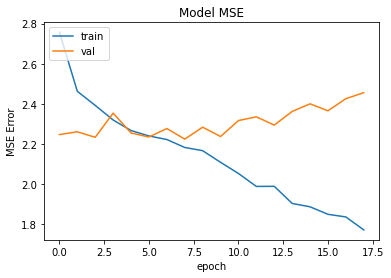

MAE: 1.0796607244875311
MSE: 2.5095641948702903
RMSE: 1.5841604069254762
R2: 0.5283664082615064
-- Test results saved
- Using values until day 8 out of 21
-- Preparing data
-- Transforming data
-- Separating pre and post go live data
-- Training models
--- Creating LSTM


--- Training LSTM
--- Evaluating LSTM


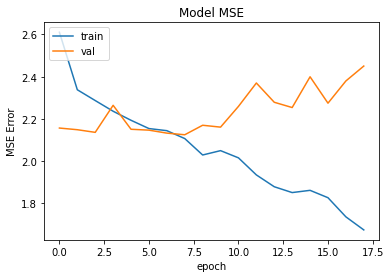

MAE: 1.0535131334339194
MSE: 2.4136957592799493
RMSE: 1.553607337547023
R2: 0.5463833909329379
-- Test results saved
- Using values until day 9 out of 21
-- Preparing data
-- Transforming data
-- Separating pre and post go live data
-- Training models
--- Creating LSTM


--- Training LSTM
--- Evaluating LSTM


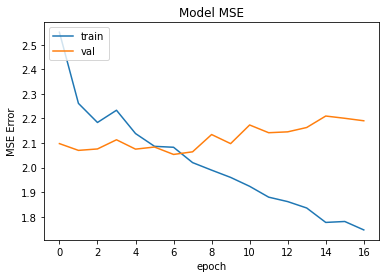

MAE: 1.0341430339837105
MSE: 2.3848741879354676
RMSE: 1.5443037874509884
R2: 0.5517999573792278
-- Test results saved


In [ ]:
for day in [6,7,8]:

  print('- Using values until day %s out of %s' %(int(day+1),len(final_df['days_since_live'].unique())))

  print('-- Preparing data')
  temp_df = final_df[final_df['days_since_live'] <= day]
  temp_df.sort_values(by=['property_id','days_since_live'], inplace=True)


  # Lets transform the dataset (which is in a pandas df, to a numpy array)
  dataset_features = temp_df.drop(['unique_offers_cut'],axis=1).to_numpy()

  # Since each property has 7 rows, representing 7 days of being live, they will need to be group in a 3-d array in order to be splitted later on into train, validation and test data.
  X = dataset_features.reshape(int(temp_df.shape[0] / (day + 1)), day + 1,temp_df.shape[1]-1)

  # Additionally, we will need the target variable, which is this case, it will be the total number of offers within 6 months
  y = temp_df[['property_id','unique_offers_cut']]
  y.drop_duplicates(subset=['property_id'], inplace=True)
  y = y['unique_offers_cut'].to_numpy()

  # Lets train test split the data to get a train, validation and testing set
  X_train, X_val, X_test, y_train, y_val, y_test = train_test_data_split(X, y)

  print('-- Transforming data')
  # Define transformer
  preprocessor = create_transformer(vars_cat, vars_num, daily_values_vars)
  # Fit transformer and use it on training
  preprocessor, X_train_df_encoded = preprocessor_fit_transform(preprocessor, X_train, temp_df, day)
  # Use fitted transformer in validation and test data
  X_val_encoded = preprocessor_transform(preprocessor, X_val, temp_df, day)
  X_test_encoded = preprocessor_transform(preprocessor, X_test, temp_df, day)
  print('-- Separating pre and post go live data')
  # Separate pre and pos go live features
  # Training data
  X_train_prego_live, X_train_posgo_live = separate_pre_pos_data(preprocessor, X_train_df_encoded, vars_cat, vars_num, 
                                                                 daily_values_vars, day)
  # Validation data
  X_val_prego_live, X_val_posgo_live = separate_pre_pos_data(preprocessor, X_val_encoded, vars_cat, vars_num, 
                                                             daily_values_vars, day)
  # Test data
  X_test_prego_live, X_test_posgo_live = separate_pre_pos_data(preprocessor, X_test_encoded, vars_cat, vars_num, 
                                                               daily_values_vars, day)
  
  del X_train_df_encoded
  del X_val_encoded
  del X_test_encoded

  print('-- Training models')
  print('--- Creating LSTM')
  model = None
  model = create_lstm_fc_model(input_shape_pre_go_live=(X_train_prego_live.shape[1],), 
                               input_shape_post_go_live=(X_train_posgo_live.shape[1], X_train_posgo_live.shape[2]))
  
  print('--- Training LSTM')
  history, model = train_model(model, [X_train_prego_live, X_train_posgo_live], y_train, 
                               [X_val_prego_live, X_val_posgo_live], y_val)
  print('--- Evaluating LSTM')
  plot_history(history)
  mae, mse, rmse, r2 = evaluate_model(model, [X_test_prego_live, X_test_posgo_live], y_test)
  all_scores.append([mae, mse, rmse, r2])

  print('-- Test results saved')

- Using values until day 10 out of 21
-- Preparing data
-- Transforming data
-- Separating pre and post go live data
-- Training models
--- Creating LSTM


--- Training LSTM
--- Evaluating LSTM


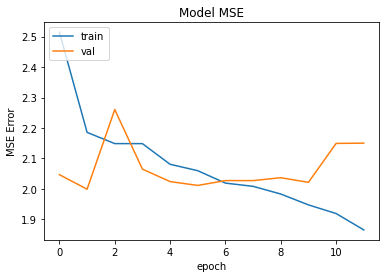

MAE: 0.9884311155998449
MSE: 2.38270624006285
RMSE: 1.54360171030705
R2: 0.5522073894919247
-- Test results saved
- Using values until day 11 out of 21
-- Preparing data
-- Transforming data
-- Separating pre and post go live data
-- Training models
--- Creating LSTM


--- Training LSTM
--- Evaluating LSTM


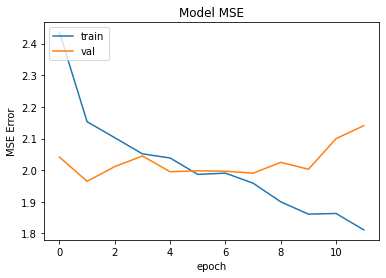

MAE: 0.9869415979009382
MSE: 2.30344522503925
RMSE: 1.5177105208303887
R2: 0.5671032655475485
-- Test results saved
- Using values until day 12 out of 21
-- Preparing data
-- Transforming data
-- Separating pre and post go live data
-- Training models
--- Creating LSTM


--- Training LSTM
--- Evaluating LSTM


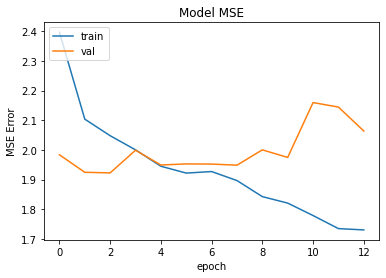

MAE: 0.992541366686337
MSE: 2.2342167530655117
RMSE: 1.4947296588565813
R2: 0.5801136810429088
-- Test results saved


In [ ]:
for day in [9,10,11]:

  print('- Using values until day %s out of %s' %(int(day+1),len(final_df['days_since_live'].unique())))

  print('-- Preparing data')
  temp_df = final_df[final_df['days_since_live'] <= day]
  temp_df.sort_values(by=['property_id','days_since_live'], inplace=True)


  # Lets transform the dataset (which is in a pandas df, to a numpy array)
  dataset_features = temp_df.drop(['unique_offers_cut'],axis=1).to_numpy()

  # Since each property has 7 rows, representing 7 days of being live, they will need to be group in a 3-d array in order to be splitted later on into train, validation and test data.
  X = dataset_features.reshape(int(temp_df.shape[0] / (day + 1)), day + 1,temp_df.shape[1]-1)

  # Additionally, we will need the target variable, which is this case, it will be the total number of offers within 6 months
  y = temp_df[['property_id','unique_offers_cut']]
  y.drop_duplicates(subset=['property_id'], inplace=True)
  y = y['unique_offers_cut'].to_numpy()

  # Lets train test split the data to get a train, validation and testing set
  X_train, X_val, X_test, y_train, y_val, y_test = train_test_data_split(X, y)

  print('-- Transforming data')
  # Define transformer
  preprocessor = create_transformer(vars_cat, vars_num, daily_values_vars)
  # Fit transformer and use it on training
  preprocessor, X_train_df_encoded = preprocessor_fit_transform(preprocessor, X_train, temp_df, day)
  # Use fitted transformer in validation and test data
  X_val_encoded = preprocessor_transform(preprocessor, X_val, temp_df, day)
  X_test_encoded = preprocessor_transform(preprocessor, X_test, temp_df, day)
  print('-- Separating pre and post go live data')
  # Separate pre and pos go live features
  # Training data
  X_train_prego_live, X_train_posgo_live = separate_pre_pos_data(preprocessor, X_train_df_encoded, vars_cat, vars_num, 
                                                                 daily_values_vars, day)
  # Validation data
  X_val_prego_live, X_val_posgo_live = separate_pre_pos_data(preprocessor, X_val_encoded, vars_cat, vars_num, 
                                                             daily_values_vars, day)
  # Test data
  X_test_prego_live, X_test_posgo_live = separate_pre_pos_data(preprocessor, X_test_encoded, vars_cat, vars_num, 
                                                               daily_values_vars, day)
  
  del X_train_df_encoded
  del X_val_encoded
  del X_test_encoded

  print('-- Training models')
  print('--- Creating LSTM')
  model = None
  model = create_lstm_fc_model(input_shape_pre_go_live=(X_train_prego_live.shape[1],), 
                               input_shape_post_go_live=(X_train_posgo_live.shape[1], X_train_posgo_live.shape[2]))
  
  print('--- Training LSTM')
  history, model = train_model(model, [X_train_prego_live, X_train_posgo_live], y_train, 
                               [X_val_prego_live, X_val_posgo_live], y_val)
  print('--- Evaluating LSTM')
  plot_history(history)
  mae, mse, rmse, r2 = evaluate_model(model, [X_test_prego_live, X_test_posgo_live], y_test)
  all_scores.append([mae, mse, rmse, r2])

  print('-- Test results saved')

- Using values until day 13 out of 21
-- Preparing data
-- Transforming data
-- Separating pre and post go live data
-- Training models
--- Creating LSTM


--- Training LSTM
--- Evaluating LSTM


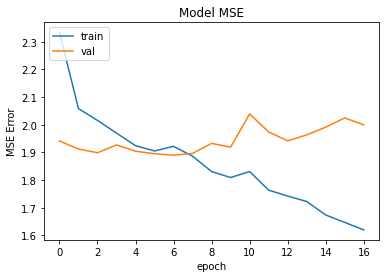

MAE: 0.9791710157650078
MSE: 2.1467356951768495
RMSE: 1.4651742883277912
R2: 0.5965543864153591
-- Test results saved
- Using values until day 14 out of 21
-- Preparing data
-- Transforming data
-- Separating pre and post go live data
-- Training models
--- Creating LSTM


--- Training LSTM
--- Evaluating LSTM


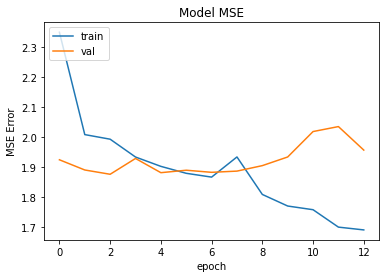

MAE: 0.9726336081861218
MSE: 2.160106030703784
RMSE: 1.4697299176051986
R2: 0.5940416396284045
-- Test results saved
- Using values until day 15 out of 21
-- Preparing data
-- Transforming data
-- Separating pre and post go live data
-- Training models
--- Creating LSTM


--- Training LSTM
--- Evaluating LSTM


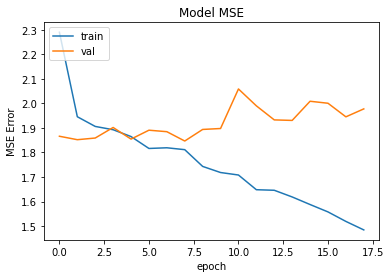

MAE: 0.9854976803988449
MSE: 2.271720423798921
RMSE: 1.507222751884711
R2: 0.5730654489365012
-- Test results saved


In [ ]:
for day in [12,13,14]:

  print('- Using values until day %s out of %s' %(int(day+1),len(final_df['days_since_live'].unique())))

  print('-- Preparing data')
  temp_df = final_df[final_df['days_since_live'] <= day]
  temp_df.sort_values(by=['property_id','days_since_live'], inplace=True)


  # Lets transform the dataset (which is in a pandas df, to a numpy array)
  dataset_features = temp_df.drop(['unique_offers_cut'],axis=1).to_numpy()

  # Since each property has 7 rows, representing 7 days of being live, they will need to be group in a 3-d array in order to be splitted later on into train, validation and test data.
  X = dataset_features.reshape(int(temp_df.shape[0] / (day + 1)), day + 1,temp_df.shape[1]-1)

  # Additionally, we will need the target variable, which is this case, it will be the total number of offers within 6 months
  y = temp_df[['property_id','unique_offers_cut']]
  y.drop_duplicates(subset=['property_id'], inplace=True)
  y = y['unique_offers_cut'].to_numpy()

  # Lets train test split the data to get a train, validation and testing set
  X_train, X_val, X_test, y_train, y_val, y_test = train_test_data_split(X, y)

  print('-- Transforming data')
  # Define transformer
  preprocessor = create_transformer(vars_cat, vars_num, daily_values_vars)
  # Fit transformer and use it on training
  preprocessor, X_train_df_encoded = preprocessor_fit_transform(preprocessor, X_train, temp_df, day)
  # Use fitted transformer in validation and test data
  X_val_encoded = preprocessor_transform(preprocessor, X_val, temp_df, day)
  X_test_encoded = preprocessor_transform(preprocessor, X_test, temp_df, day)
  print('-- Separating pre and post go live data')
  # Separate pre and pos go live features
  # Training data
  X_train_prego_live, X_train_posgo_live = separate_pre_pos_data(preprocessor, X_train_df_encoded, vars_cat, vars_num, 
                                                                 daily_values_vars, day)
  # Validation data
  X_val_prego_live, X_val_posgo_live = separate_pre_pos_data(preprocessor, X_val_encoded, vars_cat, vars_num, 
                                                             daily_values_vars, day)
  # Test data
  X_test_prego_live, X_test_posgo_live = separate_pre_pos_data(preprocessor, X_test_encoded, vars_cat, vars_num, 
                                                               daily_values_vars, day)
  
  del X_train_df_encoded
  del X_val_encoded
  del X_test_encoded

  print('-- Training models')
  print('--- Creating LSTM')
  model = None
  model = create_lstm_fc_model(input_shape_pre_go_live=(X_train_prego_live.shape[1],), 
                               input_shape_post_go_live=(X_train_posgo_live.shape[1], X_train_posgo_live.shape[2]))
  
  print('--- Training LSTM')
  history, model = train_model(model, [X_train_prego_live, X_train_posgo_live], y_train, 
                               [X_val_prego_live, X_val_posgo_live], y_val)
  print('--- Evaluating LSTM')
  plot_history(history)
  mae, mse, rmse, r2 = evaluate_model(model, [X_test_prego_live, X_test_posgo_live], y_test)
  all_scores.append([mae, mse, rmse, r2])

  print('-- Test results saved')

- Using values until day 16 out of 21
-- Preparing data
-- Transforming data
-- Separating pre and post go live data
-- Training models
--- Creating LSTM


--- Training LSTM
--- Evaluating LSTM


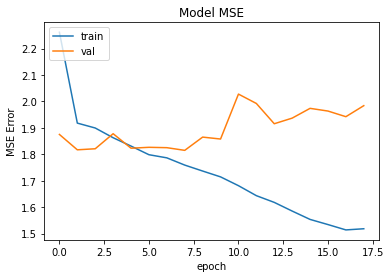

MAE: 0.9802668093552076
MSE: 2.1393418915569415
RMSE: 1.4626489297014993
R2: 0.5979439369058364
-- Test results saved
- Using values until day 17 out of 21
-- Preparing data
-- Transforming data
-- Separating pre and post go live data
-- Training models
--- Creating LSTM


--- Training LSTM
--- Evaluating LSTM


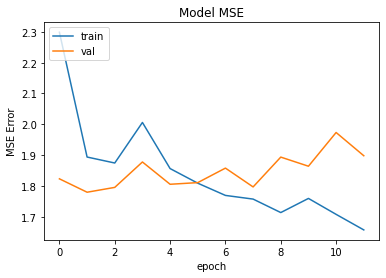

MAE: 0.9287004297218967
MSE: 2.132455218006348
RMSE: 1.4602928535079351
R2: 0.5992381801805995
-- Test results saved
- Using values until day 18 out of 21
-- Preparing data
-- Transforming data
-- Separating pre and post go live data
-- Training models
--- Creating LSTM


--- Training LSTM
--- Evaluating LSTM


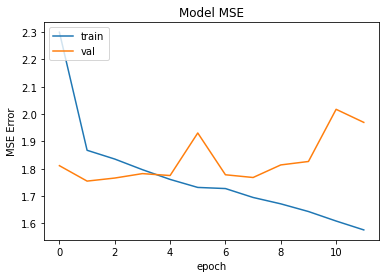

MAE: 0.9261241239009459
MSE: 2.0954027078447583
RMSE: 1.4475505890450802
R2: 0.6062016236685795
-- Test results saved


In [ ]:
for day in [15,16,17]:

  print('- Using values until day %s out of %s' %(int(day+1),len(final_df['days_since_live'].unique())))

  print('-- Preparing data')
  temp_df = final_df[final_df['days_since_live'] <= day]
  temp_df.sort_values(by=['property_id','days_since_live'], inplace=True)


  # Lets transform the dataset (which is in a pandas df, to a numpy array)
  dataset_features = temp_df.drop(['unique_offers_cut'],axis=1).to_numpy()

  # Since each property has 7 rows, representing 7 days of being live, they will need to be group in a 3-d array in order to be splitted later on into train, validation and test data.
  X = dataset_features.reshape(int(temp_df.shape[0] / (day + 1)), day + 1,temp_df.shape[1]-1)

  # Additionally, we will need the target variable, which is this case, it will be the total number of offers within 6 months
  y = temp_df[['property_id','unique_offers_cut']]
  y.drop_duplicates(subset=['property_id'], inplace=True)
  y = y['unique_offers_cut'].to_numpy()

  # Lets train test split the data to get a train, validation and testing set
  X_train, X_val, X_test, y_train, y_val, y_test = train_test_data_split(X, y)

  print('-- Transforming data')
  # Define transformer
  preprocessor = create_transformer(vars_cat, vars_num, daily_values_vars)
  # Fit transformer and use it on training
  preprocessor, X_train_df_encoded = preprocessor_fit_transform(preprocessor, X_train, temp_df, day)
  # Use fitted transformer in validation and test data
  X_val_encoded = preprocessor_transform(preprocessor, X_val, temp_df, day)
  X_test_encoded = preprocessor_transform(preprocessor, X_test, temp_df, day)
  print('-- Separating pre and post go live data')
  # Separate pre and pos go live features
  # Training data
  X_train_prego_live, X_train_posgo_live = separate_pre_pos_data(preprocessor, X_train_df_encoded, vars_cat, vars_num, 
                                                                 daily_values_vars, day)
  # Validation data
  X_val_prego_live, X_val_posgo_live = separate_pre_pos_data(preprocessor, X_val_encoded, vars_cat, vars_num, 
                                                             daily_values_vars, day)
  # Test data
  X_test_prego_live, X_test_posgo_live = separate_pre_pos_data(preprocessor, X_test_encoded, vars_cat, vars_num, 
                                                               daily_values_vars, day)
  
  del X_train_df_encoded
  del X_val_encoded
  del X_test_encoded

  print('-- Training models')
  print('--- Creating LSTM')
  model = None
  model = create_lstm_fc_model(input_shape_pre_go_live=(X_train_prego_live.shape[1],), 
                               input_shape_post_go_live=(X_train_posgo_live.shape[1], X_train_posgo_live.shape[2]))
  
  print('--- Training LSTM')
  history, model = train_model(model, [X_train_prego_live, X_train_posgo_live], y_train, 
                               [X_val_prego_live, X_val_posgo_live], y_val)
  print('--- Evaluating LSTM')
  plot_history(history)
  mae, mse, rmse, r2 = evaluate_model(model, [X_test_prego_live, X_test_posgo_live], y_test)
  all_scores.append([mae, mse, rmse, r2])

  print('-- Test results saved')

- Using values until day 19 out of 21
-- Preparing data
-- Transforming data
-- Separating pre and post go live data
-- Training models
--- Creating LSTM
--- Training LSTM
--- Evaluating LSTM


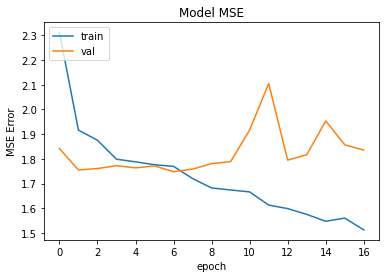

MAE: 0.9283335214331554
MSE: 2.0645874400071
RMSE: 1.4368672311689414
R2: 0.6119928743886711
-- Test results saved
- Using values until day 20 out of 21
-- Preparing data
-- Transforming data
-- Separating pre and post go live data
-- Training models
--- Creating LSTM
--- Training LSTM
--- Evaluating LSTM


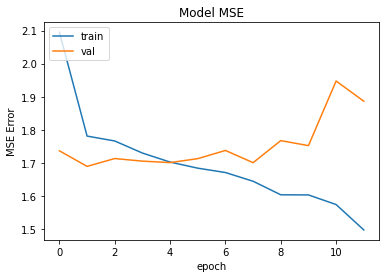

MAE: 0.9062112100537896
MSE: 2.0385497773370775
RMSE: 1.4277779159719055
R2: 0.6168862484616036
-- Test results saved
- Using values until day 21 out of 21
-- Preparing data
-- Transforming data
-- Separating pre and post go live data


In [ ]:
for day in [18,19,20]:

  print('- Using values until day %s out of %s' %(int(day+1),len(final_df['days_since_live'].unique())))

  print('-- Preparing data')
  temp_df = final_df[final_df['days_since_live'] <= day]
  temp_df.sort_values(by=['property_id','days_since_live'], inplace=True)


  # Lets transform the dataset (which is in a pandas df, to a numpy array)
  dataset_features = temp_df.drop(['unique_offers_cut'],axis=1).to_numpy()

  # Since each property has 7 rows, representing 7 days of being live, they will need to be group in a 3-d array in order to be splitted later on into train, validation and test data.
  X = dataset_features.reshape(int(temp_df.shape[0] / (day + 1)), day + 1,temp_df.shape[1]-1)

  # Additionally, we will need the target variable, which is this case, it will be the total number of offers within 6 months
  y = temp_df[['property_id','unique_offers_cut']]
  y.drop_duplicates(subset=['property_id'], inplace=True)
  y = y['unique_offers_cut'].to_numpy()

  # Lets train test split the data to get a train, validation and testing set
  X_train, X_val, X_test, y_train, y_val, y_test = train_test_data_split(X, y)

  print('-- Transforming data')
  # Define transformer
  preprocessor = create_transformer(vars_cat, vars_num, daily_values_vars)
  # Fit transformer and use it on training
  preprocessor, X_train_df_encoded = preprocessor_fit_transform(preprocessor, X_train, temp_df, day)
  # Use fitted transformer in validation and test data
  X_val_encoded = preprocessor_transform(preprocessor, X_val, temp_df, day)
  X_test_encoded = preprocessor_transform(preprocessor, X_test, temp_df, day)
  print('-- Separating pre and post go live data')
  # Separate pre and pos go live features
  # Training data
  X_train_prego_live, X_train_posgo_live = separate_pre_pos_data(preprocessor, X_train_df_encoded, vars_cat, vars_num, 
                                                                 daily_values_vars, day)
  # Validation data
  X_val_prego_live, X_val_posgo_live = separate_pre_pos_data(preprocessor, X_val_encoded, vars_cat, vars_num, 
                                                             daily_values_vars, day)
  # Test data
  X_test_prego_live, X_test_posgo_live = separate_pre_pos_data(preprocessor, X_test_encoded, vars_cat, vars_num, 
                                                               daily_values_vars, day)
  
  del X_train_df_encoded
  del X_val_encoded
  del X_test_encoded

  print('-- Training models')
  print('--- Creating LSTM')
  model = None
  model = create_lstm_fc_model(input_shape_pre_go_live=(X_train_prego_live.shape[1],), 
                               input_shape_post_go_live=(X_train_posgo_live.shape[1], X_train_posgo_live.shape[2]))
  
  print('--- Training LSTM')
  history, model = train_model(model, [X_train_prego_live, X_train_posgo_live], y_train, 
                               [X_val_prego_live, X_val_posgo_live], y_val)
  print('--- Evaluating LSTM')
  plot_history(history)
  mae, mse, rmse, r2 = evaluate_model(model, [X_test_prego_live, X_test_posgo_live], y_test)
  all_scores.append([mae, mse, rmse, r2])

  print('-- Test results saved')

- Using values until day 21 out of 21
-- Preparing data
-- Transforming data
-- Separating pre and post go live data
-- Training models
--- Creating LSTM
--- Training LSTM
--- Evaluating LSTM


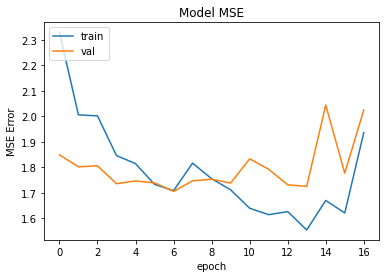

MAE: 0.9115342502722887
MSE: 1.9933832085232024
RMSE: 1.4118722351980728
R2: 0.625374603180616
-- Test results saved


In [ ]:
for day in [20]:

  print('- Using values until day %s out of %s' %(int(day+1),len(final_df['days_since_live'].unique())))

  print('-- Preparing data')
  temp_df = final_df[final_df['days_since_live'] <= day]
  temp_df.sort_values(by=['property_id','days_since_live'], inplace=True)


  # Lets transform the dataset (which is in a pandas df, to a numpy array)
  dataset_features = temp_df.drop(['unique_offers_cut'],axis=1).to_numpy()

  # Since each property has 7 rows, representing 7 days of being live, they will need to be group in a 3-d array in order to be splitted later on into train, validation and test data.
  X = dataset_features.reshape(int(temp_df.shape[0] / (day + 1)), day + 1,temp_df.shape[1]-1)

  # Additionally, we will need the target variable, which is this case, it will be the total number of offers within 6 months
  y = temp_df[['property_id','unique_offers_cut']]
  y.drop_duplicates(subset=['property_id'], inplace=True)
  y = y['unique_offers_cut'].to_numpy()

  # Lets train test split the data to get a train, validation and testing set
  X_train, X_val, X_test, y_train, y_val, y_test = train_test_data_split(X, y)

  print('-- Transforming data')
  # Define transformer
  preprocessor = create_transformer(vars_cat, vars_num, daily_values_vars)
  # Fit transformer and use it on training
  preprocessor, X_train_df_encoded = preprocessor_fit_transform(preprocessor, X_train, temp_df, day)
  # Use fitted transformer in validation and test data
  X_val_encoded = preprocessor_transform(preprocessor, X_val, temp_df, day)
  X_test_encoded = preprocessor_transform(preprocessor, X_test, temp_df, day)
  print('-- Separating pre and post go live data')
  # Separate pre and pos go live features
  # Training data
  X_train_prego_live, X_train_posgo_live = separate_pre_pos_data(preprocessor, X_train_df_encoded, vars_cat, vars_num, 
                                                                 daily_values_vars, day)
  # Validation data
  X_val_prego_live, X_val_posgo_live = separate_pre_pos_data(preprocessor, X_val_encoded, vars_cat, vars_num, 
                                                             daily_values_vars, day)
  # Test data
  X_test_prego_live, X_test_posgo_live = separate_pre_pos_data(preprocessor, X_test_encoded, vars_cat, vars_num, 
                                                               daily_values_vars, day)
  
  del X_train_df_encoded
  del X_val_encoded
  del X_test_encoded

  print('-- Training models')
  print('--- Creating LSTM')
  model = None
  model = create_lstm_fc_model(input_shape_pre_go_live=(X_train_prego_live.shape[1],), 
                               input_shape_post_go_live=(X_train_posgo_live.shape[1], X_train_posgo_live.shape[2]))
  
  print('--- Training LSTM')
  history, model = train_model(model, [X_train_prego_live, X_train_posgo_live], y_train, 
                               [X_val_prego_live, X_val_posgo_live], y_val)
  print('--- Evaluating LSTM')
  plot_history(history)
  mae, mse, rmse, r2 = evaluate_model(model, [X_test_prego_live, X_test_posgo_live], y_test)
  all_scores.append([mae, mse, rmse, r2])

  print('-- Test results saved')